# Environment set up

In [1]:
# load required packages

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
import pandas as pd
import random

from IPython.display import display

import getpass
import ndex2

import json
import cdapsutil
import pydot

# need ddot to parse the ontology
import ddot
from ddot import Ontology

# annotate the clusters
# gprofiler prelim annotation
from gprofiler import GProfiler
gp = GProfiler("MyToolName/0.1")

from statsmodels.stats import contingency_tables
from statsmodels.stats.multitest import fdrcorrection

import requests

# find human orthologs of mouse genes
import mygene
mg = mygene.MyGeneInfo()

from scipy.stats import hypergeom
from scipy.stats import norm

# latex rendering of text in graphs
import matplotlib as mpl
mpl.rc('text', usetex = False)
mpl.rc('font', family = 'serif')

from matplotlib import rcParams
rcParams['font.family'] = 'sans-serif'
rcParams['font.sans-serif'] = ['Arial']

sns.set(font_scale=1.4)

sns.set_style('white')

sns.set_style("ticks", {"xtick.major.size": 15, "ytick.major.size": 15})
plt.rcParams['svg.fonttype'] = 'none'

import sys
from tqdm import tqdm

# % matplotlib inline

from random import randint
from matplotlib.patches import Patch

DISCLAIMIER: cdapsutil is experimental and may contain errors and interfaces may change


In [2]:
## LOAD PCNET
interactome_uuid='4de852d9-9908-11e9-bcaf-0ac135e8bacf' # for PCNet
# interactome_uuid='275bd84e-3d18-11e8-a935-0ac135e8bacf' # for STRING high confidence
ndex_server='public.ndexbio.org'
ndex_user=None
ndex_password=None
G_int = ndex2.create_nice_cx_from_server(
            ndex_server, 
            username=ndex_user, 
            password=ndex_password, 
            uuid=interactome_uuid
        ).to_networkx()
nodes = list(G_int.nodes)

# pcnet appears to have some self edges... should remove them. 
G_int.remove_edges_from(nx.selfloop_edges(G_int))

# print out interactome num nodes and edges for diagnostic purposes
print('number of nodes:')
print(len(G_int.nodes))
print('\nnumber of edges:')
print(len(G_int.edges))

nodes = list(G_int.nodes)
pd.DataFrame(G_int.nodes).to_csv("pcnet_node_list.tsv", sep="\t", index=False, header=False)

number of nodes:
18820

number of edges:
2693109


In [3]:
## Load conserved network
ndex_server='public.ndexbio.org'
ndex_user=None
ndex_password=None
G_overlap_cx = ndex2.create_nice_cx_from_server(
            ndex_server, 
            username=ndex_user, 
            password=ndex_password, 
            uuid='e8cc9239-d91a-11eb-b666-0ac135e8bacf'
        )


# print out interactome num nodes and edges for diagnostic purposes
G_overlap = G_overlap_cx.to_networkx()
print('number of nodes:')
print(len(G_overlap.nodes))
print('\nnumber of edges:')
print(len(G_overlap.edges))

number of nodes:
657

number of edges:
5287


In [4]:
## load hierarchy data
hier_df_genes = pd.read_csv("hier_df_genes.tsv", sep="\t", index_col=0)
hier_df_genes.head()

CD_MemberList  frac_d1_seeds  \
C877  HELZ EMX2 HIST1H3A RAD51 SYT12 GYPC KDM3B ERC1...       0.353583   
C898  STX4 LSAMP SPOCK1 SGCB STXBP5 TRP-AGG2-6 GPRC5...       0.363636   
C904  BCL11B PKIB PKIA LMO1 NR2F1 LDB2 ZFPM2 GATA3 A...       0.300000   
C906  PROM2 SPINT1 TNIK PKP3 SSH3 FEZ2 CORIN WWC1 CAPN1       0.333333   
C911  ZNF629 ZKSCAN5 LINGO1 ZNF202 ZKSCAN2 ZNF263 ZN...       0.571429   

      frac_d2_seeds  
C877       0.177570  
C898       0.181818  
C904       0.200000  
C906       0.111111  
C911       0.142857

## Get enrichment results

In [5]:
results_old = pd.read_csv("full_results.tsv", sep = "\t", index_col=0)
results_old.head()

observed   total        OR      OR_p  OR_CI_lower  OR_CI_upper  \
MP:0000001     359.0  9108.0  1.367147  0.000110     1.166759     1.601951   
MP:0010768     194.0  4591.0  1.357213  0.000494     1.142930     1.611671   
MP:0010769     184.0  4194.0  1.419438  0.000084     1.192004     1.690267   
MP:0005384     182.0  4343.0  1.332818  0.001300     1.118747     1.587851   
MP:0010770     171.0  3621.0  1.549886  0.000002     1.296036     1.853458   

             hyper_p  sig_5e6           description   size  name  
MP:0000001  0.000044    False   mammalian phenotype  642.0  C877  
MP:0010768  0.000263    False       mortality/aging  642.0  C877  
MP:0010769  0.000050    False     abnormal survival  642.0  C877  
MP:0005384  0.000676    False    cellular phenotype  642.0  C877  
MP:0010770  0.000001     True  preweaning lethality  642.0  C877

## Get Mouse data

In [6]:
from netcoloc import validation

In [7]:
def load_MPO(url='http://www.informatics.jax.org/downloads/reports/MPheno_OBO.ontology', use_genes=True, mapping=None, restrict_to=None):
    """
    Function to parse and load mouse phenotype ontology, using DDOT's ontology module

    :param url: URL containing MPO ontology file
    :type url: str
    :return: MPO parsed using DDOT
    :rtype: :py:class:`ddot.Ontology`
    :raises ImportError: If DDOT package is not found
    """

    # download the mammalian phenotype ontology, parse with ddot
    r = requests.get(url, allow_redirects=True)
    open('MPheno_OBO.ontology', 'wb').write(r.content)
    ddot.parse_obo('MPheno_OBO.ontology',
                   'parsed_mp.txt',
                   'id2name_mp.txt',
                   'id2namespace_mp.txt',
                   'altID_mp.txt')

    MP2desc = pd.read_csv('id2name_mp.txt', sep='\t',
                          names=['MP', 'description'], index_col='MP')

    MP2desc = MP2desc.loc[MP2desc.index.dropna()]  # drop NAN from index
    print(len(MP2desc))

    #display(MP2desc.head())

    hierarchy = pd.read_table('parsed_mp.txt',
                              sep='\t',
                              header=None,
                              names=['Parent', 'Child', 'Relation', 'Namespace'])

    if use_genes:
        mouse_mapping = mapping.dropna().loc[:, ("human_ortholog", "MP")].reset_index()
        mouse_mapping = mouse_mapping.loc[:, ("human_ortholog", "MP")]
        mouse_mapping.columns = ["Gene", "Term"]
        if restrict_to is not None:
            mouse_mapping = mouse_mapping.loc[mouse_mapping.Gene.isin(restrict_to)]
        MPO = Ontology.from_table(
            table=hierarchy,
            parent='Parent',
            child='Child',
            add_root_name='MP:00SUPER',
            ignore_orphan_terms=True,
            mapping=mouse_mapping,
            mapping_parent='Term',
            mapping_child='Gene')
    else:
        #display(hierarchy.head())
        MPO = Ontology.from_table(
            table=hierarchy,
            parent='Parent',
            child='Child',
            add_root_name='MP:00SUPER',
            ignore_orphan_terms=True)

    # add description to node attribute
    terms_keep = list(np.unique(hierarchy['Parent'].tolist() + hierarchy['Child'].tolist()))
    MPO.node_attr = MP2desc.loc[terms_keep]

    return MPO

In [8]:
mgi_df = validation.load_MGI_mouseKO_data(url='http://www.informatics.jax.org/downloads/reports/MGI_PhenoGenoMP.rpt')

querying 1-1000...done.
querying 1001-2000...done.
querying 2001-3000...done.
querying 3001-4000...done.
querying 4001-5000...done.
querying 5001-6000...done.
querying 6001-7000...done.
querying 7001-8000...done.
querying 8001-9000...done.
querying 9001-10000...done.
querying 10001-11000...done.
querying 11001-12000...done.
querying 12001-13000...done.
querying 13001-14000...done.
querying 14001-15000...done.
querying 15001-16000...done.
querying 16001-17000...done.
querying 17001-18000...done.
querying 18001-19000...done.
querying 19001-20000...done.
querying 20001-21000...done.
querying 21001-22000...done.
querying 22001-23000...done.
querying 23001-24000...done.
querying 24001-24159...done.
Finished.
38 input query terms found dup hits:
	[('Abo', 3), ('Adam1a', 2), ('Adam1b', 2), ('Adam5', 2), ('Casp12', 2), ('Ccdc39', 2), ('Chaserr', 2
12267 input query terms found no hit:
	['+|Cav1', '+|Cm', '+|Del(10Prmt2-Pdxk)4Yey', '+|Del(11Mpo-Chad)18Brd', '+|Del(11Stat5a-Stat5b)1Mam'
Pass "re

In [9]:
MPO = validation.load_MPO(url='http://www.informatics.jax.org/downloads/reports/MPheno_OBO.ontology')

14555


description
MP                                               
MP:0000001                    mammalian phenotype
MP:0000002                    obsolete Morphology
MP:0000003     abnormal adipose tissue morphology
MP:0000011     abnormal adipose tissue morphology
MP:0000005  increased brown adipose tissue amount

Parent       Child Relation        Namespace
0  MP:0005375  MP:0000003     is_a  MPheno.ontology
1  MP:0001778  MP:0000005     is_a  MPheno.ontology
2  MP:0001781  MP:0000008     is_a  MPheno.ontology
3  MP:0005334  MP:0000010     is_a  MPheno.ontology
4  MP:0000003  MP:0000013     is_a  MPheno.ontology

In [10]:
mouse_orthos = pd.read_csv("pcnet_node_list_MsOrtho.tsv", sep="\t")

In [11]:
MPO2 = load_MPO(url='http://www.informatics.jax.org/downloads/reports/MPheno_OBO.ontology', use_genes=True, mapping=mgi_df)
              # restrict_to = mouse_orthos.HsOrtho.values)

14555


# Perform Enrichment

## Enrichment functions

In [12]:
def genes_per_node(MPO):
    node_order = MPO.topological_sorting(top_down=False)
    nodes = [i for i in node_order]
    results = {i: set(MPO.term_2_gene[i]) for i in node_order}
    genes = {i: set(MPO.gene_2_term[i]) for i in MPO.genes}
    while len(nodes) > 0:
        current = nodes.pop()
        children = MPO.parent_2_child[current]
        if len(children) > 0:
            for child in children:
                if child != current:
                    results[current] = results[current].union(results[child])
        for gene in results[current]:
            if gene not in genes.keys():
                genes[gene] = set([current])
            else:
                genes[gene] = genes[gene].union(set([current]))
        else:
            pass
    counts = {k: len(results[k]) for k in results.keys()}
    return counts, genes, results

def community_term_enrichment_or(community_name, hier_df, MPO, mgi_df, term_counts, gene_to_terms):
    # get the genes in the community
    genes = hier_df.loc[community_name, "CD_MemberList"]
    if type(genes) is str:  # split into a list of genes
        genes_all = genes.split(" ")
    genes = [ g for g in genes_all if g in MPO.genes ]  # only keep genes in the MGI ontology
    
    if len(genes) == 0:
        print("0/"+str(len(genes_all)), "in MPO.genes")
        return pd.DataFrame()
        
    N_hier = len(genes)
    # Get the terms associated with these genes
    terms = []
    for gene in genes:
        terms += list(gene_to_terms[MPO.genes.index(gene)])

    # Join term totals and observed
    to_test = pd.DataFrame(pd.Series(terms, name="observed").value_counts()).join(pd.Series(term_counts, name="total"))
    M_pool_size = len(MPO.genes)
    
    # Get odss ratio, p value of odds ratio, and 95% confidence interval
    OR_test = to_test.apply(lambda x: get_contingency_stats(x.observed, x.total, N_hier, M_pool_size), axis=1)
    try: 
        OR_test = pd.concat(list(OR_test), ignore_index=True)
    except TypeError:
        print(OR_test)
        print(N_hier, terms)
    OR_test.index = to_test.index
    to_test = pd.concat([to_test, OR_test], axis=1)
    
    to_test = to_test.assign(hyper_p=lambda z: hypergeom.sf(k=z.observed, M=M_pool_size, n=z.total, N=N_hier))
    desc = MPO.node_attr.loc[to_test.index]
    to_test = to_test.assign(sig_5e6=to_test["hyper_p"] < 5e-6)
    to_test = to_test.join(desc, how="left")
    to_test = to_test.assign(size=N_hier)
    ## TODO - should I filter some terms out? Due to too small?
    ## TODO - do OR stuff as well.
    return to_test

def get_contingency_stats(observed, term_size, community_size, network_size):
    q00 = observed
    q01 = term_size - observed
    q10 = community_size - observed
    q11 = network_size - q00 - q01 - q10
    results_table = [[q00, q01], [q10, q11]]
    #print(results_table)
    CT = contingency_tables.Table2x2(results_table)
    OR_p_temp = CT.oddsratio_pvalue()
    OR_CI_temp = CT.oddsratio_confint()
    OR = CT.oddsratio
    #print(CT.chi2_contribs)
    #return CT
    return pd.DataFrame({"OR":OR, "OR_p": OR_p_temp, "OR_CI_lower":OR_CI_temp[0], "OR_CI_upper":OR_CI_temp[1]}, index=[0])


def get_gene_hits(community_name, hier_df, term_mapping, term_query, MPO, mp_graph):
    genes = hier_df.loc[community_name, "CD_MemberList"]
    if type(genes) is str:  # split into a list of genes
        genes_all = genes.split(" ")
    term_to_include = nx.dfs_preorder_nodes(mp_graph, term_query)
    msOrthos = [1 if g in MPO.genes else 0 for g in genes_all]
    gene_hits = []
    for term in term_to_include:
        term_genes = [MPO.genes[i] for i in term_mapping[term]]
        genes_in_term = set(term_genes).intersection(set(genes_all))
        hits = [1 if g in genes_in_term else 0 for g in genes_all]
        gene_hits.append(pd.DataFrame({"gene":genes_all, "community":community_name,"MP": term, "MP_parent":term_query, "inMP": hits, 
                                       "MsOrtho":msOrthos}))
    gene_hits = pd.concat(gene_hits)
    desc = MPO.node_attr.loc[gene_hits.MP]
    gene_hits = gene_hits.assign(description=desc.values)
    return gene_hits

def get_gene_hits_no_annotation(genes, term, MPO, term_mapping):
    term_genes = [MPO.genes[idx] for idx in term_mapping[term]]
    overlap = set(genes).intersection(set(term_genes))
    return overlap


In [13]:
mp_graph = _get_mp_graph()
root="MP:0000001"


NameError: name '_get_mp_graph' is not defined

In [ ]:
term_counts, gene_mapping, term_mapping = genes_per_node(MPO2)

In [ ]:
results_old

In [ ]:
len(term_mapping["MP:0014021"])

## Plotting Functions

In [ ]:
def plot_hierarchy_heatmap(enrichment_results,MPO, term_counts,value="hyper_p", root="MP:0000001", levels=1, min_term_size=5,
                          min_observation=1, min_percent=0):
    plot_df, mpG = _subset_results(enrichment_results, root, MPO)
    plot_df.loc[(plot_df.observed < min_observation), (value)] = 0
    plot_df["percent"] = plot_df.apply(lambda x: max(x.observed/x["size"], x.observed/x["total"]), axis=1)
    plot_df.loc[plot_df["percent"] < min_percent, ("value")] = 0
    
    all_terms = [k for k in term_counts.keys() if term_counts[k] >= min_term_size]
   
    
    fill_MP = [t for t in all_terms if t not in plot_df.MP]
    filler = pd.DataFrame({"MP":fill_MP, value:0, "name":plot_df.name[0], "size":plot_df["size"][0]}, index = [t for t in all_terms if t not in plot_df.MP])
    plot_df = pd.concat([plot_df, filler], axis=0)

    plot_df, colors, parent_map = _annotate_results(plot_df, root, mpG, levels=levels)
    
    #return plot_df
    to_plot = plot_df.pivot(columns="name", values=value)
    
    node_order = [node for node in nx.dfs_preorder_nodes(mpG, root)][1:]
    node_order = [node for node in node_order if node in plot_df.MP]
    to_plot = to_plot.loc[node_order]    
    #return to_plot, parent_map, colors
    color_list = [colors[parent_map.loc[node].parent] for node in to_plot.index]
    if levels == 2:
        color_list = [color_list, [colors[parent_map.loc[node].parent2] for node in to_plot.index]]
        assert len(to_plot) == len(color_list[0])
    else:
        assert len(to_plot) == len(color_list)
    x = sns.color_palette('flare', as_cmap=True)
    community_sizes = plot_df.loc[:, ("size", "name")].reset_index(drop=True).drop_duplicates()
    community_sizes.index=community_sizes["name"]
    community_sizes = community_sizes.loc[:,"size" ].to_dict()
    col_colors=[x(community_sizes[c]/max(plot_df["size"])) for c in to_plot.columns]

   #col_colors = {results.name.unique()[i]: color[i] for i range[n]}
    sns.clustermap(to_plot.fillna(0), xticklabels=True, yticklabels=False, cmap='viridis_r',
                  row_cluster=False, col_cluster=True, row_colors=color_list, col_colors=col_colors)
    handles = [Patch(facecolor=colors[node]) for node in plot_df.parent.unique()]
    
    print("handles", len(handles))
    if levels == 1:
        cmap1 = {MPO.node_attr.loc[node, "description"]: colors[node] for node in plot_df.parent.unique()}
        plt.legend(handles, cmap1, title="Mammalian Phenotypes")
    elif levels == 2:
        all_parents = list(plot_df.parent.unique()) + list(plot_df.sub_parent.unique())
        handles2 = [Patch(facecolor=colors[node]) for node in all_parents]
        cmap2 = {MPO.node_attr.loc[node, "description"]: colors[node] for node in all_parents}
        plt.legend(handles2, cmap2, title="Mammalian Phenotypes", loc="right")
        
    plot_df.loc[plot_df.MP.isin(fill_MP), ("name")] = 'fill'
    return plot_df, mpG, colors, parent_map


def plot_specific_community(plot_df, mpG, community, root, colors,MPO, parent_map, value="log10P"):
    all_MP = plot_df.MP.unique()
    plot_df["expected"] = plot_df.apply(lambda x: x["total"] * x["size"] / 18820 , axis=1)
    #return plot_df
    plot_subset = plot_df.loc[((plot_df.name == community) & (plot_df.expected > 1))]
    #return plot_subset
    filler_mp = [mp for mp in all_MP if mp not in plot_subset.MP]
    filler = pd.DataFrame({"MP":filler_mp, value:0, "size":plot_df["size"][0]}, index = [t for t in filler_mp])
    plot_subset = pd.concat([plot_subset, filler], axis=0)
    node_order = [node for node in nx.dfs_preorder_nodes(mpG, root)][1:]
    node_order = [node for node in node_order if node in plot_df.MP]
    plot_subset = plot_subset.loc[node_order]
    plot_subset["parents"] = [parent_map.loc[node].parent for node in plot_subset.index]
    plot_subset["number"] = [i for i in range(len(plot_subset))][::-1]
    #plt.scatter(x=plot_subset.number, y = plot_subset.log10P)
    cmap = {MPO.node_attr.loc[node, "description"]: colors[node] for node in colors.keys()}
    plot_subset["description"] = [MPO.node_attr.loc[node, "description"] for node in plot_subset.parents]
    g = sns.lmplot(y='number', x=value, data=plot_subset, hue='description', fit_reg=False, palette=cmap, height=11)
    g.set(yticks=[], ylabel="", title=community)
    return plot_subset
    
    
def plot_sum_of_nodes(plot_df, mpG, root, colors, MPO, parent_map, cutoff=0.01):
    plot_df["keep"] = a.hyper_p.apply(lambda x: 1 if x < cutoff else 0)
    node_counts = plot_df.groupby("MP").keep.sum()
    to_plot = pd.concat([node_counts, parent_map], axis=1)
    node_order = [node for node in nx.dfs_preorder_nodes(mpG, root)][1:]
    node_order = [node for node in node_order if node in to_plot.child]
    to_plot = to_plot.loc[node_order]
    to_plot["parents"] = [parent_map.loc[node].parent for node in to_plot.index]
    to_plot["number"] = [i for i in range(len(to_plot))][::-1]
    cmap = {MPO.node_attr.loc[node, "description"]: colors[node] for node in colors.keys()}
    to_plot["description"] = [MPO.node_attr.loc[node, "description"] for node in to_plot.parents]
    to_plot["number"] = [i for i in range(len(to_plot))][::-1]
    g = sns.lmplot(data=to_plot, x="keep", y="number", height=11, aspect=0.5, fit_reg=False, hue='description', palette=cmap)
    g.set(yticks=[], ylabel="", title="<"+str(cutoff))
    

def _subset_results(results, root, MPO, min_term_size=5):
    mp_graph = _get_mp_graph()
    results = results.assign(MP=results.index)
    results = results.loc[results.MP != root]
    include_nodes = [node for node in nx.dfs_preorder_nodes(mp_graph, root) if node in results.MP]
    results_subset = results.assign(MP=results.index)
    results_subset = results.assign(log10P=lambda x: -1 * np.log10(x.hyper_p + 1e-10))
    results_subset = results_subset.loc[results.MP.isin(include_nodes)]
    results_subset = results_subset.loc[results_subset.total >= min_term_size]
    return results_subset, mp_graph


def _get_mp_graph(datafile="parsed_mp.txt"):
    mp_data = pd.read_csv(datafile, sep="\t", header=None)
    mp_data.head()
    mp_graph = nx.from_pandas_edgelist(mp_data, 0,1, create_using=nx.DiGraph)
    return mp_graph


def _annotate_results(results_subset, root, mp_graph, levels=1):
    parents = [node for node in nx.dfs_preorder_nodes(mp_graph, root, 1)][1:]
    # color map
    color = []
    color_map = {}
    n = len(parents)
    for i, parent in enumerate(parents):
        color.append('#%06X' % randint(0, 0xFFFFFF))
        color_map[parent] = color[i]
        
    # parent map
    parent_map = []
    for parent in parents:
        
        if levels == 2:
            children = [node for node in nx.dfs_preorder_nodes(mp_graph, parent, 1)][1:]
            for sub_parent in children:
                color_map[sub_parent] = '#%06X' % randint(0, 0xFFFFFF)
                sub_children = [node for node in nx.dfs_preorder_nodes(mp_graph, sub_parent)]
                parent_map.append(pd.DataFrame({"child":sub_children, "parent":parent, "parent2": sub_parent}))
        else:
            children = [node for node in nx.dfs_preorder_nodes(mp_graph, parent)][1:]
            parent_map.append(pd.DataFrame({"child":children, "parent":parent}))
    parent_map = pd.concat(parent_map)
    parent_map = parent_map.drop_duplicates(subset="child")
    parent_map.index = parent_map.child
    # add parent to results
    
    results_subset = results_subset.loc[results_subset.MP.isin(parent_map.index)]
    results_subset.loc[:, "parent"] = results_subset.MP.apply(lambda x: parent_map.loc[x].parent if x not in parents else x)
    #return results_subset, parent_map
    if levels == 2:
        results_subset.loc[:, "sub_parent"] = results_subset.MP.apply(lambda x: parent_map.loc[x].parent2)
        results_subset = results_subset.sort_values(by=["parent", "sub_parent"])
    else:
        results_subset = results_subset.sort_values(by=["parent"]) 
    return results_subset, color_map, parent_map


def plot_CIs(results, root, mp_graph=mp_graph, use_node="C877", plot_by="OR_CI_lower", ascending=True):
    top_level = [node for node in nx.dfs_preorder_nodes(mp_graph, root, 1)]
    exclude=[root, "MP:0002873", "MP:0003012"] # mammalian phenotype, normal phenotype, no_phenotypic analysis
    n_tests = len([node for node in top_level if node not in exclude])
    top_level = [node for node in top_level if (node not in exclude) and (node in results.loc[results.name==use_node].index)]
    to_plot= results.loc[results.name==use_node].loc[top_level].sort_values(by=plot_by, ascending=ascending)
    plt.figure(figsize=[7,len(to_plot)/2])
    ax = plt.scatter(to_plot.OR, [i for i in range(len(to_plot))])
    plt.hlines([i for i in range(len(to_plot))], to_plot.OR_CI_lower, to_plot.OR_CI_upper)
    plt.vlines(1.0, -1, len(to_plot), linestyles='dashed', colors='black')
    ylabels = [to_plot.loc[node, "description"] + " (N=" + str(int(to_plot.loc[node, "total"]))+")" for node in to_plot.index]
    
    a=plt.yticks(ticks=[i for i in range(len(to_plot))], labels=ylabels)
    if max(to_plot.OR_CI_upper) > 5:
        plt.xscale('log')    
    plt.xlabel("Odds ratio with 95% confidence interval")
    desc = results.loc[root, "description"].unique()[0]
    plt.title(use_node + " Enrichment for " + desc+"s")
    diff = len(top_level) - n_tests
    if diff > 0:
        to_plot["q_OR"] = fdrcorrection(list(to_plot["OR_p"].values)+[1 for _ in range(0)])[1][:(-1*diff)]
        to_plot["q_hyper"] = fdrcorrection(list(to_plot["hyper_p"].values)+[1 for _ in range(0)])[1][:(-1*diff)]
    else:
        to_plot["q_OR"] = fdrcorrection(to_plot["OR_p"])[1]
        to_plot["q_hyper"] = fdrcorrection(to_plot["hyper_p"])[1]
    
    print("Significant traits (q < 0.05):\n", to_plot.sort_values(by="q_OR").loc[(to_plot["q_OR"] < 0.05), ("description", "q_OR", "q_hyper")])
    return to_plot
    
    
def plot_specific_CIs(results, mp_list, n_test, mp_graph=mp_graph, use_node="C877", sort=False):
    top_level = [node for node in mp_list if (node in results.loc[results.name==use_node].index)]
    to_plot= results.loc[results.name==use_node].loc[top_level]
    colors = ["blue" for _ in range(n_test)] + ["orange" for _ in range(len(top_level)-n_test)]
    to_plot["c"] = colors
    if sort:
        to_plot = to_plot.sort_values(by="OR_CI_lower")
    plt.figure(figsize=[7,len(to_plot)/3+0.1])
    
    ax = plt.scatter(to_plot.OR, [i for i in range(len(to_plot))], c=to_plot["c"], alpha=0.7)
    plt.hlines([i for i in range(len(to_plot))], to_plot.OR_CI_lower, to_plot.OR_CI_upper, colors=to_plot["c"], alpha=0.7)
    plt.vlines(1.0, -1, len(to_plot), linestyles='dashed', colors='black')
    ylabels = [to_plot.loc[node, "description"] + " (N=" + str(int(to_plot.loc[node, "total"]))+")" for node in to_plot.index]
    ylabels = [desc.split("abnormal ")[1] if ("abnormal" in desc) else desc for desc in ylabels]
    a=plt.yticks(ticks=[i for i in range(len(to_plot))], labels=ylabels)
    if max(to_plot.OR_CI_upper) > 5:
        plt.xscale('log')    
    plt.xlabel("Odds ratio with 95% confidence interval")
    try:
        desc = results.loc[root, "description"].unique()[0]
    except AttributeError:
        desc = results.loc[root, "description"]
    plt.title("Enrichment for " + desc+"s")
    return to_plot

from statsmodels.stats.multitest import fdrcorrection
from matplotlib.patches import Patch


from statsmodels.stats.multitest import fdrcorrection
from matplotlib.patches import Patch


def plot_hbar_comparison(data_all, communities, mps, sig_level=0.05, community_names=None, sort_by_q=False, 
                         label_number="total", vert=20, color_idx=None, mp_graph=None):
    # Check inputs --------
    assert len(communities) == len(community_names), "Length of community names and communities must be equal"
    assert sig_level < 1.0 and sig_level > 0
    assert all([c in data_all.name.values for c in communities]), "Not all specified communities in data"
    
    if type(mps) == str and mp_graph is not None:
        mps = [node for node in nx.dfs_preorder_nodes(mp_graph, mps, 1) if node in data_all.index][1:]
    
    # Set up color variables --------
    colors = [(14/255,142/255,18/255), (3/255,67/255,223/255), (250/255,160/255,0/255), (181/255,7/255,72/255)]
    if len(communities) == 1:
        if color_idx is None:
            colors = [colors[1]]
        else:
            colors = [colors[color_idx]]
    cmap = {comm:colors[c] for c, comm in enumerate(communities)}
    
    # Initialize plotting parameters --------
    height=((1-0.3)/len(communities))
    n_tests = len(communities) * len(mps)
    community_plot_data = []
    data = data_all.loc[mps]
    data = data.loc[data.name.isin(communities)]
    
    ## Perform P-value correction
    if len(data) < n_tests:
        diff = n_tests - len(data)
        data["q"] = fdrcorrection(list(data["OR_p"]) + [1 for _ in range(diff)], method="poscorr")[1][:(-1*diff)]
        data["q_hyper"] = fdrcorrection(list(data["hyper_p"]) + [1 for _ in range(diff)], method="poscorr")[1][:(-1*diff)]
    else:
        data["q"] = fdrcorrection(data["OR_p"], method="poscorr")[1]
        data["q_hyper"] = fdrcorrection(data["hyper_p"], method="poscorr")[1]
    
    # Sort the data
    if sort_by_q:
        sort_data = data.loc[data.name==communities[0]].sort_values(by=["q", "OR_p"])
        if all([mp in sort_data.index for mp in mps]):
            mps = list(sort_data.index.values)
        else:
            if len(communities) == 1:
                mps = list(sort_data.index.values)
            else:
                extra_mps = [mp for mp in mps if mp not in sort_data.index ]
                mps = list(sort_data.index.values) + extra_mps
            
            
    for c, comm in enumerate(communities):
        plot_data = pd.DataFrame({"mps":mps, "community":comm, "left":1.0, "width":0.0, "upper":0, "lower":0, 
                                  "fill":[(1,1,1)], "hatch":""}, index=mps)  
        comm_nodes = [node for node in mps if (node in data.loc[data.name==comm].index)]
        results = data.loc[data.name==comm]
        results = results.assign(sig=[cmap[comm] if val<sig_level else (1,1,1) for val in results["q"]])
        sig_bars = results.loc[results["q"] < sig_level].index
        results = results.assign(hypsig=["/" if val < sig_level else "" for val in results.q_hyper])
        plot_data = plot_data.assign(left=[min(1, results.loc[mp, "OR"]) if mp in results.index else 1.0 for mp in plot_data.index], 
                                         width=[max(1-results.loc[mp, "OR"], results.loc[mp, "OR"]-1) if mp in results.index else 0.0 for mp in plot_data.index], 
                                         upper=[results.loc[mp, "OR_CI_upper"] - results.loc[mp, "OR"] if mp in results.index else 0.0 for mp in plot_data.index],
                                        lower =[results.loc[mp, "OR"] - results.loc[mp, "OR_CI_lower"] if mp in results.index else 0.0 for mp in plot_data.index],
                                        fill =[results.loc[mp, "sig"] if mp in results.index else (1,1,1) for mp in plot_data.index], 
                                        hatch = [results.loc[mp, "hypsig"] if mp in results.index else ""for mp in plot_data.index])
        neg_bars = plot_data.loc[plot_data["left"] < 1].index
        plot_data = plot_data.assign(upper=[results.loc[x, "OR_CI_upper"] - 1 if x in neg_bars else plot_data.loc[x, "upper"] for x in plot_data.index])
        plot_data = plot_data.assign(lower=[1- results.loc[x, "OR_CI_lower"] if x in neg_bars else plot_data.loc[x, "lower"] for x in plot_data.index])
        # TODO finish up to get the right color scheme as before without iteration
        #return plot_data, cmap, comm, sig_bars
        plot_data = plot_data.assign(edgecolor=[cmap[comm] if mp in results.index else (1,1,1) for mp in plot_data.index ])
        plot_data = plot_data.assign(ecolor=[(darken(cmap[comm])) if mp in sig_bars else (alpha_blending(cmap[comm], 0.3)) for mp in plot_data.index])
        plot_data = plot_data.assign(y=[-1*(i+c*height) for i in range(len(plot_data))])
    
        
        community_plot_data.append(plot_data)

    all_plot_data = pd.concat(community_plot_data, axis=0)
    
    #return all_plot_data
    plt.figure(figsize=(10, vert), frameon=False)
    ax = plt.subplot(111)
    ax.barh(data=all_plot_data, y="y", height=height, left="left", color="fill", width="width", 
             xerr=(all_plot_data.lower, all_plot_data.upper), 
             edgecolor="edgecolor", ecolor="ecolor", alpha=0.7)

    handles = [Patch(facecolor=cmap[comm]) for comm in communities]
    handle_map = {community_names[c] +  " (N=" + str(int(data.loc[data["name"]==comm, "size"].values[0])) + ")": colors[c] for c, comm in enumerate(communities)}
    
    if label_number in ["total"]:
        ylabels = [data.loc[node, "description"].values[0] + " (" + str(int(data.loc[node, label_number][0]))+")" for node in mps]
    elif label_number == "observed" and len(communities) == 1:
        ylabels = [data.loc[node, "description"] + " (" + str(int(data.loc[node, label_number]))+")" for node in mps]

    elif label_number == "percent_community" and len(communities) == 1:
        comm_size = data["size"].values[0]/100
        ylabels = [data.loc[node, "description"] + 
                   " (" + str(round(int(data.loc[node, "observed"])/comm_size))+'%)'  if node in data.index else
                   data.loc[node, "description"] + " (0%)" for node in mps]
    else:
        ylabels = [data_all.loc[node, "description"].values[0] for node in mps]
        
    ylabels = [desc.split("abnormal ")[1] if "abnormal" in desc else desc for desc in ylabels] 
    ylabels = [desc.replace("physiology", "phys.") for desc in ylabels]
    ylabels = [desc.replace("morphology", "morph.") for desc in ylabels]
    ylabels = [desc.replace(" phenotype", "") for desc in ylabels]
    a=ax.set_yticks(ticks=[-1*(i + height*len(communities)/4) for i in range(len(mps))] )
    ax.set_yticklabels(labels=ylabels)
    ax.set_xlabel("Odds ratio with 95% confidence interval")
    #plt.xlim((0, max(all_plot_data.width + all_plot_data.upper)*1.1))
    if max(all_plot_data.width) > 9:
        plt.xscale("log")
    ax.set_ylim((-1* len(mps), 3))
    if not sort_by_q:
        plt.legend(handles, handle_map, loc="upper right")
    else:
        plt.legend(handles, handle_map, loc="upper left")
    
    return data, ax


def alpha_blending(foreground_tuple, alpha) :
    """ alpha blending as if on the white background.
    """
    foreground_arr = np.array(foreground_tuple)
    final = tuple( (1. -  alpha) + foreground_arr*alpha )
    return final


def darken(color_tuple, factor=0.25):
    color = np.array(color_tuple)
    color = color * (1-factor)
    return tuple(color)
    



## Enrichment Results
TODO
* name the communities
* enforce a minimum percent of community e.g. 10% so must be 8/80?

In [ ]:
results_old.head()

In [ ]:
def plot_volcano(data, communities=None, sig="OR_p", total="total"):
    if communities is not None:
        data = data.loc[data.name.isin(communities)]
    plt.scatter(x=data["OR"], y=data[sig], s = data[total]//50)
    plt.xlabel("OR")
    plt.ylabel("q")

In [ ]:
100//40

### Top-level data

In [ ]:
#a = plot_CIs(results_old, "MP:0000001", plot_by="OR_p", ascending=False)
top_level = [node for node in nx.dfs_preorder_nodes(mp_graph, "MP:0000001", 1) if node not in ["MP:0000001", "MP:0003012", "MP:0002873"]]
a = plot_hbar_comparison(results_old, communities=["C877"], mps=top_level, 
                         sig_level=0.05, community_names=["BMI Network"], sort_by_q=True, label_number="percent_community")


In [ ]:
plot_CIs(results_old, "MP:0000001")

In [ ]:
a = plot_hbar_comparison(results_old, communities=["C877"], mps="MP:0004924", mp_graph=mp_graph, vert = 8,
                         sig_level=0.05, community_names=["BMI Network"], sort_by_q=True, label_number="percent_community")

In [ ]:
a = plot_hbar_comparison(results_old, communities=["C877"], mps="MP:0001431", mp_graph=mp_graph, vert = 8,
                         sig_level=0.05, community_names=["BMI Network"], sort_by_q=True, label_number="percent_community")

In [ ]:
plot_CIs(results_old, "MP:0001431")

In [ ]:
plot_CIs(results_old, "MP:0005378")

In [ ]:
plot_CIs(results_old, "MP:0004196")

In [ ]:
plot_CIs(results_old, "MP:0002089")

## Community choice

#### How do we justify choice of communities?
Volcano plot below can give us a shortlist. We could exclude based on:  
* Size of community
* Grouping of closely related communities
* Communities that do not have names after GO annotation
* Communities that do not have any high level enrichments

Either way I think we might have to include C894, though it does have a high proportion of seed genes. Either we can say something interesting about the novel genes or not. But even if not we could use it as a kind of validation of known biology to lead with?


In [ ]:
body_size_traits = ["MP:0005378", "MP:0003956", "MP:0010866", "MP:0005451"]

In [257]:
a = results_old.loc[body_size_traits[0]].sort_values(by="OR_CI_lower", ascending=False)
a = a[a.name != "C877"]
a["q"] = fdrcorrection(list(a.OR_p.values), method="poscorr")[1]
a["-log10p"] = -1 * np.log10(a.OR_p.values)


Text(0, 0.5, '-10logp')

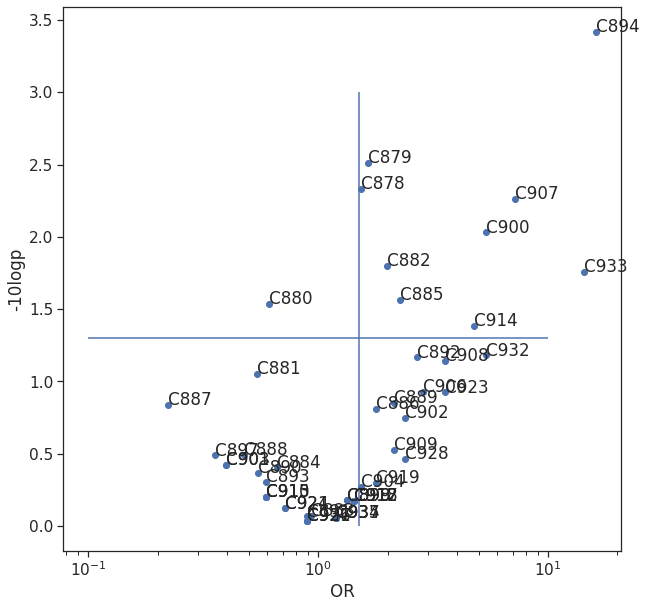

In [260]:

fig, ax = plt.subplots(figsize=(10,10))
plt.scatter(data=a, x="OR", y="-log10p")

for i, txt in enumerate(a.name):
    ax.annotate(txt, (a.OR[i], a["-log10p"][i]))
plt.xscale("log")
plt.hlines(1.3, 0.1, 10)
plt.vlines(1.5, 0, 3)
plt.xlabel("OR")
plt.ylabel("-10logp")

### C879 - neurotransmitter

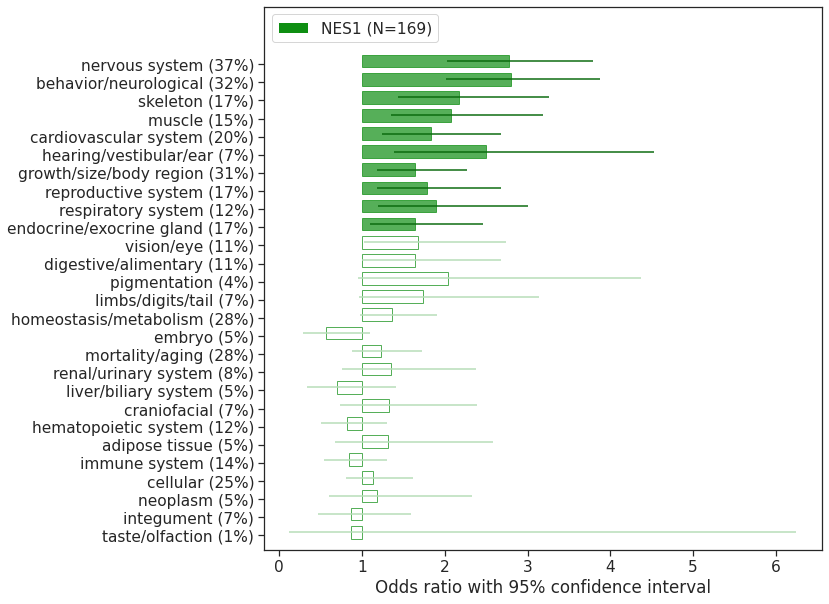

In [220]:
a = plot_hbar_comparison(results_old, communities=["C879"], mps=top_level, color_idx=0, vert = 10, 
                         sig_level=0.05, community_names=["NES1"], sort_by_q=True, label_number="percent_community")

Significant traits (q < 0.05):
                                    description          q_OR       q_hyper
MP:0003633  abnormal nervous system physiology  2.745829e-13  1.030797e-11
MP:0003632  abnormal nervous system morphology  3.856467e-04  2.609613e-04


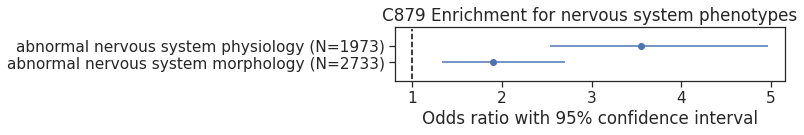

In [33]:
ns = plot_CIs(results_old, "MP:0003631", use_node="C879")


In [140]:
ns = plot_CIs(results_old, "MP:0003633", use_node="C879")


NameError: name 'plot_CIs' is not defined

Significant traits (q < 0.05):
                                            description      q_OR   q_hyper
MP:0002882                  abnormal neuron morphology  0.000009  0.000023
MP:0002752  abnormal somatic nervous system morphology  0.001186  0.001336
MP:0000955             abnormal spinal cord morphology  0.036554  0.020113


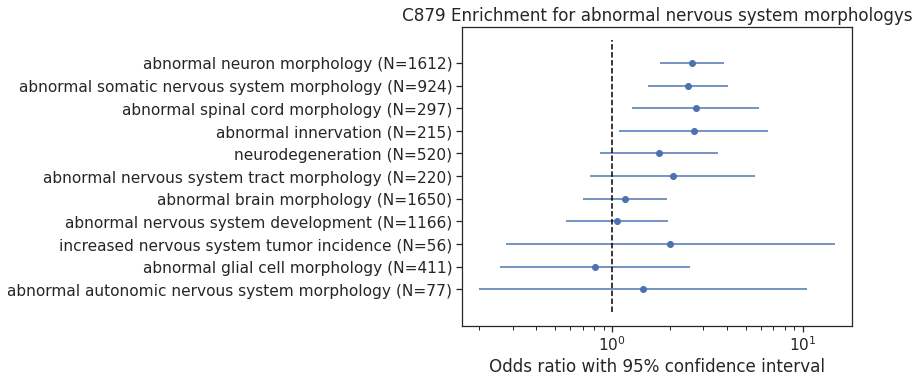

In [35]:
ns = plot_CIs(results_old, "MP:0003632", use_node="C879")


Significant traits (q < 0.05):
                                                   description          q_OR  \
MP:0002899                                            fatigue  7.536248e-08   
MP:0002066  abnormal motor capabilities/coordination/movement  3.839857e-07   
MP:0002557            abnormal social/conspecific interaction  4.962619e-05   
MP:0014114                                 abnormal cognition  6.478379e-05   
MP:0002067  abnormal sensory capabilities/reflexes/nocicep...  6.686954e-03   
MP:0002069                      abnormal consumption behavior  2.552487e-02   
MP:0002572                   abnormal emotion/affect behavior  2.656264e-02   

             q_hyper  
MP:0002899  0.000006  
MP:0002066  0.000003  
MP:0002557  0.000147  
MP:0014114  0.000147  
MP:0002067  0.004694  
MP:0002069  0.013634  
MP:0002572  0.013716  


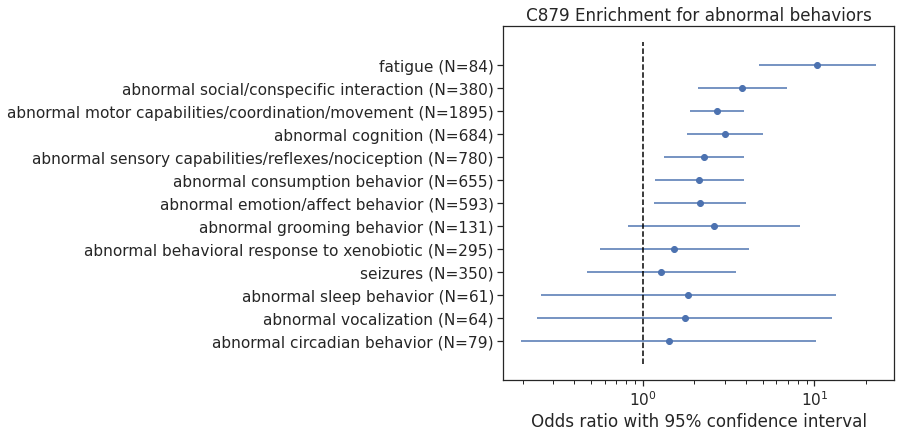

In [36]:
bh = plot_CIs(results_old, "MP:0004924", use_node="C879")

Significant traits (q < 0.05):
                            description      q_OR   q_hyper
MP:0001431    abnormal eating behavior  0.022149  0.009461
MP:0001422  abnormal drinking behavior  0.022366  0.009461


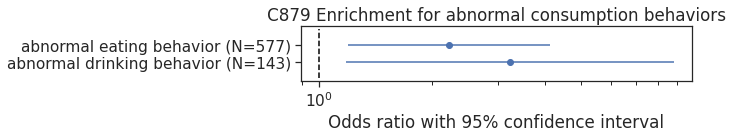

In [37]:
_ = plot_CIs(results_old, "MP:0002069", use_node="C879")

Significant traits (q < 0.05):
                                      description      q_OR   q_hyper
MP:0011956  abnormal compensatory feeding amount  0.003125  0.002899
MP:0005449                  abnormal food intake  0.026558  0.013869


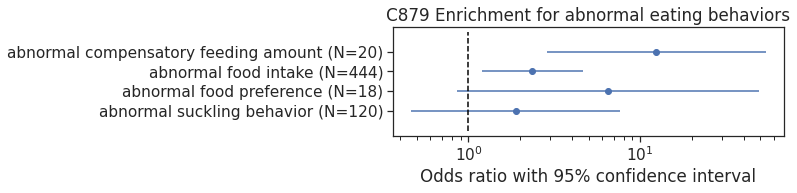

In [38]:
_ = plot_CIs(results_old, "MP:0001431", use_node="C879")

Significant traits (q < 0.05):
                                            description      q_OR   q_hyper
MP:0012719                    abnormal neck morphology  0.000729  0.001622
MP:0002089  abnormal postnatal growth/weight/body size  0.002609  0.001720
MP:0005451                   abnormal body composition  0.011265  0.006585
MP:0001270                           distended abdomen  0.038317  0.016789


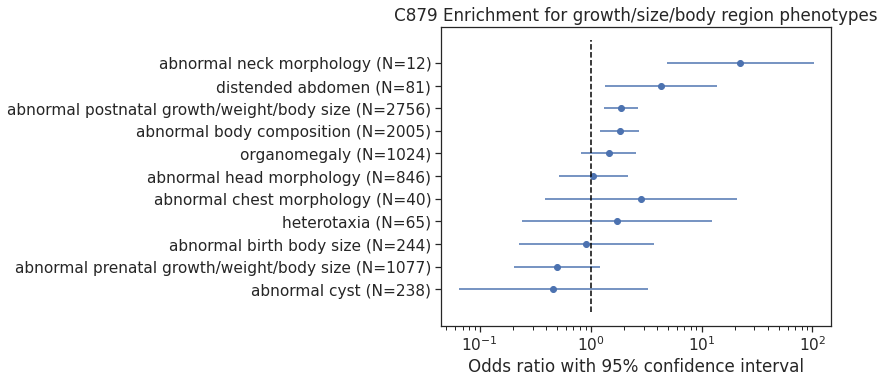

In [39]:
_ =plot_CIs(results_old, "MP:0005378", use_node="C879")

Significant traits (q < 0.05):
                           description      q_OR   q_hyper
MP:0003956         abnormal body size  0.001033  0.000730
MP:0001731  abnormal postnatal growth  0.034538  0.016561


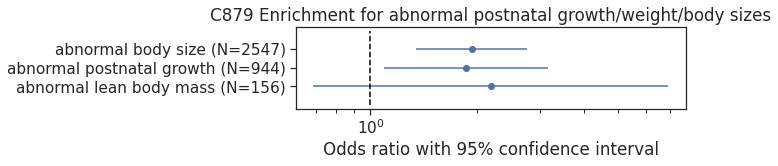

In [40]:
_ = plot_CIs(results_old, "MP:0002089", use_node="C879")

Significant traits (q < 0.05):
                            description      q_OR   q_hyper
MP:0012321  abnormal total tissue mass  0.007490  0.004682
MP:0012320      abnormal body fat mass  0.008466  0.005245


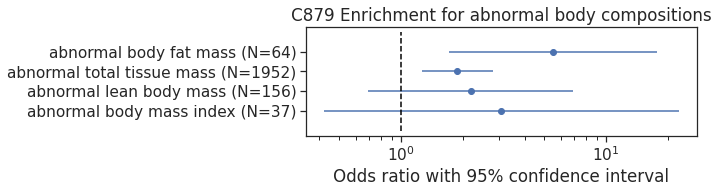

In [41]:
_ = plot_CIs(results_old, "MP:0005451", use_node="C879")

Significant traits (q < 0.05):
                              description      q_OR  q_hyper
MP:0005508  abnormal skeleton morphology  0.000324  0.00032


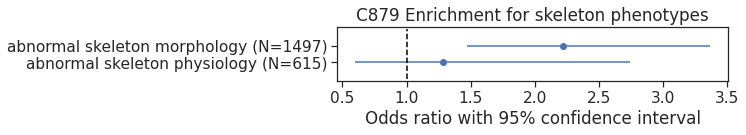

In [42]:
_ = plot_CIs(results_old, "MP:0005390", use_node="C879")

Significant traits (q < 0.05):
                                    description      q_OR   q_hyper
MP:0002114  abnormal axial skeleton morphology  0.003143  0.003096
MP:0030222                        hyperostosis  0.021421  0.005284
MP:0005503          abnormal tendon morphology  0.027262  0.011311


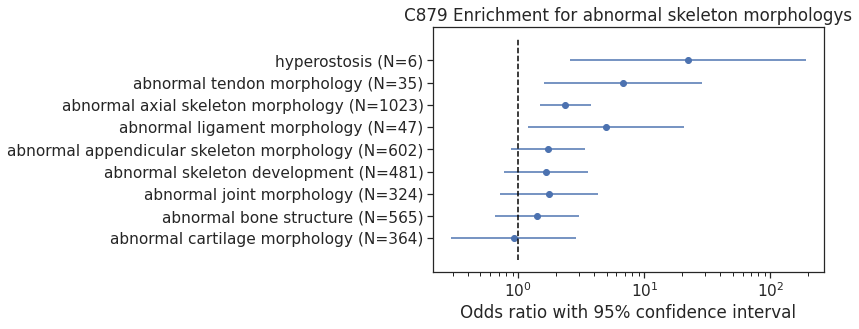

In [43]:
_ = plot_CIs(results_old, "MP:0005508", use_node="C879")

### C907 - calcium ion, muscle

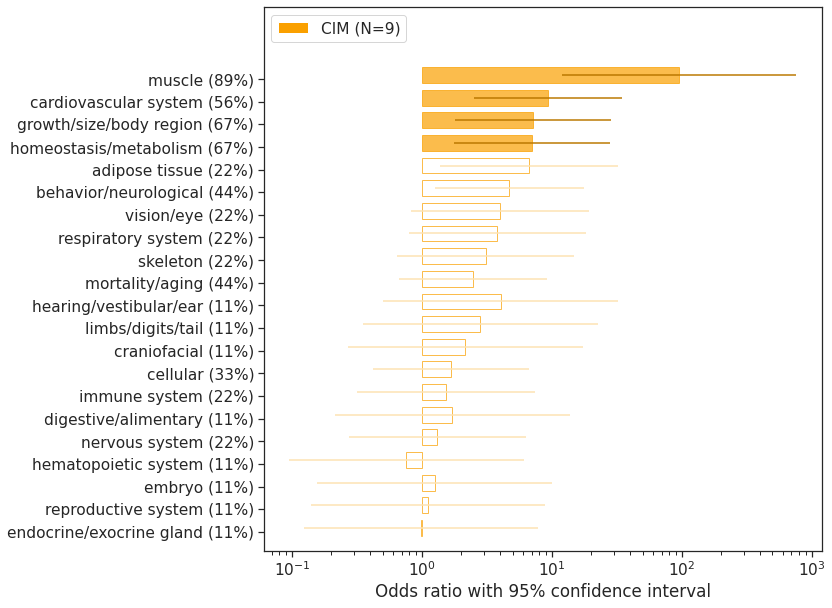

In [219]:
a = plot_hbar_comparison(results_old, communities=["C907"], mps=top_level, color_idx=2, vert = 10,
                         sig_level=0.05, community_names=["CIM"], sort_by_q=True, label_number="percent_community")

Significant traits (q < 0.05):
                                   description      q_OR       q_hyper
MP:0005369                   muscle phenotype  0.000365  2.127968e-09
MP:0005385    cardiovascular system phenotype  0.008950  1.705125e-03
MP:0005378  growth/size/body region phenotype  0.030154  3.167509e-03
MP:0005376   homeostasis/metabolism phenotype  0.030154  3.167509e-03


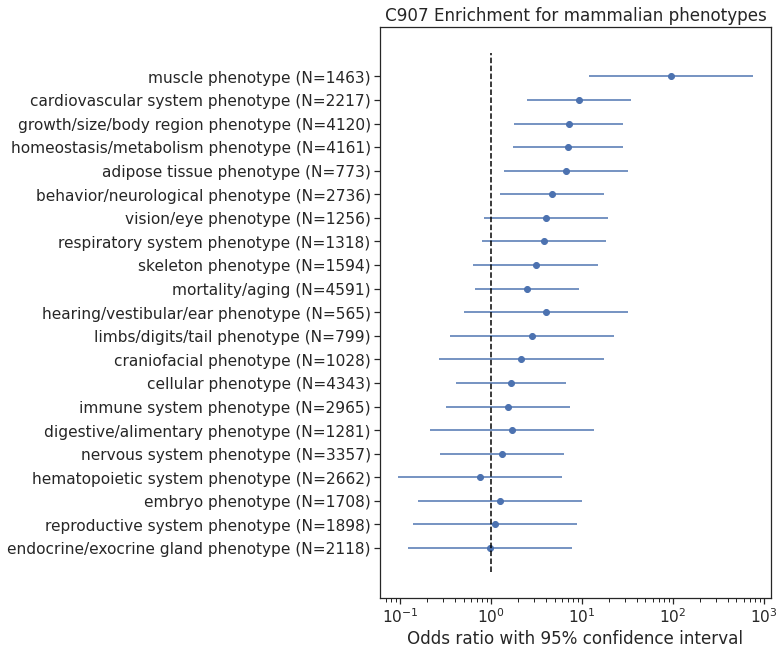

In [164]:
_ = plot_CIs(results_old, "MP:0000001", use_node="C907", plot_by="OR_p", ascending=False)

Significant traits (q < 0.05):
                            description          q_OR       q_hyper
MP:0002106  abnormal muscle physiology  3.579191e-07  3.675450e-10
MP:0002108  abnormal muscle morphology  3.747612e-06  1.086021e-11


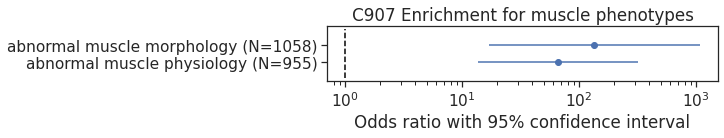

In [45]:
_ = plot_CIs(results_old, "MP:0005369", use_node="C907")

Significant traits (q < 0.05):
                                           description          q_OR  \
MP:0004087           abnormal muscle fiber morphology  1.733029e-09   
MP:0002269                           muscular atrophy  1.733029e-09   
MP:0000752                          dystrophic muscle  4.003485e-09   
MP:0000759        abnormal skeletal muscle morphology  8.355137e-09   
MP:0004233                     abnormal muscle weight  8.355137e-09   
MP:0010630  abnormal cardiac muscle tissue morphology  1.766019e-08   
MP:0000749                        muscle degeneration  2.872642e-08   
MP:0003199                           calcified muscle  6.971450e-07   
MP:0000733                abnormal muscle development  1.062992e-06   
MP:0003686             abnormal eye muscle morphology  2.133039e-06   

                 q_hyper  
MP:0004087  1.125424e-09  
MP:0002269  3.279423e-07  
MP:0000752  1.370340e-06  
MP:0000759  6.774037e-08  
MP:0004233  1.770545e-06  
MP:0010630  8.310576e-08

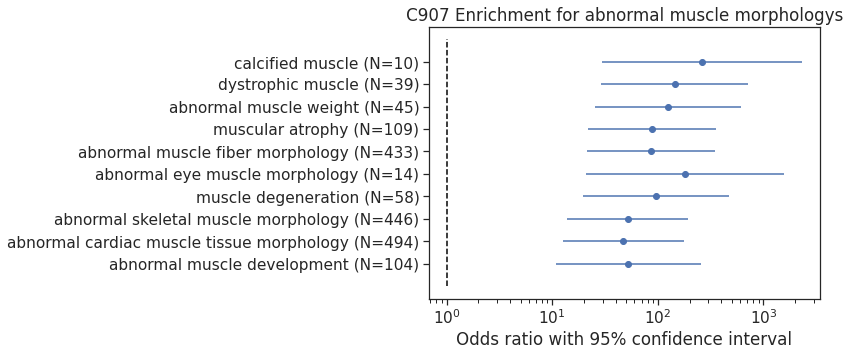

In [46]:
_ = plot_CIs(results_old, "MP:0002108", use_node="C907")

Significant traits (q < 0.05):
                                                   description          q_OR  \
MP:0009410  abnormal skeletal muscle satellite cell prolif...  1.648450e-12   
MP:0004510                                           myositis  2.591486e-10   
MP:0005620                      abnormal muscle contractility  6.981138e-09   
MP:0005330                                     cardiomyopathy  6.981138e-09   
MP:0000750                       abnormal muscle regeneration  1.980203e-07   
MP:0013467                                      diaphragmitis  2.522392e-07   
MP:0000747                                    muscle weakness  1.236323e-06   
MP:0012186          abnormal muscle precursor cell physiology  2.149938e-06   
MP:0003646                                     muscle fatigue  7.808814e-06   
MP:0004145                  abnormal muscle electrophysiology  8.645132e-05   
MP:0000751                                           myopathy  4.718759e-04   
MP:0003221          

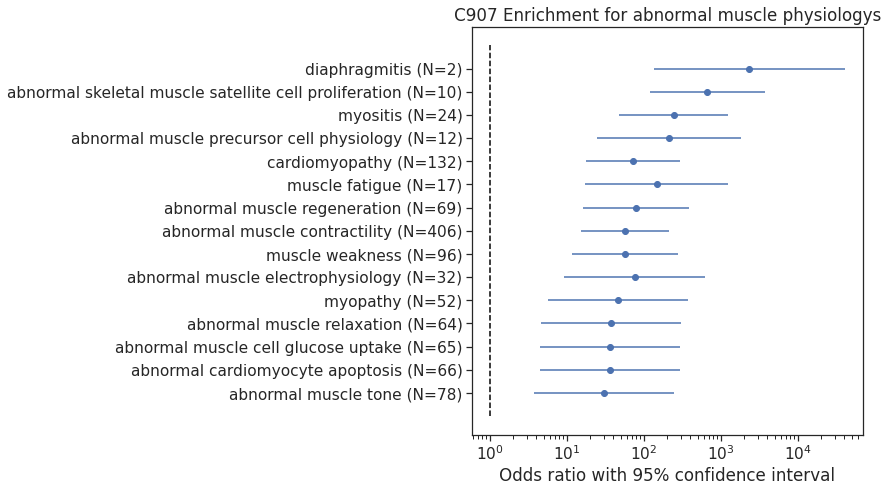

In [47]:
_ = plot_CIs(results_old, "MP:0002106", use_node="C907")

Significant traits (q < 0.05):
                                           description      q_OR   q_hyper
MP:0001544  abnormal cardiovascular system physiology  0.000147  0.000037
MP:0002127  abnormal cardiovascular system morphology  0.000167  0.000037


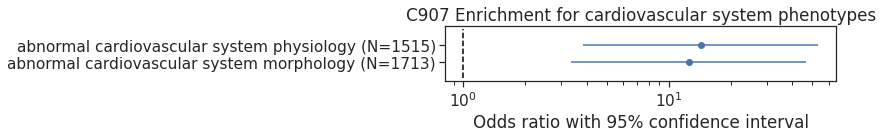

In [48]:
_ = plot_CIs(results_old, "MP:0005385", use_node="C907")

Significant traits (q < 0.05):
                                           description          q_OR  \
MP:0010630  abnormal cardiac muscle tissue morphology  3.178835e-08   
MP:0000266                  abnormal heart morphology  1.602242e-05   

                 q_hyper  
MP:0010630  7.479518e-08  
MP:0000266  5.603619e-06  


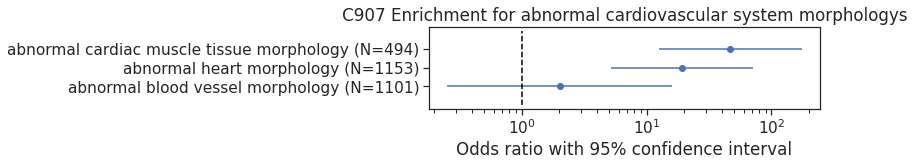

In [49]:
_ = plot_CIs(results_old, "MP:0002127", use_node="C907")

Significant traits (q < 0.05):
                                               description          q_OR  \
MP:0002972          abnormal cardiac muscle contractility  1.330015e-08   
MP:0005330                                 cardiomyopathy  1.330015e-08   
MP:0004215           abnormal myocardial fiber physiology  1.475936e-08   
MP:0004484   abnormal response of heart to induced stress  2.155534e-06   
MP:0004085                             abnormal heartbeat  2.383245e-04   
MP:0001853                             heart inflammation  2.532065e-04   
MP:0003137  abnormal impulse conducting system conduction  6.645965e-03   
MP:0002128                     abnormal blood circulation  1.323339e-02   

                 q_hyper  
MP:0002972  6.753210e-07  
MP:0005330  1.134027e-06  
MP:0004215  1.262817e-06  
MP:0004484  2.846655e-05  
MP:0004085  2.537590e-04  
MP:0001853  2.537590e-04  
MP:0003137  1.746442e-03  
MP:0002128  3.787082e-03  


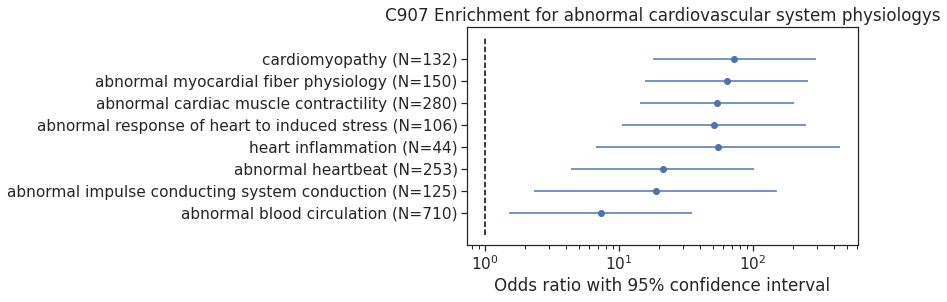

In [50]:
_ = plot_CIs(results_old, "MP:0001544", use_node="C907")

Significant traits (q < 0.05):
                                            description      q_OR   q_hyper
MP:0012719                    abnormal neck morphology  0.000006  0.000067
MP:0031094                                organomegaly  0.000217  0.000124
MP:0005451                   abnormal body composition  0.007559  0.001983
MP:0002089  abnormal postnatal growth/weight/body size  0.027109  0.006309


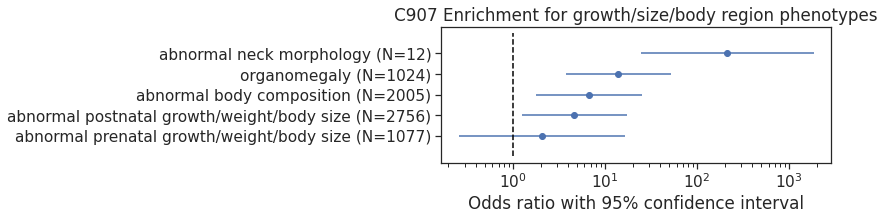

In [51]:
_= plot_CIs(results_old, "MP:0005378", use_node="C907")

Significant traits (q < 0.05):
                description          q_OR       q_hyper
MP:0000274  enlarged heart  6.436076e-08  4.495710e-07


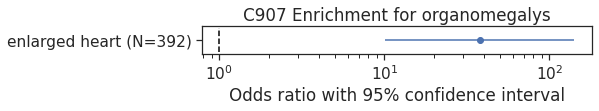

In [52]:
_= plot_CIs(results_old, "MP:0031094", use_node="C907")

Significant traits (q < 0.05):
                            description          q_OR   q_hyper
MP:0012320      abnormal body fat mass  1.187870e-07  0.000009
MP:0012321  abnormal total tissue mass  5.909456e-03  0.001577
MP:0003959     abnormal lean body mass  1.081406e-02  0.002366


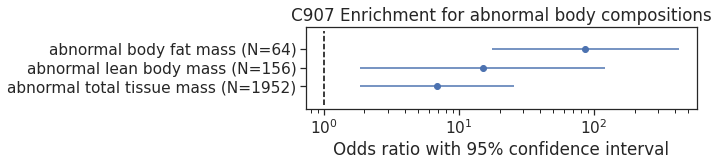

In [53]:
_ = plot_CIs(results_old, "MP:0005451", use_node="C907")

Significant traits (q < 0.05):
                           description      q_OR   q_hyper
MP:0003956         abnormal body size  0.022482  0.005318
MP:0003959    abnormal lean body mass  0.022482  0.005318
MP:0001731  abnormal postnatal growth  0.035201  0.008415


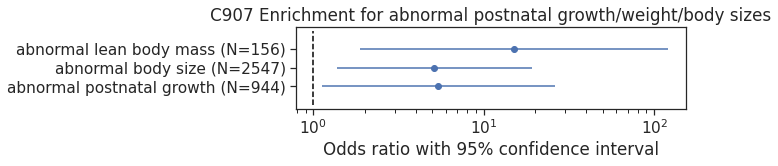

In [54]:
_ = plot_CIs(results_old, "MP:0002089", use_node="C907")

Significant traits (q < 0.05):
                                               description      q_OR   q_hyper
MP:0005164                    abnormal response to injury  0.000411  0.000411
MP:0008872  abnormal physiological response to xenobiotic  0.016574  0.005296
MP:0005266                            abnormal metabolism  0.034770  0.008714


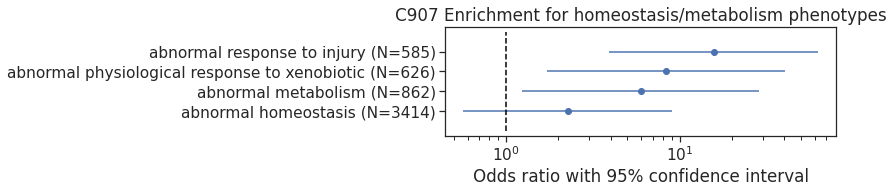

In [55]:
_ = plot_CIs(results_old, "MP:0005376", use_node="C907")

### C882 -demethylation

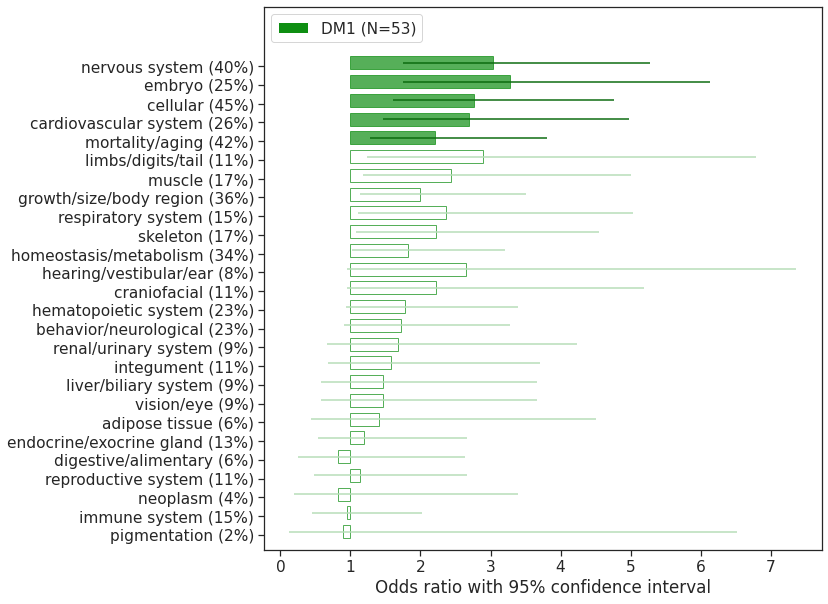

In [221]:
a = plot_hbar_comparison(results_old, communities=["C882"], mps=top_level, color_idx=0, vert=10,
                         sig_level=0.05, community_names=["DM1"], sort_by_q=True, label_number="percent_community")

Significant traits (q < 0.05):
                                 description      q_OR   q_hyper
MP:0003631         nervous system phenotype  0.001999  0.001253
MP:0005384               cellular phenotype  0.001999  0.001294
MP:0005380                 embryo phenotype  0.001999  0.001709
MP:0005385  cardiovascular system phenotype  0.009623  0.005733
MP:0010768                  mortality/aging  0.024076  0.009575


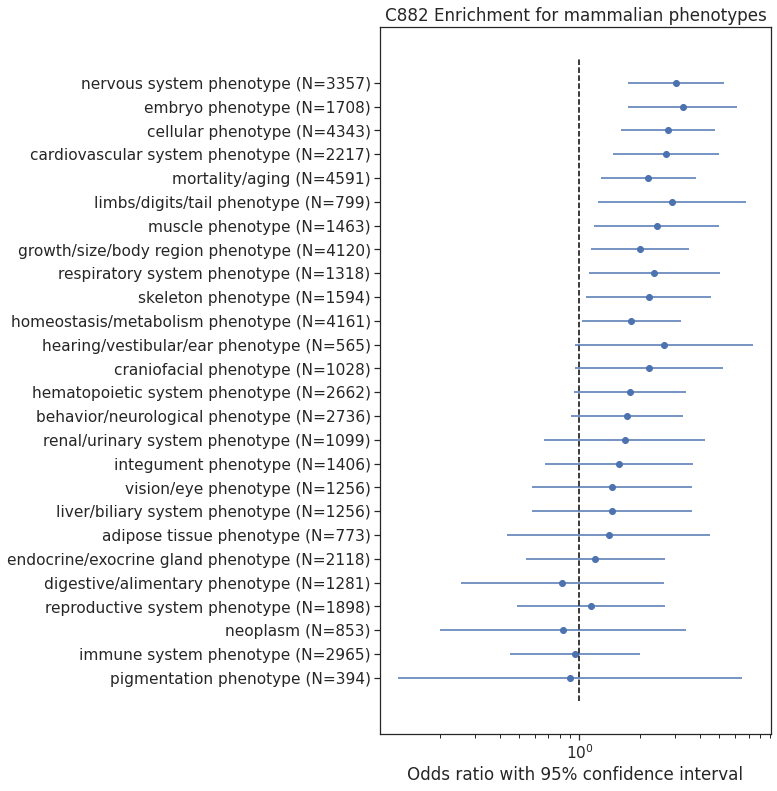

In [165]:
_ = plot_CIs(results_old, "MP:0000001", use_node="C882", plot_by="OR_p", ascending=False)

Significant traits (q < 0.05):
                          description      q_OR   q_hyper
MP:0005621  abnormal cell physiology  0.001285  0.000618


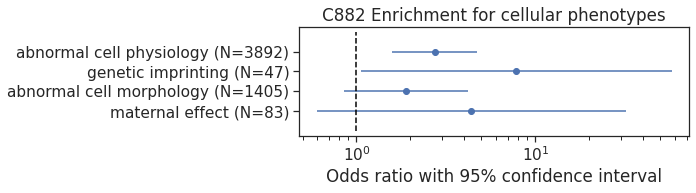

In [57]:
_ = plot_CIs(results_old, "MP:0005384", use_node="C882")

Significant traits (q < 0.05):
                                                   description      q_OR  \
MP:0005076                      abnormal cell differentiation  0.000079   
MP:0012167  abnormal epigenetic regulation of gene expression  0.038461   

             q_hyper  
MP:0005076  0.000324  
MP:0012167  0.019135  


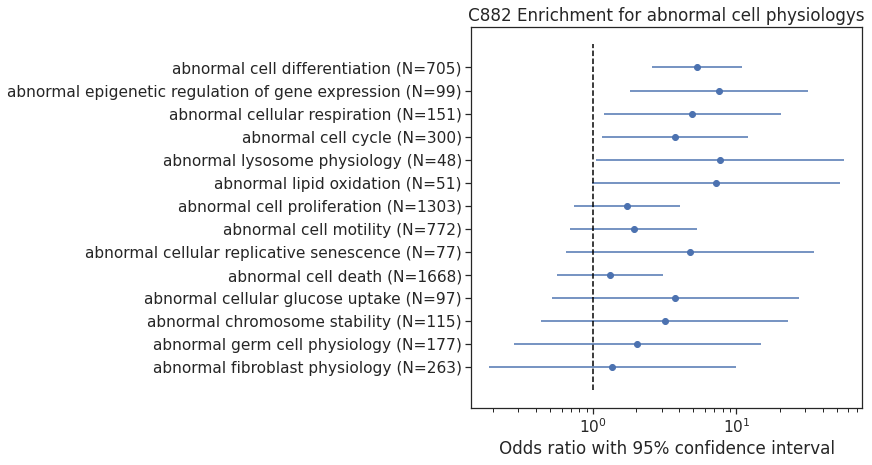

In [58]:
_ = plot_CIs(results_old, "MP:0005621", use_node="C882")

Significant traits (q < 0.05):
                                     description      q_OR   q_hyper
MP:0008395  abnormal osteoblast differentiation  0.000008  0.000095
MP:0009937      abnormal neuron differentiation  0.000248  0.000397


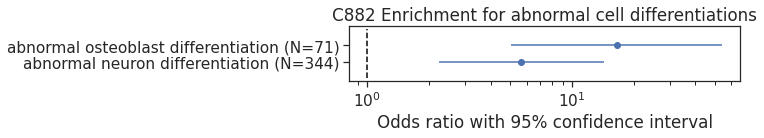

In [59]:
_=plot_CIs(results_old, "MP:0005076", use_node="C882")

Significant traits (q < 0.05):
                                    description      q_OR   q_hyper
MP:0003632  abnormal nervous system morphology  0.000262  0.000186
MP:0003633  abnormal nervous system physiology  0.005198  0.002691


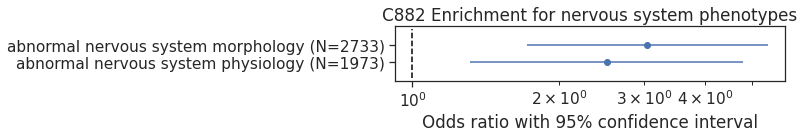

In [60]:
_=plot_CIs(results_old, "MP:0003631", use_node="C882")

Significant traits (q < 0.05):
                                        description      q_OR   q_hyper
MP:0001038  abnormal cholinergic neuron morphology  0.000015  0.000097
MP:0000937        abnormal motor neuron morphology  0.028087  0.005732
MP:0009538             abnormal synapse morphology  0.042345  0.007209


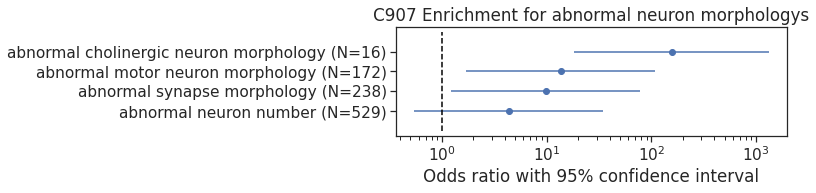

In [61]:
_= plot_CIs(results_old, "MP:0002882", use_node="C907")

Significant traits (q < 0.05):
                                     description      q_OR   q_hyper
MP:0003861  abnormal nervous system development  0.003974  0.003101
MP:0002152            abnormal brain morphology  0.004077  0.003101
MP:0002229                    neurodegeneration  0.020182  0.009907
MP:0005623         abnormal meninges morphology  0.020182  0.007582
MP:0002882           abnormal neuron morphology  0.022807  0.011155


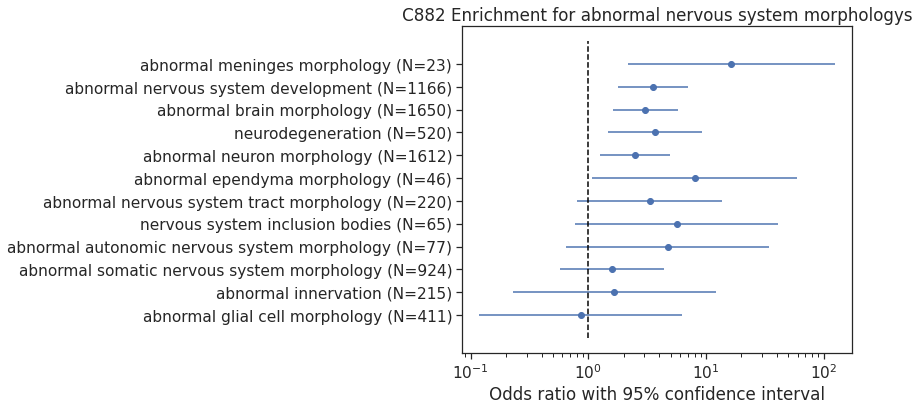

In [62]:
_ = plot_CIs(results_old, "MP:0003632", use_node="C882")

Significant traits (q < 0.05):
                                             description      q_OR   q_hyper
MP:0001908     abnormal somatosensory cortex physiology  0.000959  0.001043
MP:0003880  abnormal central pattern generator function  0.008397  0.003591
MP:0002634                 abnormal sensorimotor gating  0.011519  0.003871
MP:0012505              increased neural tube apoptosis  0.044185  0.009271


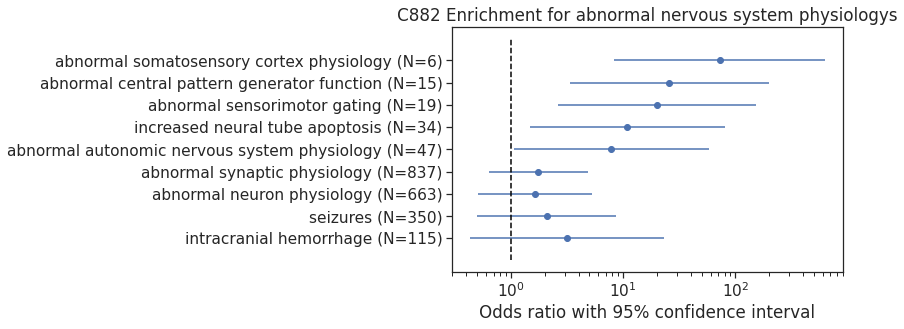

In [63]:
_ = plot_CIs(results_old, "MP:0003633", use_node="C882")

Significant traits (q < 0.05):
                                  description      q_OR   q_hyper
MP:0002151   abnormal neural tube morphology  0.000126  0.000357
MP:0009937   abnormal neuron differentiation  0.000495  0.000795
MP:0005657  abnormal neural plate morphology  0.018803  0.004291
MP:0000913        abnormal brain development  0.042096  0.015888


observed  total         OR      OR_p  OR_CI_lower  OR_CI_upper  \
MP:0000913       5.0  726.0   2.607201  0.042096     1.034823     6.568754   
MP:0005657       1.0   30.0  12.425729  0.014102     1.661639    92.919546   
MP:0009937       5.0  344.0   5.662488  0.000248     2.240224    14.312753   
MP:0002151       7.0  515.0   5.469574  0.000031     2.457543    12.173233   

             hyper_p  sig_5e6                       description  size  name  \
MP:0000913  0.015888    False        abnormal brain development  53.0  C882   
MP:0005657  0.003218    False  abnormal neural plate morphology  53.0  C882   
MP:0009937  0.000397    False   abnormal neuron differentiation  53.0  C882   
MP:0002151  0.000089    False   abnormal neural tube morphology  53.0  C882   

                q_OR   q_hyper  
MP:0000913  0.042096  0.015888  
MP:0005657  0.018803  0.004291  
MP:0009937  0.000495  0.000795  
MP:0002151  0.000126  0.000357

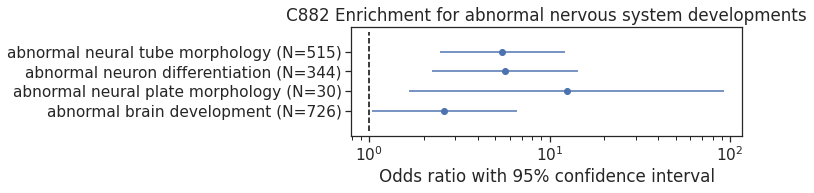

In [64]:
plot_CIs(results_old, "MP:0003861", use_node="C882")

Significant traits (q < 0.05):
                                       description     q_OR   q_hyper
MP:0004950  abnormal brain vasculature morphology  0.00427  0.005154


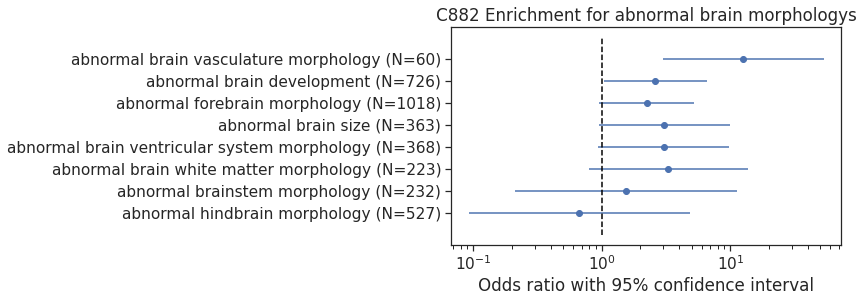

In [65]:
_ = plot_CIs(results_old, "MP:0002152", use_node="C882")

Significant traits (q < 0.05):
                                           description      q_OR   q_hyper
MP:0004196  abnormal prenatal growth/weight/body size  0.000124  0.000279


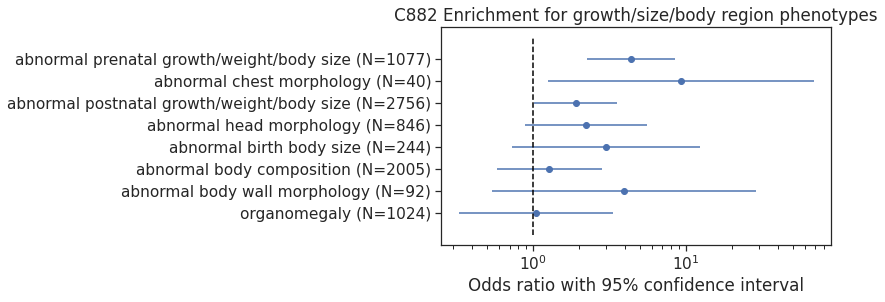

In [66]:
_ = plot_CIs(results_old, "MP:0005378", use_node="C882")

Significant traits (q < 0.05):
                                            description          q_OR   q_hyper
MP:0010866                 abnormal prenatal body size  4.575694e-07  0.000006
MP:0002088  abnormal embryonic growth/weight/body size  1.426531e-03  0.001335
MP:0010865                 prenatal growth retardation  2.474184e-03  0.001933
MP:0004197      abnormal fetal growth/weight/body size  2.788669e-02  0.010157


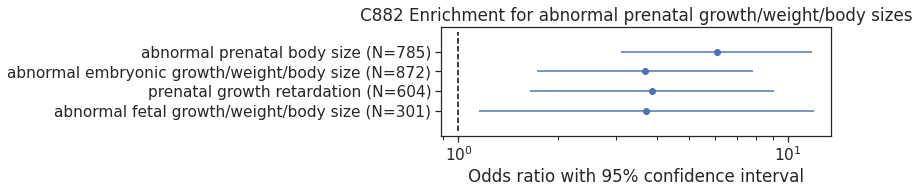

In [67]:
_ = plot_CIs(results_old, "MP:0004196", use_node="C882")

Significant traits (q < 0.05):
 Empty DataFrame
Columns: [description, q_OR, q_hyper]
Index: []


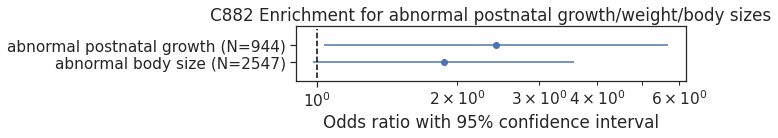

In [68]:
_ = plot_CIs(results_old, "MP:0002089", use_node="C882")

Significant traits (q < 0.05):
 Empty DataFrame
Columns: [description, q_OR, q_hyper]
Index: []


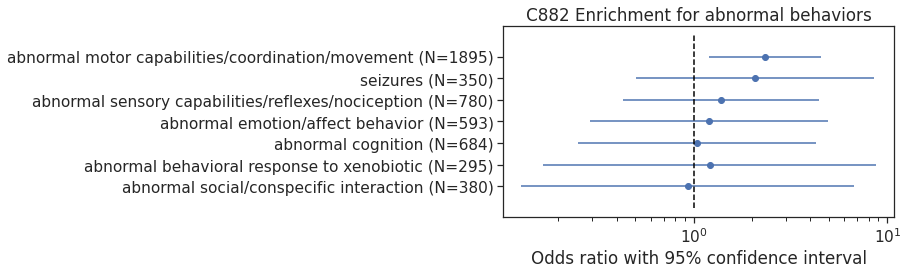

In [69]:
_ = plot_CIs(results_old, "MP:0004924", use_node="C882")

Significant traits (q < 0.05):
                                           description      q_OR   q_hyper
MP:0002086  abnormal extraembryonic tissue morphology  0.000025  0.000106
MP:0004264  abnormal extraembryonic tissue physiology  0.000306  0.000618
MP:0001672                abnormal embryo development  0.000573  0.000618
MP:0014134                 abnormal embryo morphology  0.000930  0.000771


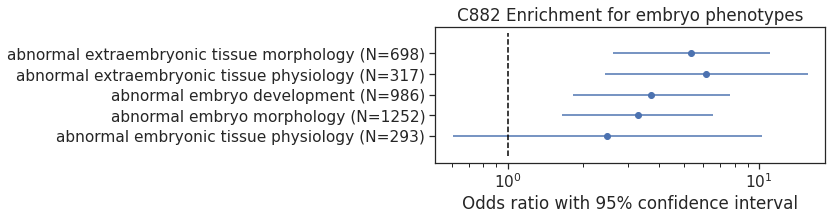

In [70]:
_ = plot_CIs(results_old, "MP:0005380", use_node="C882")

Significant traits (q < 0.05):
                                   description      q_OR   q_hyper
MP:0003984       embryonic growth retardation  0.001278  0.001581
MP:0002084  abnormal developmental patterning  0.002440  0.002048


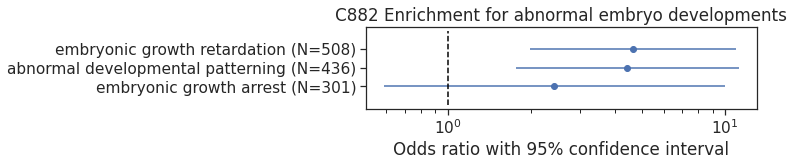

In [71]:
_ = plot_CIs(results_old, "MP:0001672", use_node="C882")

### C885 - cell fate regulation

Significant traits (q < 0.05):
                                description      q_OR   q_hyper
MP:0005390              skeleton phenotype  0.000052  0.000104
MP:0005388    respiratory system phenotype  0.000243  0.000405
MP:0005382          craniofacial phenotype  0.001312  0.001694
MP:0005371     limbs/digits/tail phenotype  0.001312  0.001694
MP:0010768                 mortality/aging  0.015459  0.005047
MP:0005381  digestive/alimentary phenotype  0.038239  0.017854


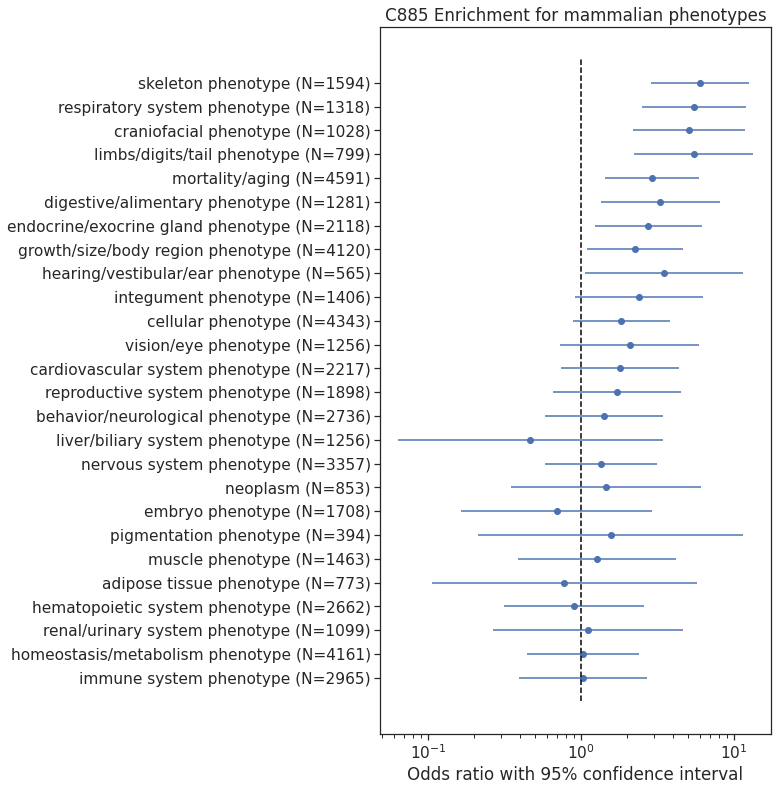

In [166]:
_ = plot_CIs(results_old, "MP:0000001", use_node="C885", plot_by="OR_p", ascending=False)

Significant traits (q < 0.05):
                                description      q_OR   q_hyper
MP:0005390              skeleton phenotype  0.000052  0.000104
MP:0005388    respiratory system phenotype  0.000243  0.000405
MP:0005371     limbs/digits/tail phenotype  0.001312  0.001694
MP:0005382          craniofacial phenotype  0.001312  0.001694
MP:0010768                 mortality/aging  0.015459  0.005047
MP:0005381  digestive/alimentary phenotype  0.038239  0.017854


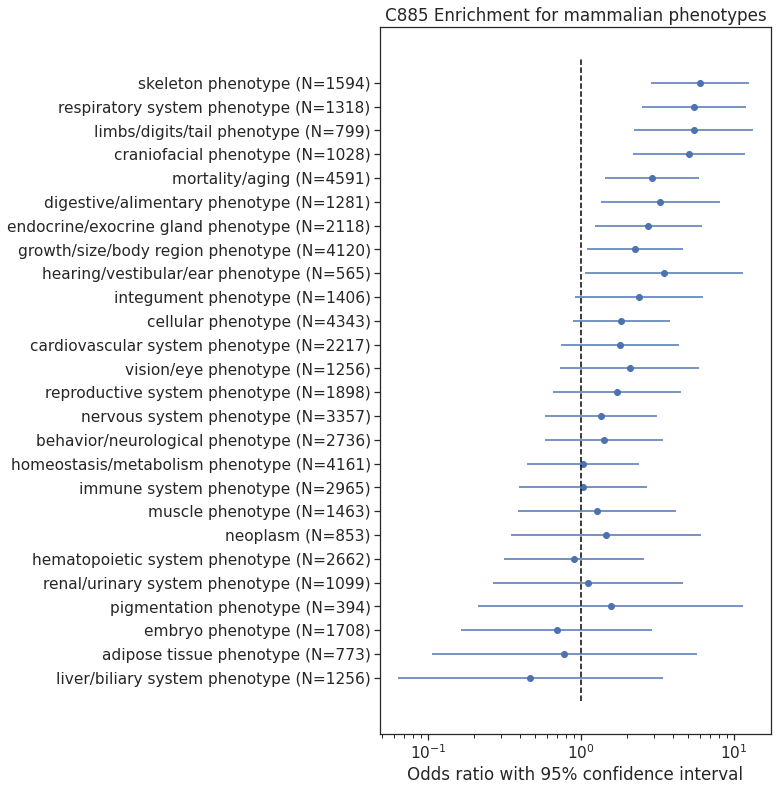

In [73]:
_ = plot_CIs(results_old, "MP:0000001", use_node="C885")

Significant traits (q < 0.05):
                           description      q_OR   q_hyper
MP:0001270          distended abdomen  0.001434  0.002848
MP:0000432   abnormal head morphology  0.017672  0.006823
MP:0004134  abnormal chest morphology  0.021068  0.006823
MP:0009701   abnormal birth body size  0.041933  0.013324
MP:0031310              abnormal cyst  0.041933  0.013324


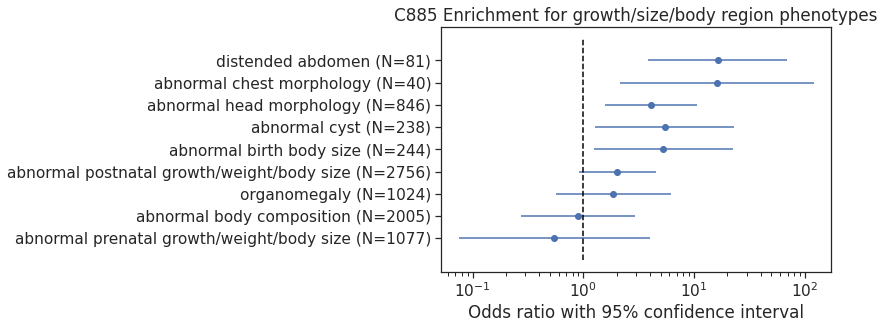

In [74]:
_ = plot_CIs(results_old, "MP:0005378", use_node="C885")

Significant traits (q < 0.05):
 Empty DataFrame
Columns: [description, q_OR, q_hyper]
Index: []


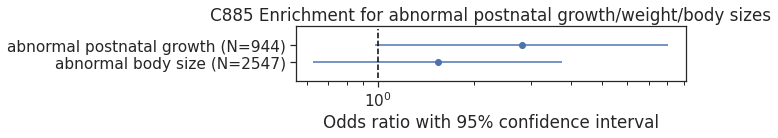

In [75]:
_ = plot_CIs(results_old, "MP:0002089", use_node="C885")

Significant traits (q < 0.05):
                                           description      q_OR   q_hyper
MP:0002114         abnormal axial skeleton morphology  0.000080  0.000190
MP:0009250  abnormal appendicular skeleton morphology  0.001081  0.001360
MP:0002113              abnormal skeleton development  0.002864  0.002445
MP:0005503                 abnormal tendon morphology  0.008292  0.002643


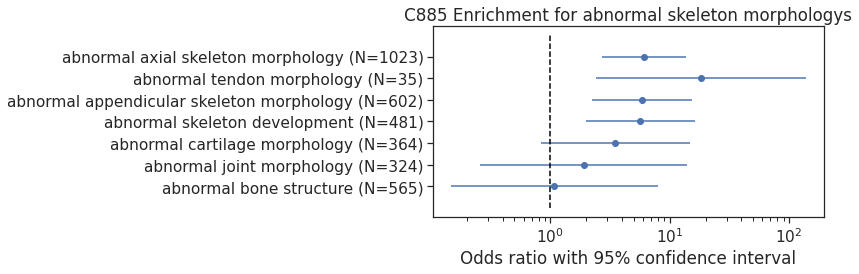

In [76]:
_ = plot_CIs(results_old, "MP:0005508", use_node="C885")

Significant traits (q < 0.05):
                           description      q_OR   q_hyper
MP:0002163  abnormal gland morphology  0.013123  0.006052


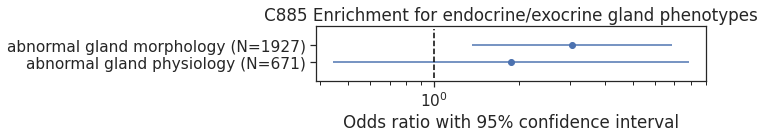

In [77]:
_ = plot_CIs(results_old, "MP:0005379", use_node="C885")

Significant traits (q < 0.05):
                               description      q_OR   q_hyper
MP:0020973     abnormal gland development  0.002699  0.002973
MP:0000653  abnormal sex gland morphology  0.008506  0.004825


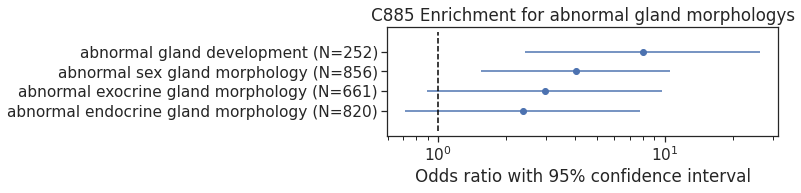

In [78]:
_ = plot_CIs(results_old, "MP:0002163", use_node="C885")

Significant traits (q < 0.05):
 Empty DataFrame
Columns: [description, q_OR, q_hyper]
Index: []


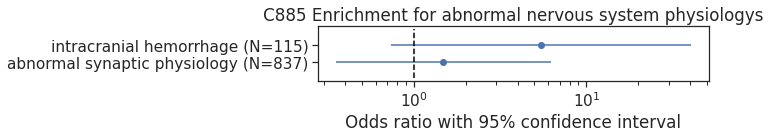

In [79]:
_ = plot_CIs(results_old, "MP:0003633", use_node="C885")

Significant traits (q < 0.05):
 Empty DataFrame
Columns: [description, q_OR, q_hyper]
Index: []


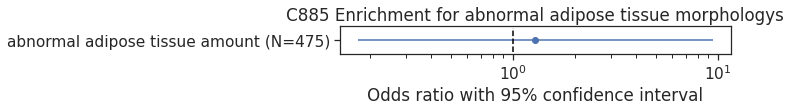

In [80]:
_ = plot_CIs(results_old, "MP:0000003", use_node="C885")

In [81]:
results_old.to_csv("full_enrichment_results.tsv", sep="\t")

In [82]:
for node in nx.dfs_preorder_nodes(mp_graph, "MP:0000001", 1):
    print(node)

MP:0000001
MP:0001186
MP:0002006
MP:0002873
MP:0003012
MP:0003631
MP:0005367
MP:0005369
MP:0005370
MP:0005371
MP:0005375
MP:0005376
MP:0005377
MP:0005378
MP:0005379
MP:0005380
MP:0005381
MP:0005382
MP:0005384
MP:0005385
MP:0005386
MP:0005387
MP:0005388
MP:0005389
MP:0005390
MP:0005391
MP:0005394
MP:0005397
MP:0010768
MP:0010771


### C884 - neurotransmitter 2

Significant traits (q < 0.05):
 Empty DataFrame
Columns: [description, q_OR, q_hyper]
Index: []


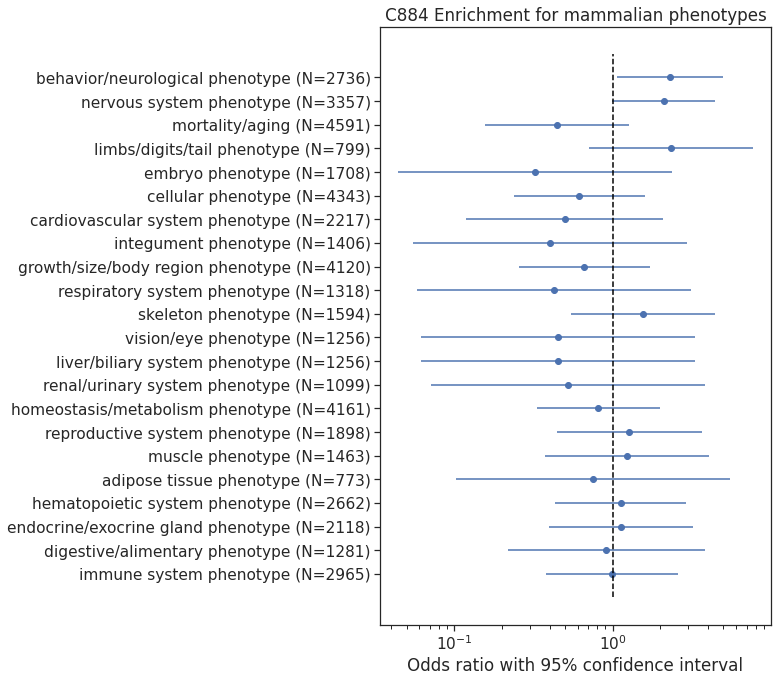

In [167]:
_ = plot_CIs(results_old, "MP:0000001", use_node="C884", plot_by="OR_p", ascending=False)

Significant traits (q < 0.05):
                                    description      q_OR   q_hyper
MP:0003633  abnormal nervous system physiology  0.000745  0.000521


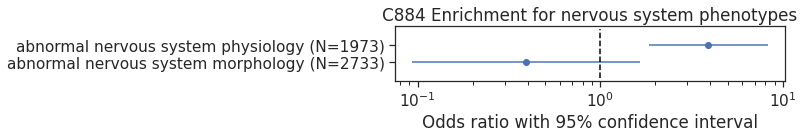

In [84]:
_ = plot_CIs(results_old, "MP:0003631", use_node="C884")

Significant traits (q < 0.05):
                                          description      q_OR   q_hyper
MP:0021009              abnormal synaptic physiology  0.002835  0.002981
MP:0013570  abnormal neuroendocrine gland physiology  0.012642  0.004420
MP:0006082                          CNS inflammation  0.045187  0.009504


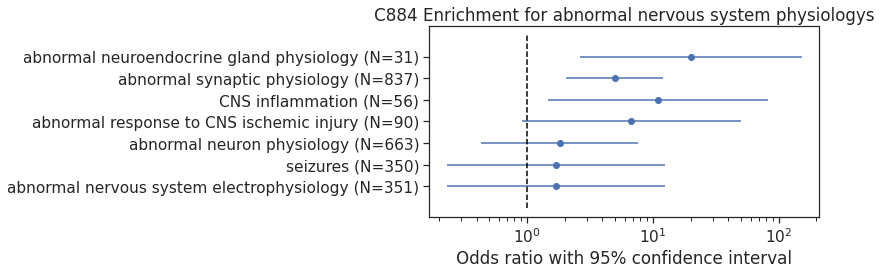

In [85]:
_ = plot_CIs(results_old, "MP:0003633", use_node="C884")

Significant traits (q < 0.05):
 Empty DataFrame
Columns: [description, q_OR, q_hyper]
Index: []


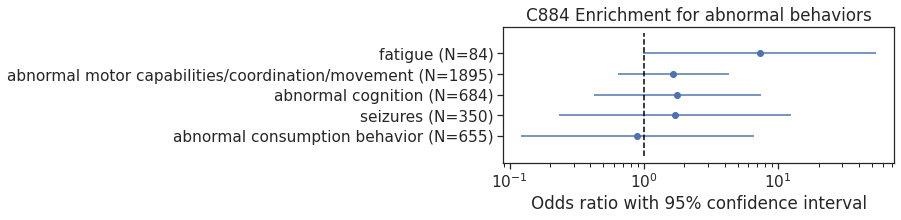

In [86]:
_ = plot_CIs(results_old, "MP:0004924", use_node="C884")

Significant traits (q < 0.05):
 Empty DataFrame
Columns: [description, q_OR, q_hyper]
Index: []


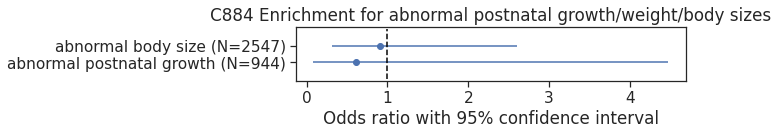

In [87]:
_ = plot_CIs(results_old, "MP:0002089", use_node="C884")

### C887

Significant traits (q < 0.05):
 Empty DataFrame
Columns: [description, q_OR, q_hyper]
Index: []


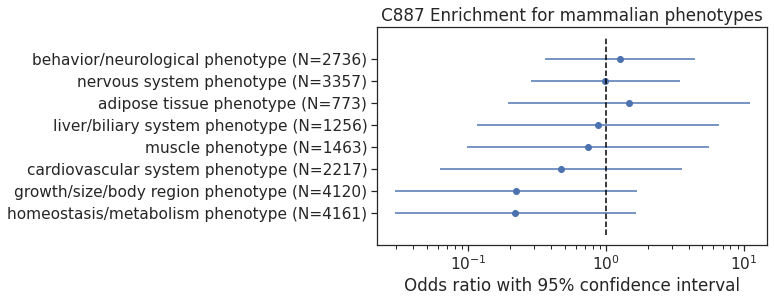

In [88]:
x = plot_CIs(results_old, "MP:0000001", use_node="C887")

Significant traits (q < 0.05):
                                                   description      q_OR  \
MP:0020374                      abnormal nocifensive behavior  0.000005   
MP:0002067  abnormal sensory capabilities/reflexes/nocicep...  0.035556   

             q_hyper  
MP:0020374  0.000005  
MP:0002067  0.013571  


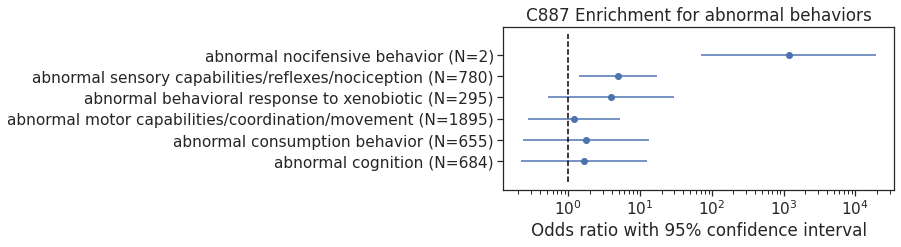

In [89]:
_ = plot_CIs(results_old, "MP:0004924", use_node="C887")

Significant traits (q < 0.05):
 Empty DataFrame
Columns: [description, q_OR, q_hyper]
Index: []


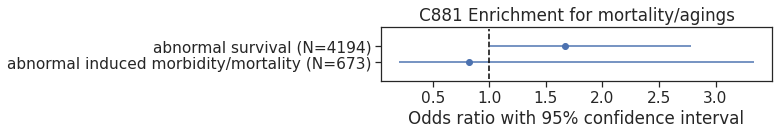

In [90]:
_ = plot_CIs(results_old, "MP:0010768", use_node="C881")

### C894

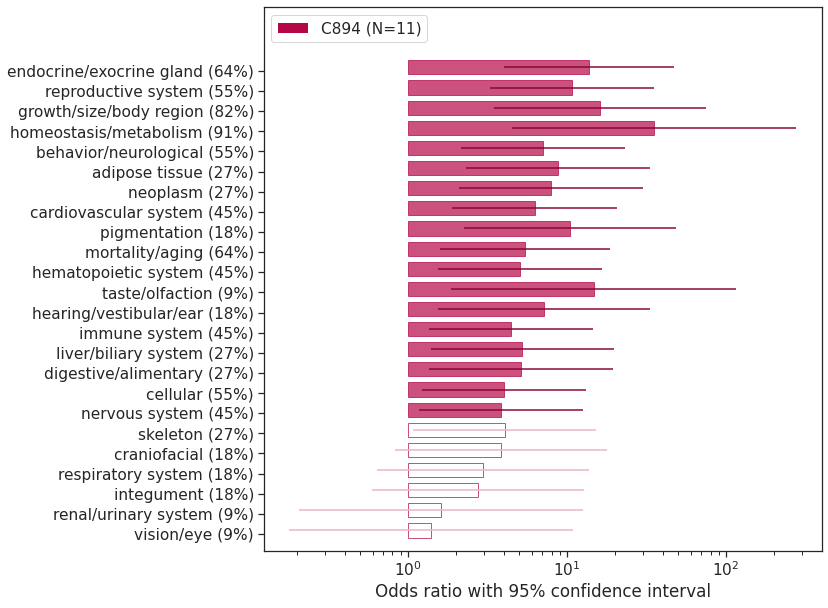

In [222]:
a = plot_hbar_comparison(results_old, communities=["C894"], mps=top_level, color_idx=3, vert=10,
                         sig_level=0.05, community_names=["C894"], sort_by_q=True, label_number="percent_community")

Significant traits (q < 0.05):
                                            description      q_OR       q_hyper
MP:0005451                   abnormal body composition  0.000072  5.023345e-06
MP:0002089  abnormal postnatal growth/weight/body size  0.000072  2.133339e-07
MP:0031094                                organomegaly  0.009364  3.521006e-03


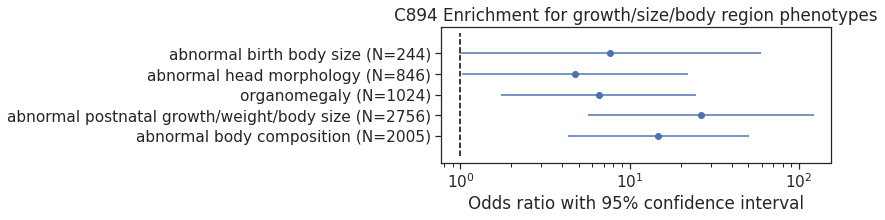

In [505]:
_ = plot_CIs(results_old, "MP:0005378", use_node="C894")

Significant traits (q < 0.05):
                    description      q_OR   q_hyper
MP:0005384  cellular phenotype  0.021409  0.003150
MP:0010768     mortality/aging  0.048458  0.015949
MP:0005380    embryo phenotype  0.048458  0.015949


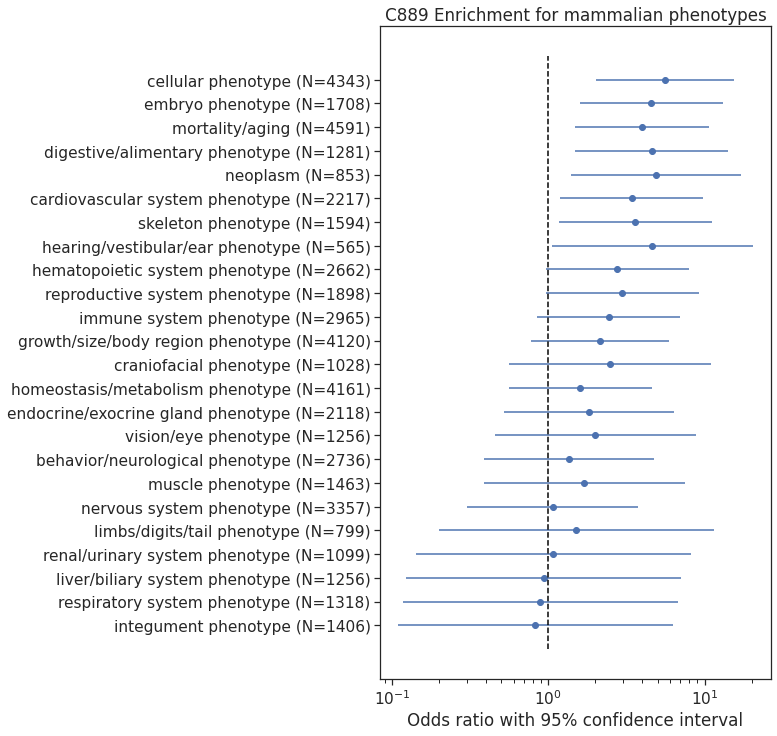

In [93]:
_ = plot_CIs(results_old, "MP:000", use_node="C894")

# Plot given set of MPs

### Bar version

In [807]:
   
def plot_specific_CIs_bar(results, mp_list, n_test, mp_graph=mp_graph, use_node="C877", sort=False):
    top_level = [node for node in mp_list if (node in results.loc[results.name==use_node].index)]
    to_plot= results.loc[results.name==use_node].loc[top_level]
    colors = ["blue" for _ in range(n_test)] + ["orange" for _ in range(len(top_level)-n_test)]
    to_plot["c"] = colors
    n_tests = len(mp_list)
    if len(to_plot) < n_tests:
        diff = n_tests = len(to_plot)
        to_plot["q_OR"] = fdrcorrection(list(to_plot["OR_p"]) + [1 for _ in range(diff)], method="poscorr")[1][1:(-1*diff)]
    else:
        to_plot["q_OR"] = fdrcorrection(to_plot["OR_p"], method="poscorr")[1]
    if sort:
        to_plot = to_plot.sort_values(by="OR_CI_lower")
    plt.figure(figsize=[7,len(to_plot)/3+0.1])
    
    to_plot["facecolor"] = to_plot.apply(lambda x: x["c"] if x["q_OR"] < 0.05 else "white", axis=1)
    
    ax = plt.barh(width=to_plot.OR-1, y=[i for i in range(len(to_plot))], color=to_plot["facecolor"], alpha=0.7, left=1,
                 edgecolor=to_plot["c"])
    
    sigs = to_plot.loc[to_plot["q_OR"] < 0.05].index
    not_sigs = to_plot.loc[to_plot["q_OR"] >= 0.05].index
    plt.hlines([i for i in range(len(to_plot)) if to_plot.iloc[i]["q_OR"] < 0.05], to_plot.loc[sigs].OR_CI_lower, 
               to_plot.loc[sigs].OR_CI_upper, colors="dark"+to_plot.loc[sigs]["c"], alpha=1)
    plt.hlines([i for i in range(len(to_plot)) if to_plot.iloc[i]["q_OR"] >= 0.05], to_plot.loc[not_sigs].OR_CI_lower, 
               to_plot.loc[not_sigs].OR_CI_upper, colors=to_plot.loc[not_sigs]["c"], alpha=0.5)

    plt.vlines(1.0, -1, len(to_plot), linestyles='dashed', colors='black', alpha=0.5, lw=0.5)
    ylabels = [to_plot.loc[node, "description"] + " (" + str(int(to_plot.loc[node, "total"]))+")" for node in to_plot.index]
    ylabels = [desc.split("abnormal ")[1] if ("abnormal" in desc) else desc for desc in ylabels]
    ylabels = [desc.replace("physiology", "phys.") for desc in ylabels]
    ylabels = [desc.replace("morphology", "morph.") for desc in ylabels]
    ylabels = [desc.replace(" phenotype", "") for desc in ylabels]
    a=plt.yticks(ticks=[i for i in range(len(to_plot))], labels=ylabels)
    if max(to_plot.OR_CI_upper) > 5:
        plt.xscale('log')    
    plt.xlabel("Odds ratio with 95% confidence interval")
    try:
        desc = results.loc[root, "description"].unique()[0]
    except AttributeError:
        desc = results.loc[root, "description"]
    plt.title("Enrichment for " + desc+"s")
    print("Significant enrichments (q < 0.05):\n", to_plot.sort_values(by="q_OR").loc[to_plot.q_OR <= 0.05, ("description", "q_OR", "OR_p")])
    return to_plot

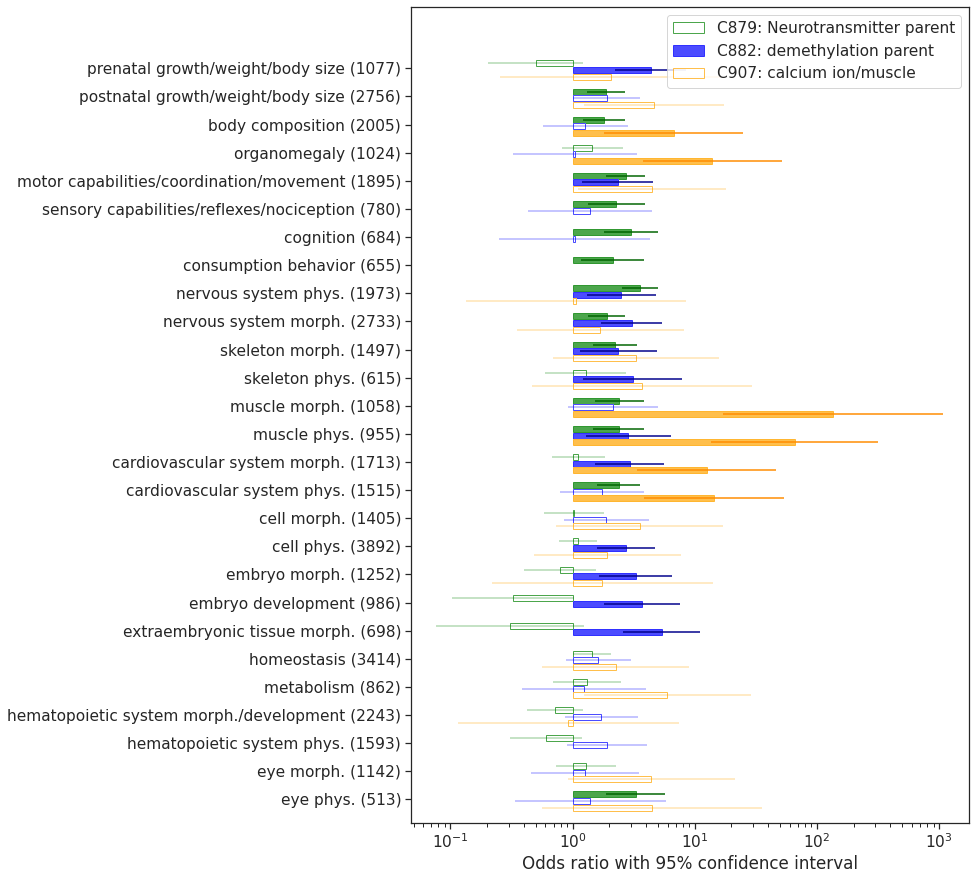

In [193]:
plot_hbar_comparison(results_old, ["C879", "C882", "C907"], colors=["green", "blue", "orange", "red"], mps=mps, errorbars='all',
                   community_names = ["Neurotransmitter parent", "demethylation parent", "calcium ion/muscle"])
# be clear about rules for choosing communities (top 3, size rule)
# add a hierarchy on the side showing parent terms
# re-order terms

### Updated MP set

In [224]:
mps2 = ["MP:0004196", "MP:0002089", "MP:0005451", "MP:0031094", "MP:0002066", "MP:0002067", "MP:0014114", "MP:0002069", 
       "MP:0003633", "MP:0003632",  "MP:0005508", "MP:0001533", "MP:0002108", "MP:0002106", "MP:0002127", "MP:0001544",
       "MP:0000358", "MP:0005621", "MP:0014134", "MP:0001672", "MP:0002086", "MP:0002396", 
       "MP:0001545", "MP:0002092", "MP:0005253"]
select_mp_groups = [0,0,0,0,1,1,1,1,0,0,1,1,0,0,1,1,0,0,1,1,1,0,0,1,1]

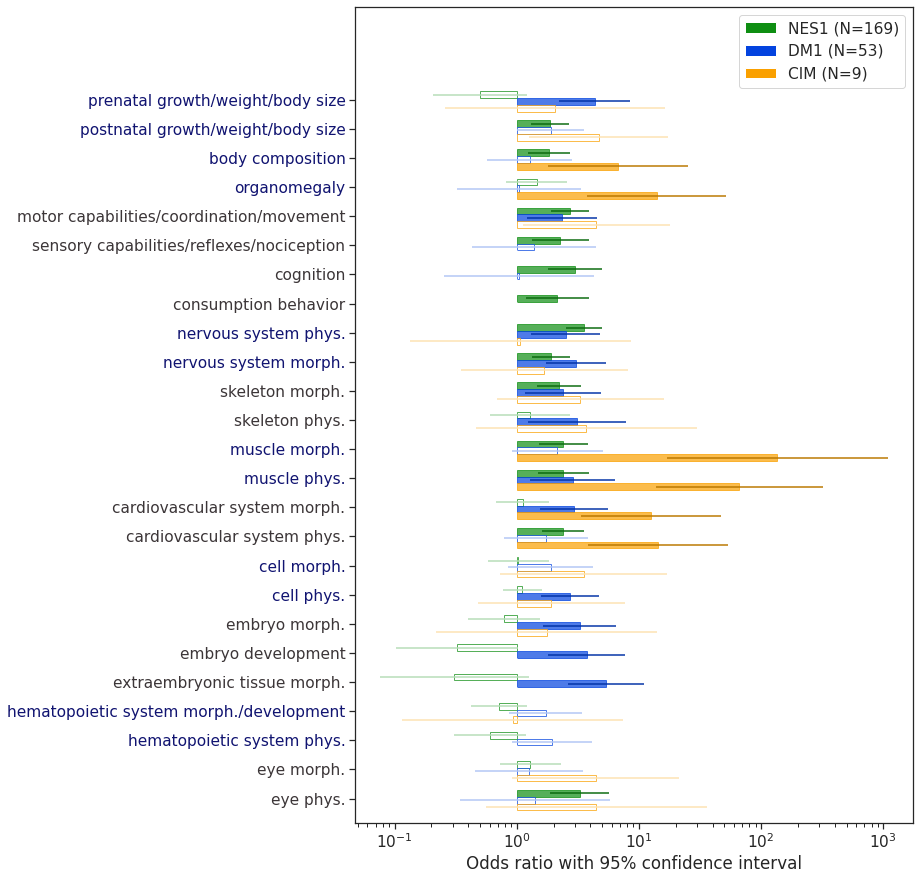

In [233]:
x, ax = plot_hbar_comparison(results_old, communities=["C879","C882", "C907"], mps=mps2, sig_level=0.05, 
                         community_names=["NES1","DM1", "CIM"], sort_by_q=False, label_number=None, vert=15)
colors = {0:"#111471", 1:"#3C3638"}
for ytick, color in zip(ax.get_yticklabels(), select_mp_groups):
    ytick.set_color(colors[color])

In [251]:

mps3 = ["MP:0004196", "MP:0002089", "MP:0005451", "MP:0031094", "MP:0002066", "MP:0002067", "MP:0014114", "MP:0002069", 
       "MP:0003633", "MP:0003632",  "MP:0005508", "MP:0001533", "MP:0002108", "MP:0002106", "MP:0002127", "MP:0001544",
       "MP:0000358", "MP:0005621", "MP:0014134", "MP:0001672", "MP:0002086", "MP:0002163", "MP:0002164", "MP:0002160", "MP:0001919", 
        "MP:0001764", "MP:0005266", "MP:0008872","MP:0002396", 
       "MP:0001545", "MP:0002092", "MP:0005253" ]
select_mp_groups = [0,0,0,0,1,1,1,1,0,0,1,1,0,0,1,1,0,0,1,1,1,0,0,1,1,0,0,0,1,1,0,0]

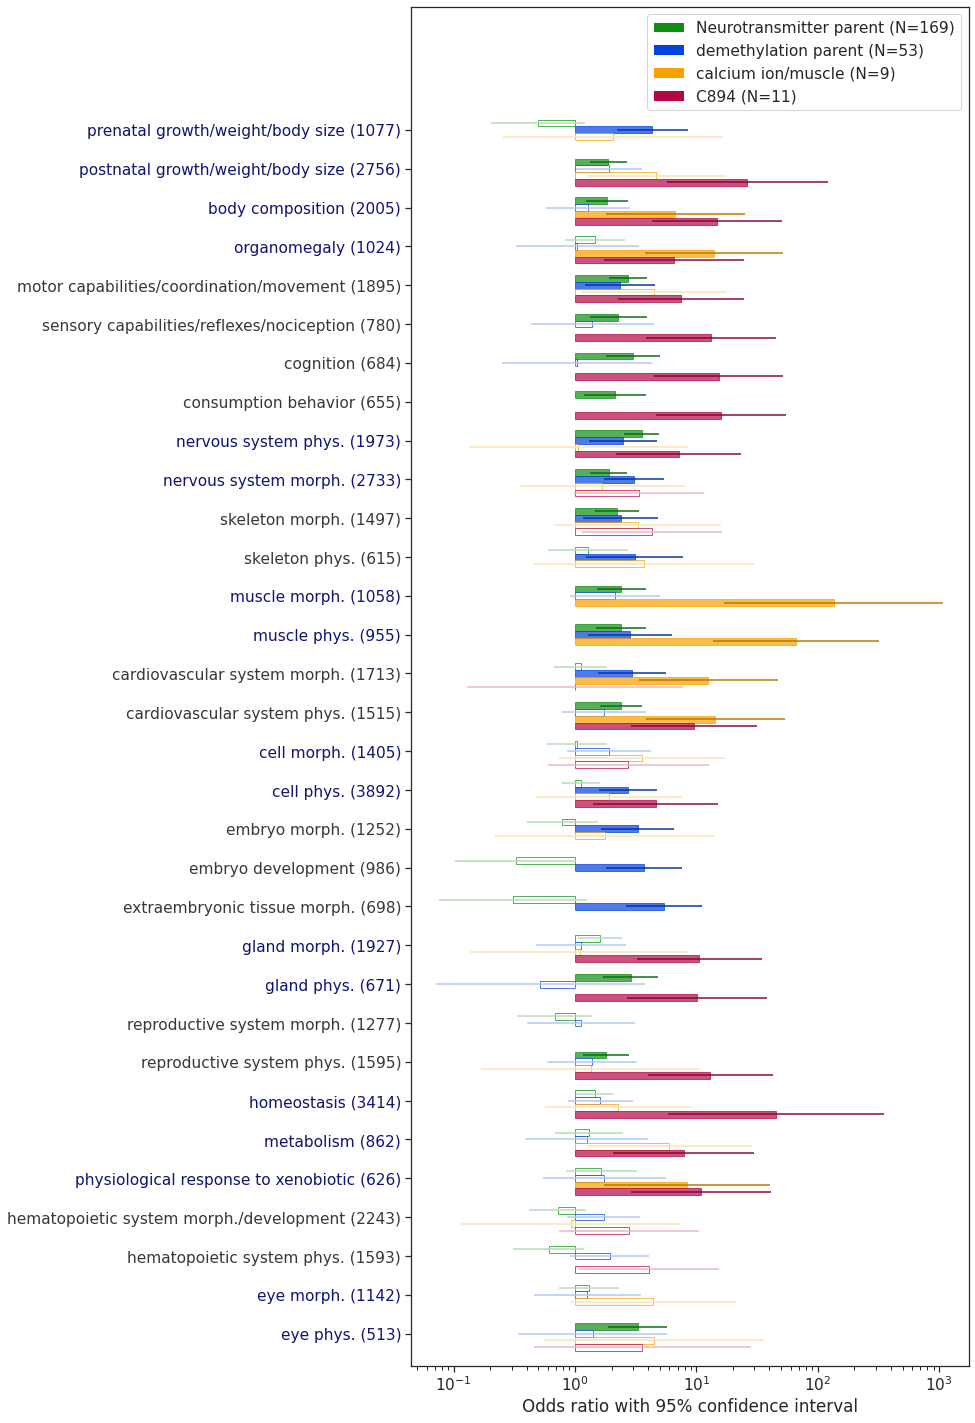

In [253]:
x, ax = plot_hbar_comparison(results_old, ["C879", "C882", "C907", "C894"], mps=mps3, vert=25,
                   community_names = ["Neurotransmitter parent", "demethylation parent", "calcium ion/muscle", "C894"])
colors = {0:"#111471", 1:"#3C3638"}
for ytick, color in zip(ax.get_yticklabels(), select_mp_groups):
    ytick.set_color(colors[color])

In [514]:
x.to_csv("bar_plot_data.tsv", sep="\t")

Significant enrichments (q < 0.05):
                             description      q_OR      OR_p
MP:0003956           abnormal body size  0.007409  0.002264
MP:0010866  abnormal prenatal body size  0.007409  0.002470
MP:0001431     abnormal eating behavior  0.018102  0.009051


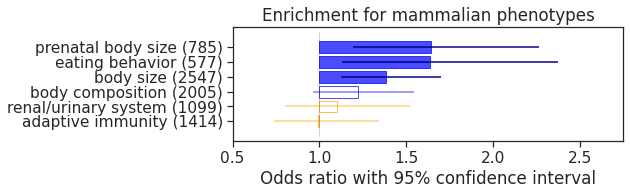

In [105]:
a = plot_specific_CIs_bar(results_old, ["MP:0001431", "MP:0010866", "MP:0003956", "MP:0005451", "MP:0002420", "MP:0005367"], n_test=4, sort=True)

_ =plt.xlim((0.5, 2.75))
_ =plt.xticks([0.5, 1.0, 1.5, 2.0, 2.5])

Significant enrichments (q < 0.05):
                                    description      q_OR          OR_p
MP:0003633  abnormal nervous system physiology  0.000002  1.386163e-07
MP:0003632  abnormal nervous system morphology  0.001473  3.155439e-04
MP:0002108          abnormal muscle morphology  0.001473  3.100913e-04
MP:0005508        abnormal skeleton morphology  0.004285  1.224183e-03
MP:0005621            abnormal cell physiology  0.026467  9.452435e-03


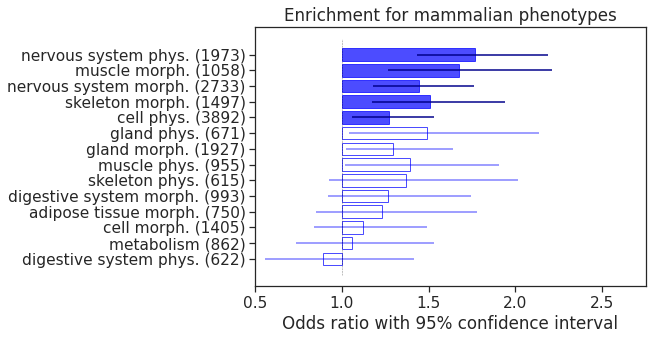

In [106]:
b = plot_specific_CIs_bar(results_old, ["MP:0000003", "MP:0002108", "MP:0002106", "MP:0005508", "MP:0001533", "MP:0003632", "MP:0003633", "MP:0005266", "MP:0002163", "MP:0002164", "MP:0000358", "MP:0005621", "MP:0000462", "MP:0001663"], n_test=14, sort=True)

_ =plt.xlim((0.5, 2.75))
_ =plt.xticks([0.5, 1.0, 1.5, 2.0, 2.5])

# Gene lists

In [108]:
term_counts, gene_mapping, term_mapping = genes_per_node(MPO2)

In [109]:
a = get_gene_hits("C879", hier_df_genes, term_mapping, "MP:0001431", MPO2, mp_graph)
a.head()

gene community          MP   MP_parent  inMP  MsOrtho  \
0  NRCAM      C879  MP:0001431  MP:0001431     0        1   
1   SYT6      C879  MP:0001431  MP:0001431     0        0   
2   SYT2      C879  MP:0001431  MP:0001431     0        1   
3   SYT1      C879  MP:0001431  MP:0001431     1        1   
4  KRT75      C879  MP:0001431  MP:0001431     0        1   

                description  
0  abnormal eating behavior  
1  abnormal eating behavior  
2  abnormal eating behavior  
3  abnormal eating behavior  
4  abnormal eating behavior

In [110]:
c879_1431 = get_gene_hits("C879", hier_df_genes, term_mapping, "MP:0001431", MPO2, mp_graph)

In [111]:
c879_2069 = get_gene_hits("C879", hier_df_genes, term_mapping, "MP:0002069", MPO2, mp_graph)

In [112]:
c879_3632 = get_gene_hits("C879", hier_df_genes, term_mapping, "MP:0003632", MPO2, mp_graph)

In [113]:
c882_4196 = get_gene_hits("C882", hier_df_genes, term_mapping, "MP:0004196", MPO2, mp_graph)

In [114]:
c882_10866 = get_gene_hits("C882", hier_df_genes, term_mapping, "MP:0010866", MPO2, mp_graph)

In [115]:
c882_3632 = get_gene_hits("C882", hier_df_genes, term_mapping, "MP:0003632", MPO2, mp_graph)

In [116]:
c882_9937 = get_gene_hits("C882", hier_df_genes, term_mapping, "MP:0009937", MPO2, mp_graph)
for u in c882_9937.loc[c882_9937.inMP == 1].gene.unique():
    print(u)

ZBTB20
NDE1
PTBP2
NUMBL
UBR2


In [117]:
c907_5369 = get_gene_hits("C907", hier_df_genes, term_mapping, "MP:0005369", MPO2, mp_graph)
for u in c907_5369.loc[c907_5369.inMP == 1].gene.unique():
    print(u)

MYF5
DMD
CASQ2
VGLL2
PDLIM3
MYH4
MYOZ2
AKAP6


In [118]:
c879_3633 = get_gene_hits("C879", hier_df_genes, term_mapping, "MP:0003633", MPO2, mp_graph)
for u in c879_3633.loc[c879_3633.inMP == 1].gene.unique():
    print(u)

NRCAM
SYT2
SYT1
WNK1
NPFFR1
EMX2
POMC
SLC6A7
RASGRF1
DOC2A
RAPSN
AATK
CALY
CACNA1C
UNC13B
GRIA3
CPNE6
CACNA1D
CLCN2
ARPP21
NRXN1
A1CF
NOVA1
MYF5
LMTK3
THY1
JAM3
FSCN2
PACSIN2
NLGN1
SYTL4
RIMS2
FAM20C
UNC13D
ELAVL4
SYTL1
PTPRD
CADPS
POU1F1
TRPM3
SLITRK6
BDNF
NUMBL
ASIC2
RAB27B
TRPC4
CHGB
C2CD5
GNAO1


In [119]:
all_results = pd.concat([c879_1431, c879_2069, c879_3632, c882_4196, c882_10866, c882_3632])

# Network Plotting

In [485]:
import networkx as nx
import random
from matplotlib.patches import BoxStyle as bx
 
def hierarchy_pos(G, root=None, width=1., vert_gap = 0.2, vert_loc = 0, leaf_vs_root_factor = 0.5):

    '''
    If the graph is a tree this will return the positions to plot this in a 
    hierarchical layout.
    
    Based on Joel's answer at https://stackoverflow.com/a/29597209/2966723,
    but with some modifications.  

    We include this because it may be useful for plotting transmission trees,
    and there is currently no networkx equivalent (though it may be coming soon).
    
    There are two basic approaches we think of to allocate the horizontal 
    location of a node.  
    
    - Top down: we allocate horizontal space to a node.  Then its ``k`` 
      descendants split up that horizontal space equally.  This tends to result
      in overlapping nodes when some have many descendants.
    - Bottom up: we allocate horizontal space to each leaf node.  A node at a 
      higher level gets the entire space allocated to its descendant leaves.
      Based on this, leaf nodes at higher levels get the same space as leaf
      nodes very deep in the tree.  
      
    We use use both of these approaches simultaneously with ``leaf_vs_root_factor`` 
    determining how much of the horizontal space is based on the bottom up 
    or top down approaches.  ``0`` gives pure bottom up, while 1 gives pure top
    down.   
    
    
    :Arguments: 
    
    **G** the graph (must be a tree)

    **root** the root node of the tree 
    - if the tree is directed and this is not given, the root will be found and used
    - if the tree is directed and this is given, then the positions will be 
      just for the descendants of this node.
    - if the tree is undirected and not given, then a random choice will be used.

    **width** horizontal space allocated for this branch - avoids overlap with other branches

    **vert_gap** gap between levels of hierarchy

    **vert_loc** vertical location of root
    
    **leaf_vs_root_factor**

    xcenter: horizontal location of root
    '''
    if not nx.is_tree(G):
        raise TypeError('cannot use hierarchy_pos on a graph that is not a tree')

    if root is None:
        if isinstance(G, nx.DiGraph):
            root = next(iter(nx.topological_sort(G)))  #allows back compatibility with nx version 1.11
        else:
            root = random.choice(list(G.nodes))

    def _hierarchy_pos(G, root, leftmost, width, leafdx = 0.2, vert_gap = 0.2, vert_loc = 0, 
                    xcenter = 0.5, rootpos = None, 
                    leafpos = None, parent = None):
        '''
        see hierarchy_pos docstring for most arguments

        pos: a dict saying where all nodes go if they have been assigned
        parent: parent of this branch. - only affects it if non-directed

        '''

        if rootpos is None:
            rootpos = {root:(xcenter,vert_loc)}
        else:
            rootpos[root] = (xcenter, vert_loc)
        if leafpos is None:
            leafpos = {}
        children = list(G.neighbors(root))
        leaf_count = 0
        if not isinstance(G, nx.DiGraph) and parent is not None:
            children.remove(parent)  
        if len(children)!=0:
            rootdx = width/len(children)
            nextx = xcenter - width/2 - rootdx/2
            for child in children:
                nextx += rootdx
                rootpos, leafpos, newleaves = _hierarchy_pos(G,child, leftmost+leaf_count*leafdx, 
                                    width=rootdx, leafdx=leafdx,
                                    vert_gap = vert_gap, vert_loc = vert_loc-vert_gap, 
                                    xcenter=nextx, rootpos=rootpos, leafpos=leafpos, parent = root)
                leaf_count += newleaves

            leftmostchild = min((x for x,y in [leafpos[child] for child in children]))
            rightmostchild = max((x for x,y in [leafpos[child] for child in children]))
            leafpos[root] = ((leftmostchild+rightmostchild)/2, vert_loc)
        else:
            leaf_count = 1
            leafpos[root]  = (leftmost, vert_loc)
#        pos[root] = (leftmost + (leaf_count-1)*dx/2., vert_loc)
#        print(leaf_count)
        return rootpos, leafpos, leaf_count

    xcenter = width/2.
    if isinstance(G, nx.DiGraph):
        leafcount = len([node for node in nx.descendants(G, root) if G.out_degree(node)==0])
    elif isinstance(G, nx.Graph):
        leafcount = len([node for node in nx.node_connected_component(G, root) if G.degree(node)==1 and node != root])
    rootpos, leafpos, leaf_count = _hierarchy_pos(G, root, 0, width, 
                                                    leafdx=width*1./leafcount, 
                                                    vert_gap=vert_gap, 
                                                    vert_loc = vert_loc, 
                                                    xcenter = xcenter)
    pos = {}
    for node in rootpos:
        pos[node] = (leaf_vs_root_factor*leafpos[node][0] + (1-leaf_vs_root_factor)*rootpos[node][0], leafpos[node][1]) 
#    pos = {node:(leaf_vs_root_factor*x1+(1-leaf_vs_root_factor)*x2, y1) for ((x1,y1), (x2,y2)) in (leafpos[node], rootpos[node]) for node in rootpos}
    xmax = max(x for x,y in pos.values())
    for node in pos:
        pos[node]= (pos[node][0]*width/(xmax+1), pos[node][1])
    return pos


def draw_significance_hierarchy(data, community, root, mpG, MPO, hier_df_genes, term_mapping, select_on="q", size_by="OR", 
                                color_by="q", alpha_by=None, 
                                vert=10, label="all", descriptive_labels=False,
                               adjust_root=0):
    comm_genes = hier_df_genes.loc[community, "CD_MemberList"].split(" ")
    data = data.loc[data.name==community]
    stop = False
    sigH = []
    queue = []
    current=root
    previous=root
    data = data.assign(proportion=data.observed/data.total)
    while not stop:
        children = [node for node in nx.dfs_preorder_nodes(mpG, current, 1)]
        if len(children) == 0:
            if len(queue) > 0:
                previous, current = queue.pop()
            else:
                stop=True
        else:
            node_order = [node for node in children if node in data.index]
            subset = data.loc[node_order]
            subset.loc[:, "q"] = fdrcorrection(subset.OR_p, method="poscorr")[1]
            if select_on=="q":
                new_sigs = list(subset.loc[subset.q < subset.loc[current, "q"], "MP"].values)
            elif select_on=="OR":
                new_sigs = list(subset.loc[subset.OR > subset.loc[current, "OR"], "MP"].values)
            if select_on=="proportion":
                new_sigs = list(subset.loc[subset.proportion > subset.loc[current, "proportion"], "MP"].values)
            queue += [(current, sig)for sig in new_sigs if sig != current]
            sigH.append((current, previous, subset.loc[current, "q"], subset.loc[current, "OR"], subset.loc[current, "observed"]))
            if len(queue) > 0:
                previous, current = queue.pop()
            else:
                stop=True  
    sigG = nx.DiGraph()
    sigG.add_node(sigH[0][0], OR=sigH[0][3], q=-1*np.log10(sigH[0][2]), obs=sigH[0][4])
    for edge in sigH[1:]:
        sigG.add_node(edge[0], OR=edge[3], q=-1*np.log10(edge[2]), obs=edge[4])
        if sigG.in_degree[edge[0]] < 1:
            sigG.add_edge(edge[1], edge[0])
    node_data = pd.DataFrame.from_dict(sigG.nodes, orient='index')
    # add the gene hits for each node
    hit_sets = [list(get_gene_hits_no_annotation(comm_genes, term, MPO, term_mapping)) for term in node_data.index.values]
    node_data = node_data.assign(hits=hit_sets)
    H = nx.convert_node_labels_to_integers(sigG, label_attribute="node_label")
    plt.figure(figsize=(20,vert))
    pos = hierarchy_pos(sigG,root=root, leaf_vs_root_factor=1)
    # get term descriptions
    descriptions = MPO.node_attr
    descriptions.index.name=None
    # create sizes
    max_size=1000
    min_size=100
    node_sizes= normalize_to_range(node_data[size_by], upper=max_size, lower=min_size)
    # get transparency values
    max_alpha=1
    min_alpha=0.2
    if alpha_by in ["q", "OR", "obs"]:
        node_alphas = list(normalize_to_range(1 - 1 / node_data[alpha_by].values, upper=max_alpha, lower=min_alpha))
    else:
        node_alphas = 1
    # get labels
    hrz="left"
    vrt="center"
    if label == "all":
        node_labels = {node:node for node in node_data.index.values}
        hrz = "center"
        vrt='bottom'
    elif label == "leaf":
        if descriptive_labels:
            labels = [" "*(2+int(node_sizes[i]/200)) + descriptions.loc[node, "description"] if (sigG.out_degree[node]==0) else "" for i, node in enumerate(node_data.index.values)]
        else:
            labels = [" "*(2+int(node_sizes[i]/200)) + node if (sigG.out_degree[node]==0) else "" for i, node in enumerate(node_data.index.values)]
        node_labels = {node_data.index.values[i]:labels[i] for i in range(len(labels))}
    # plot results
    pos2 = {key:(-1*pos[key][1], pos[key][0]) for key in pos.keys()}
    
    pos2[root] = (-1 * adjust_root, pos2[root][1])
    nx.draw_networkx(sigG,with_labels=True, pos=pos2, node_size=node_sizes, nodelist=list(node_data.index),
                    node_color="white", label="test", edgelist=None,
                    labels=node_labels, horizontalalignment=hrz, verticalalignment=vrt, font_size=12)
    n = nx.draw_networkx_nodes(sigG, pos=pos2, node_size=node_sizes, nodelist=list(node_data.index),
                    node_color=node_data[color_by], cmap="viridis", label="test", alpha = node_alphas)
    # edge labels for edges out of root
    if descriptive_labels:
        edge_labels = [descriptions.loc[node, "description"] if sigG.has_edge(root, node) else "" for node in sigG.nodes]
    else:
        edge_labels = [node if sigG.has_edge(root, node) else "" for node in sigG.nodes]

    edge_labels = {(root, node_data.index.values[i]):edge_labels[i] for i in range(len(edge_labels))}
    if label != "all":
        nx.draw_networkx_edge_labels(sigG, pos=pos2, edge_labels=edge_labels, label_pos=0.48, 
                                     bbox={"boxstyle":bx.Round(pad=0, rounding_size=0.99),
                                          "facecolor":"white"})
    sm = plt.cm.ScalarMappable(cmap="viridis", norm=plt.Normalize(vmin=min(node_data[color_by]), vmax=max(node_data[color_by])))
    sm._A = []
    plt.colorbar(sm, orientation="horizontal", label=color_by, shrink=0.3, pad =0.02 )
    #nx.draw_networkx_labels(sigG, pos=pos2, font_size=12, verticalalignment="bottom", horizontalalignment="left")
    #plt.legend(n)
    legend_G, legend_sizes, legend_pos = create_legend_size_graph(node_sizes, node_data, size_by=size_by, adjust_root=adjust_root)
    #return legend_G, legend_sizes, legend_pos
    try:
        nx.draw_networkx(legend_G, pos =legend_pos, node_size=legend_sizes, node_color="black", nodelist=list(legend_G.nodes()),
                        verticalalignment="center", font_color="white")
    except ValueError:
        print("Could not plot size legend.")    
    
    print("PARENT:", root, descriptions.loc[root, "description"])
    plt.xlim(-1 * adjust_root-0.05, max([pos2[k][0] for k in pos2]) * 1.5)
    plt.show()
    return node_data

def create_legend_size_graph(node_sizes, node_data, min_size=100, max_size=1000, size_by='obs', adjust_root=0):
    G = nx.Graph()
    lower = min([sz for sz in node_sizes])
    true_lower = min(node_data[size_by])
    upper = max([sz for sz in node_sizes])
    true_upper = max(node_data[size_by])
    true_q1, true_q3 = [round(x) for x in np.quantile([true_lower, true_upper], [0.3333, 0.66667])]
    q1, q3 = np.quantile([lower, upper], [0.3333, 0.66667])
    positions = {}
    for i, node in enumerate([round(true_lower), round(true_q1), round(true_q3),  round(true_upper)]):
        G.add_node(node)
        positions[node] = (0.02 + 0.05*(i-1) - adjust_root, 0.4)
    leg_sizes = [lower, q1, q3, upper]
    return G, leg_sizes, positions
    
    

def normalize_to_range(data, upper, lower):
    # normalize to unit
    norm_data = (data - min(data))/(max(data)-min(data))
    # normalize to range
    norm_data = norm_data * (upper - lower) + lower
    return norm_data

In [121]:
results_old = results_old.assign(MP=results_old.index.values)


### Example 1 - all MP labels

PARENT: MP:0005378 growth/size/body region phenotype


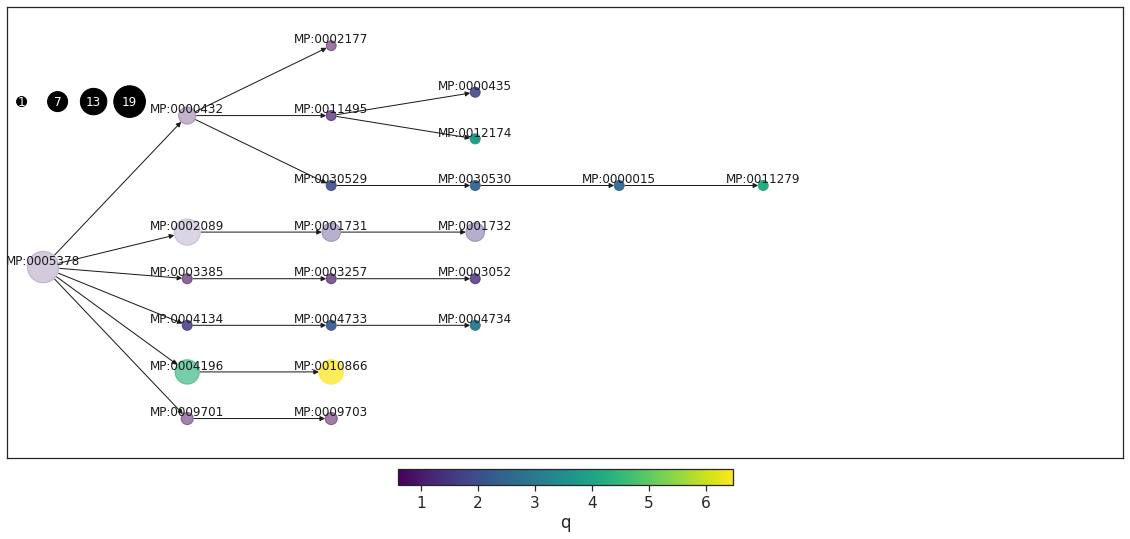

In [473]:
n = draw_significance_hierarchy(results_old, "C882", "MP:0005378", mp_graph, MPO2, hier_df_genes, term_mapping, select_on="proportion", 
                                size_by="obs", alpha_by="OR",color_by="q", vert=10, label="all", descriptive_labels=False)

### Example 2 - only leaf labels, MP

PARENT: MP:0005378 growth/size/body region phenotype


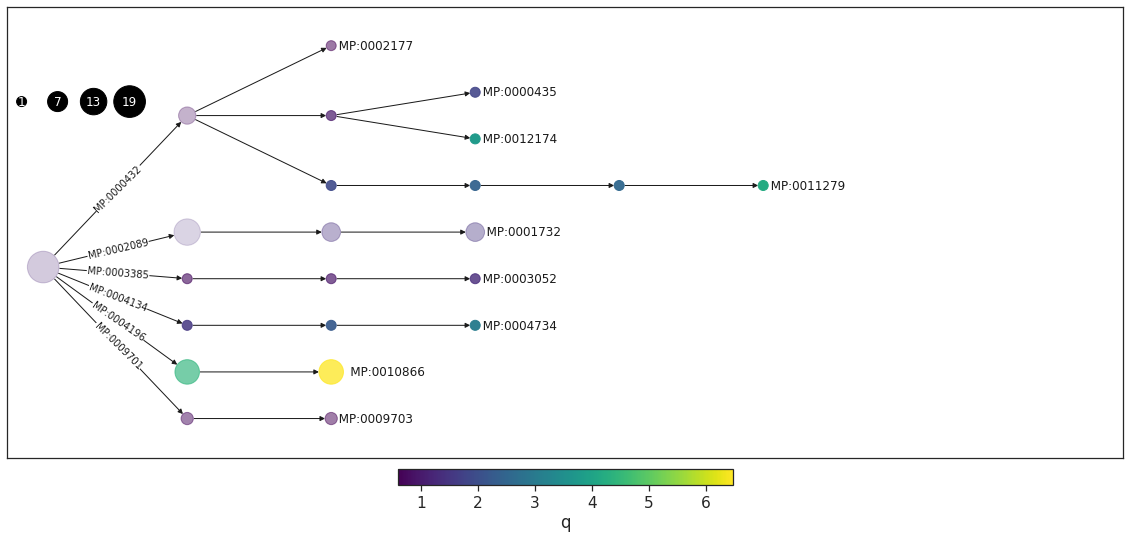

In [469]:
n = draw_significance_hierarchy(results_old, "C882", "MP:0005378", mp_graph, MPO2, hier_df_genes, term_mapping, select_on="proportion", 
                                size_by="obs", alpha_by="OR",color_by="q", vert=10, label="leaf", descriptive_labels=False)

### Example 3 - descriptive labels

PARENT: MP:0005378 growth/size/body region phenotype


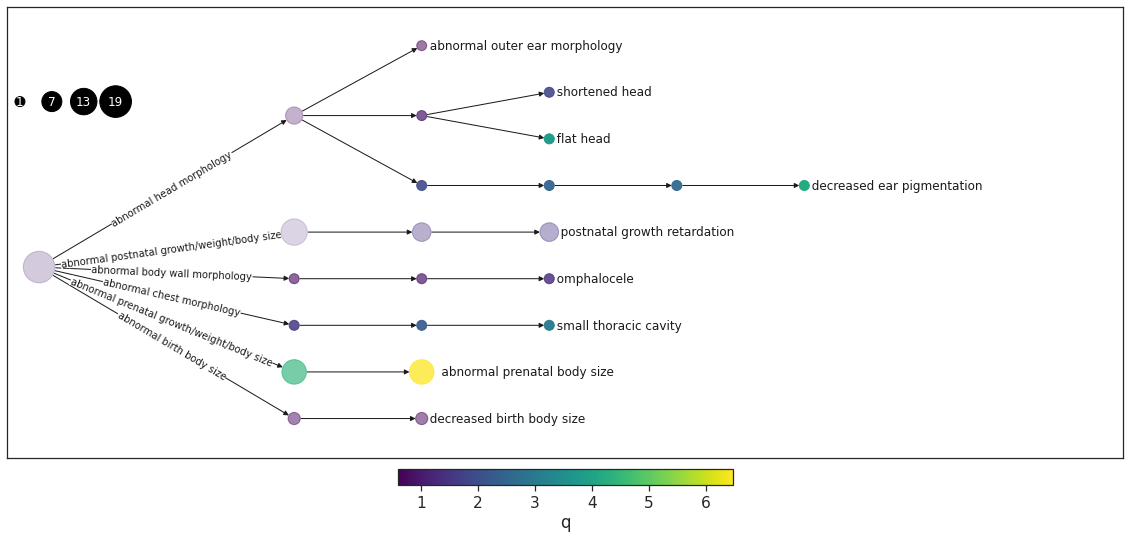

In [474]:
n = draw_significance_hierarchy(results_old, "C882", "MP:0005378", mp_graph, MPO2, hier_df_genes, term_mapping, select_on="proportion", 
                                size_by="obs", alpha_by="OR",color_by="q", vert=10, label="leaf", descriptive_labels=True, adjust_root=0.2)

### Example - output table

In [418]:
n.head()

OR         q   obs  \
MP:0005378  1.998465  1.147140  19.0   
MP:0009701  3.001945  0.714008   2.0   
MP:0009703  3.027288  0.598912   2.0   
MP:0004196  4.348946  4.411253  11.0   
MP:0010866  6.088440  6.464482  11.0   

                                                         hits  
MP:0005378  [KDM3B, KDM6B, SPG7, CCP110, UBR2, KDM8, WNK1,...  
MP:0009701                                       [SP3, KDM6A]  
MP:0009703                                       [SP3, KDM6A]  
MP:0004196  [NUMBL, CCP110, NFATC3, UBR2, KDM8, KDM6A, KDM...  
MP:0010866  [NUMBL, CCP110, NFATC3, UBR2, KDM8, KDM6A, KDM...

## C907

Growth/Body Size
PARENT: MP:0005378 growth/size/body region phenotype


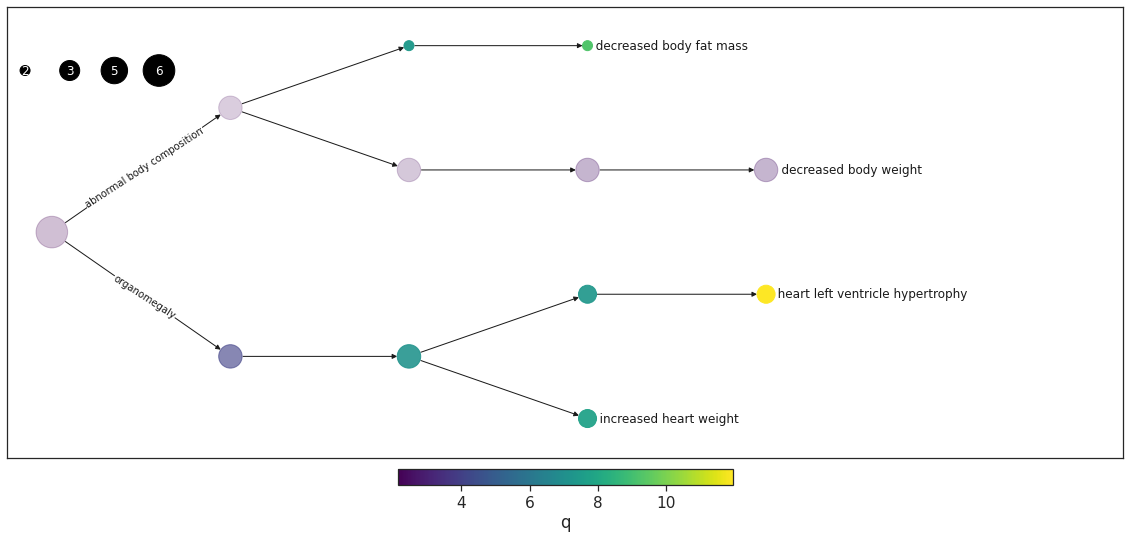

In [516]:
print("Growth/Body Size")
n = draw_significance_hierarchy(results_old.loc[results_old.observed>=2], "C907", "MP:0005378", mp_graph, MPO2, hier_df_genes, term_mapping, select_on="proportion", 
                                size_by="obs", alpha_by="OR",color_by="q", vert=10, label="leaf", descriptive_labels=True)

# add minimum observed (set a rule on percent of total?)
# write up rules for inclusion
# which ones to start with
# Added size legend and improved descriptive labelling

Growth/Body Size
Could not plot size legend.
PARENT: MP:0002089 abnormal postnatal growth/weight/body size


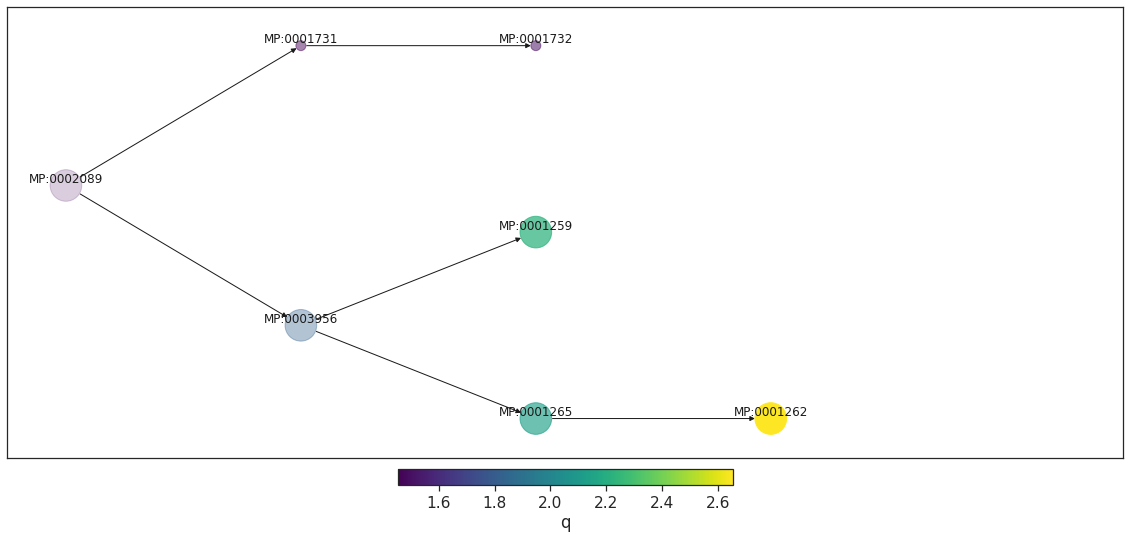

In [486]:
print("Growth/Body Size")
n = draw_significance_hierarchy(results_old.loc[results_old.observed>=2], "C907", "MP:0002089", mp_graph, MPO2, hier_df_genes, term_mapping, select_on="proportion", 
                                size_by="obs", alpha_by="OR",color_by="q", vert=10, label="all", descriptive_labels=True)

# add minimum observed (set a rule on percent of total?)
# write up rules for inclusion
# which ones to start with
# Added size legend and improved descriptive labelling

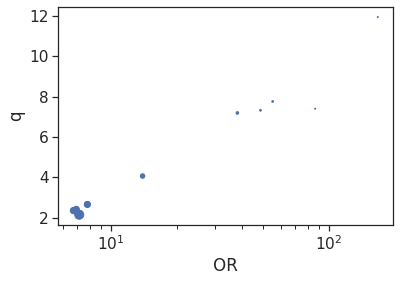

In [529]:
n["term_count"] = [term_counts[node] for node in n.index.values]
plot_volcano(n, sig="q", total="term_count")
plt.xscale("log")

Muscle Phys
PARENT: MP:0002106 abnormal muscle physiology


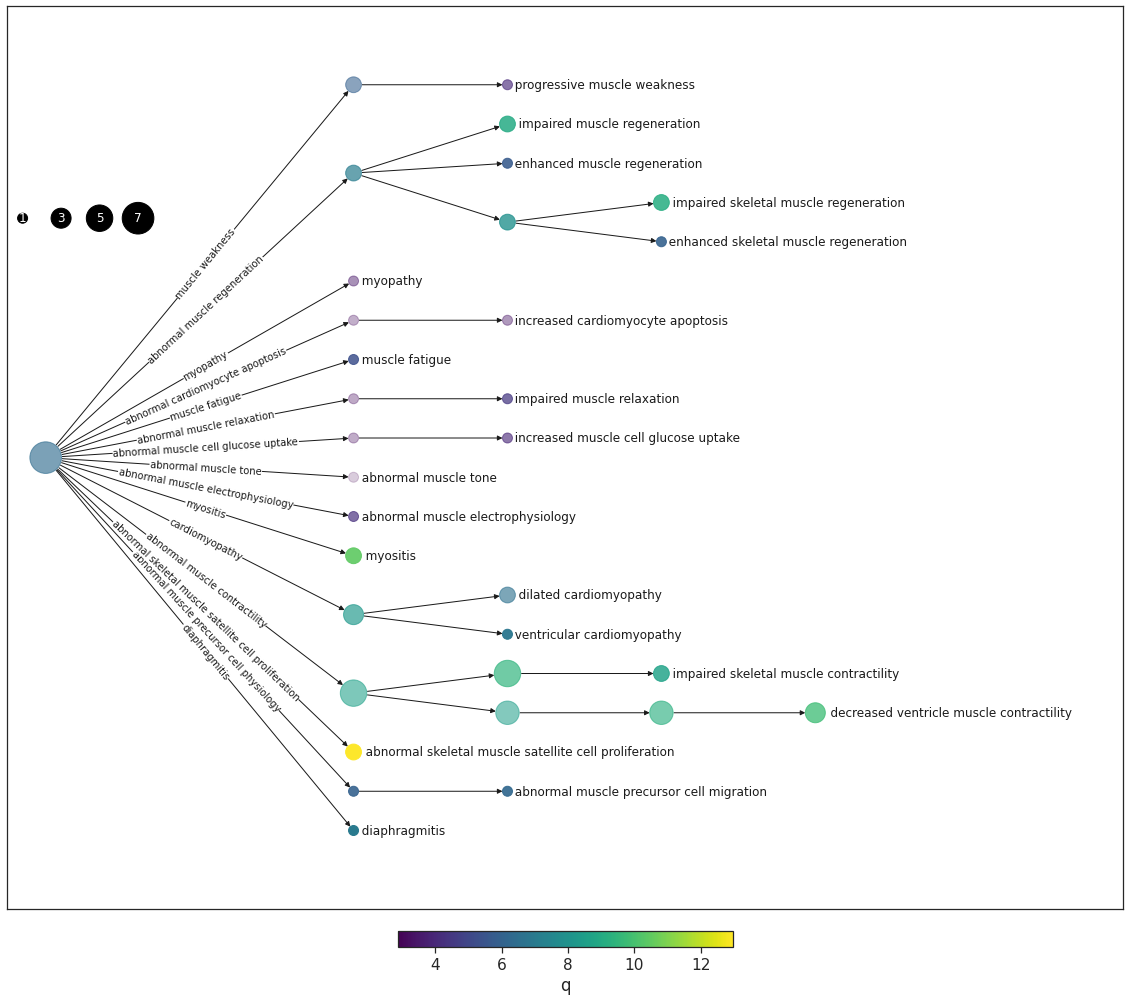

In [476]:
print("Muscle Phys")
n = draw_significance_hierarchy(results_old, "C907", "MP:0002106", mp_graph, MPO2, hier_df_genes, term_mapping, select_on="proportion", 
                                size_by="obs", alpha_by="OR",color_by="q", vert=20, label="leaf", descriptive_labels=True, adjust_root=0.2)


Muscle Morph
PARENT: MP:0002108 abnormal muscle morphology


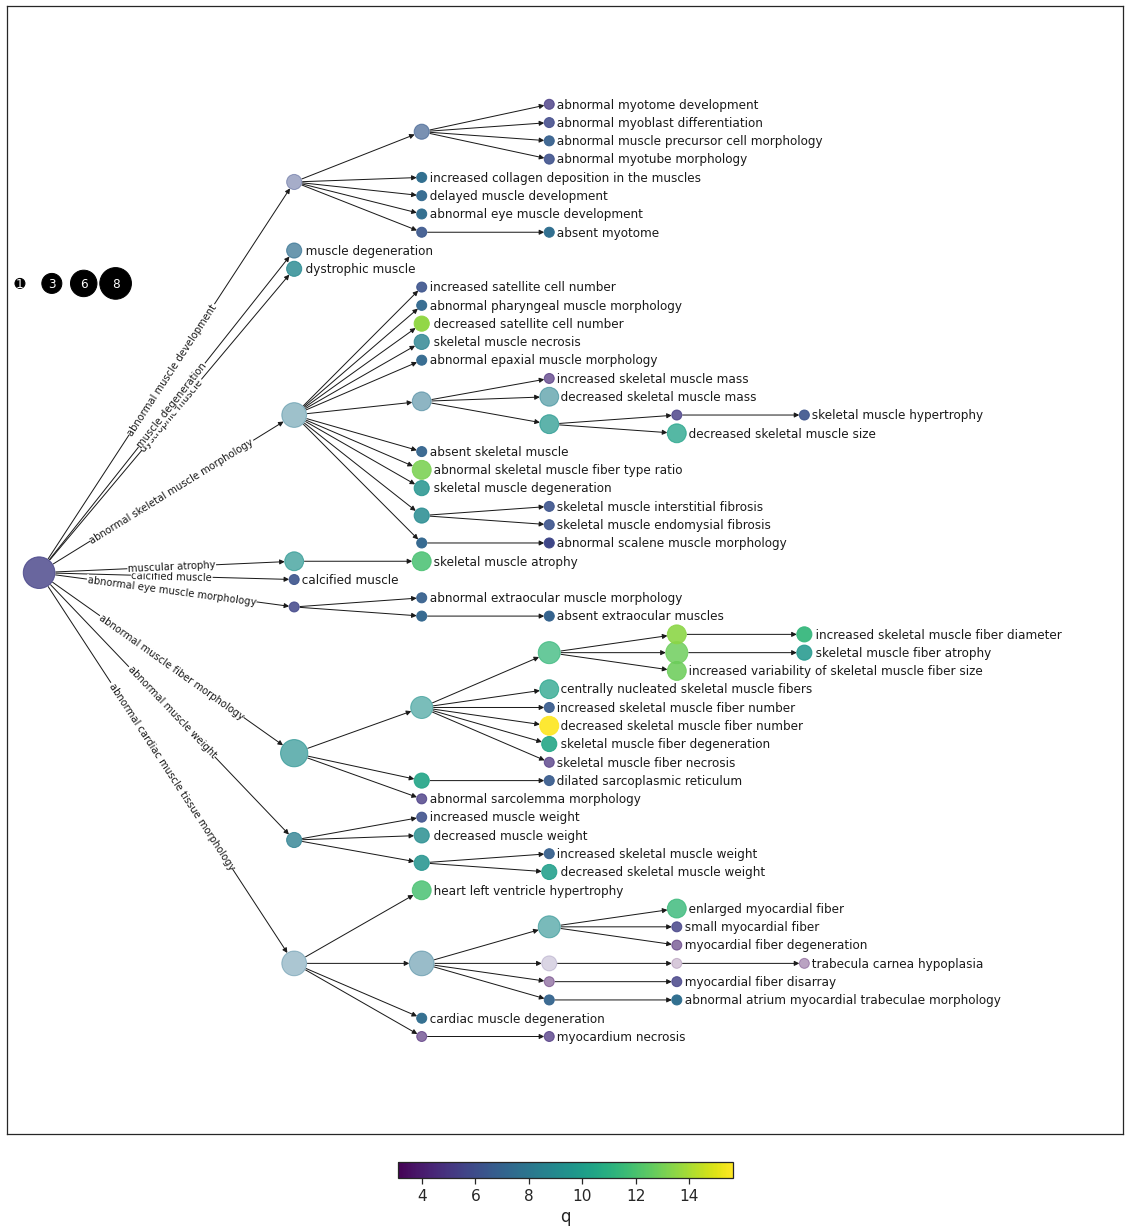

In [477]:
print("Muscle Morph")
n = draw_significance_hierarchy(results_old, "C907", "MP:0002108", mp_graph, MPO2, hier_df_genes, term_mapping, select_on="proportion", 
                                size_by="obs", alpha_by="OR",color_by="q", vert=25, label="leaf", descriptive_labels=True, adjust_root=0.2)

Cardio Morph
PARENT: MP:0002127 abnormal cardiovascular system morphology


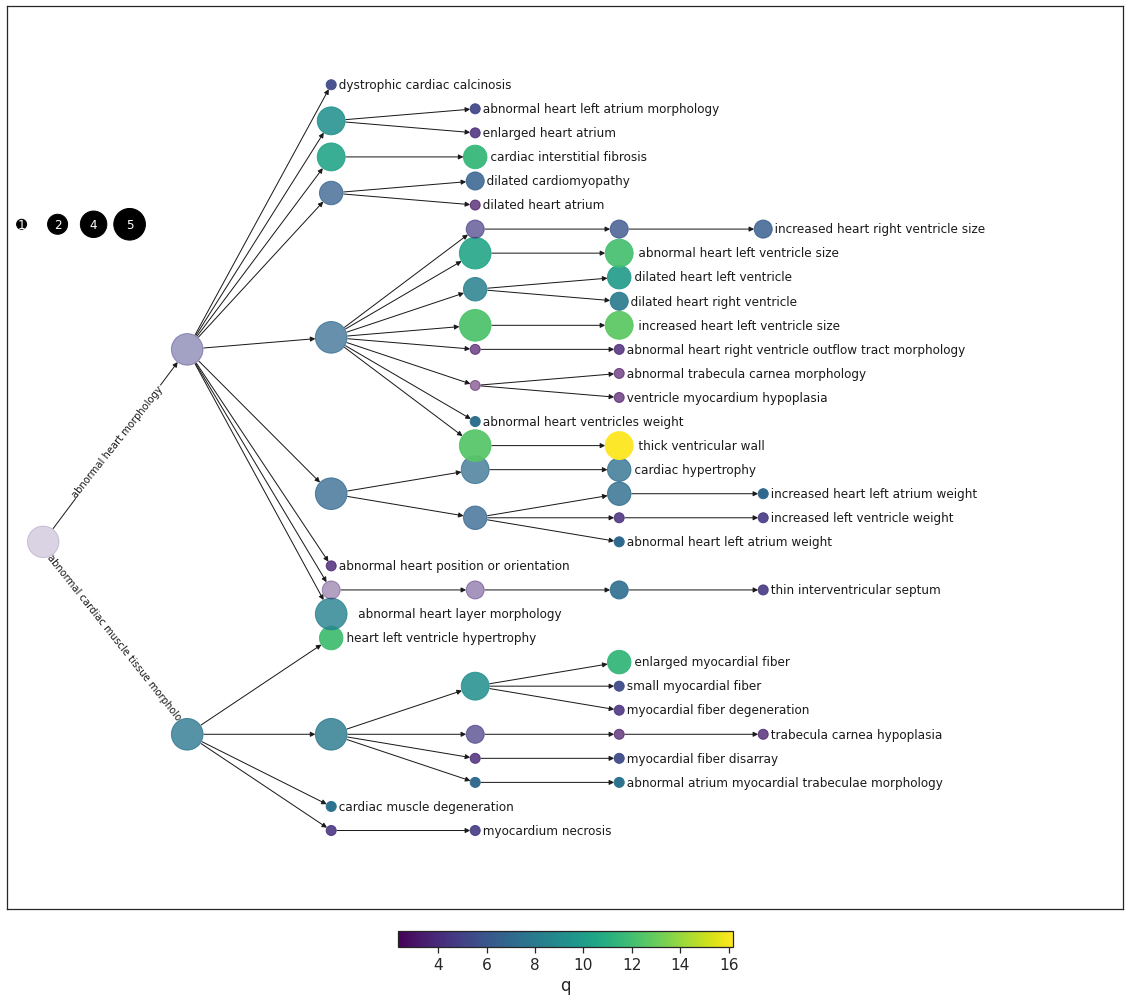

In [478]:
print("Cardio Morph")
n = draw_significance_hierarchy(results_old, "C907", "MP:0002127", mp_graph, MPO2, hier_df_genes, term_mapping, select_on="proportion", 
                                size_by="obs", alpha_by="OR",color_by="q", vert=20, label="leaf", descriptive_labels=True)

Cardio Phys
PARENT: MP:0001544 abnormal cardiovascular system physiology


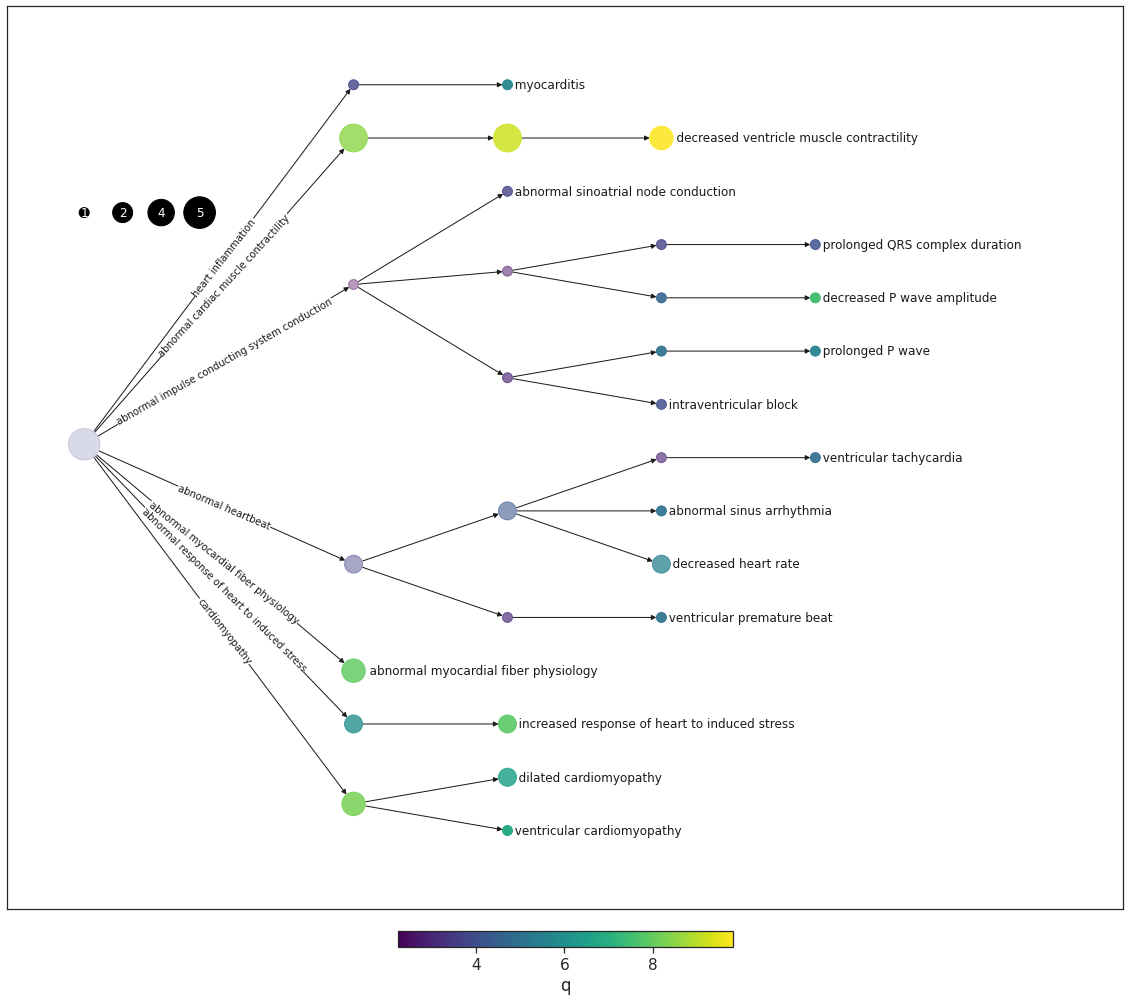

In [438]:
print("Cardio Phys")
n = draw_significance_hierarchy(results_old, "C907", "MP:0001544", mp_graph, MPO2, hier_df_genes, term_mapping, select_on="proportion", 
                                size_by="obs", alpha_by="OR",color_by="q", vert=20, label="leaf", descriptive_labels=True, adjust_root=0.15)

In [ ]:
n

## C879

Growth/Body Size
PARENT: MP:0005378 growth/size/body region phenotype


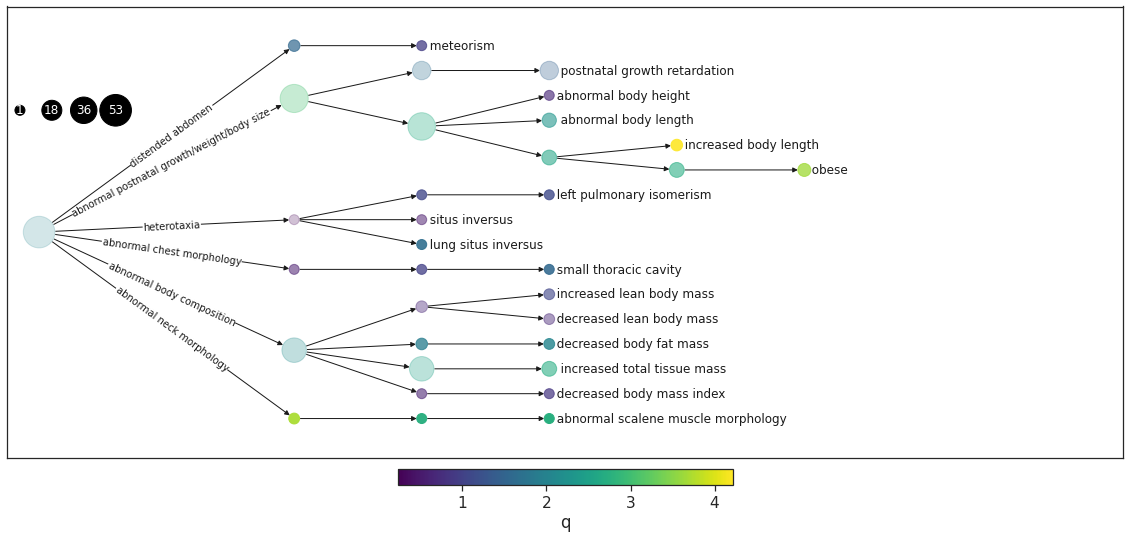

In [545]:
print("Growth/Body Size")
n = draw_significance_hierarchy(results_old, "C879", "MP:0005378", mp_graph, MPO2, hier_df_genes, term_mapping, select_on="proportion", 
                                size_by="obs", alpha_by="OR",color_by="q", vert=10, label="leaf", descriptive_labels=True, adjust_root=0.2)

/tmp/ipykernel_575738/1673602740.py:4: UserWarning: Attempted to set non-positive left xlim on a log-scaled axis.
Invalid limit will be ignored.
  plt.xlim(0, 10)


(1.2817999195660106, 10)

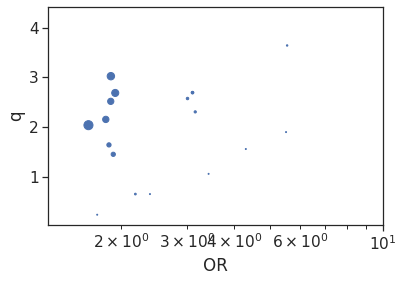

In [546]:
n["term_count"] = [term_counts[node] for node in n.index.values]
plot_volcano(n, sig="q", total="term_count")
plt.xscale("log")
plt.xlim(0, 10)

In [535]:
results_old[results_old.name == "C"]

observed   total         OR      OR_p  OR_CI_lower  OR_CI_upper  \
MP:0000001     359.0  9108.0   1.367147  0.000110     1.166759     1.601951   
MP:0010768     194.0  4591.0   1.357213  0.000494     1.142930     1.611671   
MP:0010769     184.0  4194.0   1.419438  0.000084     1.192004     1.690267   
MP:0005384     182.0  4343.0   1.332818  0.001300     1.118747     1.587851   
MP:0010770     171.0  3621.0   1.549886  0.000002     1.296036     1.853458   
...              ...     ...        ...       ...          ...          ...   
MP:0000221       1.0   967.0   4.619306  0.171282     0.515809    41.367982   
MP:0009745       1.0   295.0  15.749150  0.013803     1.754973   141.333074   
MP:0002619       1.0  1103.0   4.018376  0.213662     0.448757    35.982360   
MP:0000706       1.0   275.0  16.916971  0.011537     1.884697   151.846102   
MP:0005376       1.0  4161.0   0.880709  0.909552     0.098411     7.881742   

             hyper_p  sig_5e6                                 description  \
MP:0000001  0.000044    False                         mammalian phenotype   
MP:0010768  0.000263    False                             mortality/aging   
MP:0010769  0.000050    False                           abnormal survival   
MP:0005384  0.000676    False                          cellular phenotype   
MP:0010770  0.000001     True                        preweaning lethality   
...              ...      ...                                         ...   
MP:0000221  0.023772    False             decreased leukocyte cell number   
MP:0009745  0.002373    False  abnormal behavioral response to xenobiotic   
MP:0002619  0.030477    False              abnormal lymphocyte morphology   
MP:0000706  0.002066    False                                small thymus   
MP:0005376  0.306397    False            homeostasis/metabolism phenotype   

             size  name          MP  
MP:0000001  642.0  C877  MP:0000001  
MP:0010768  642.0  C877  MP:0010768  
MP:0010769  642.0  C877  MP:0010769  
MP:0005384  642.0  C877  MP:0005384  
MP:0010770  642.0  C877  MP:0010770  
...           ...   ...         ...  
MP:0000221    5.0  C927  MP:0000221  
MP:0009745    5.0  C927  MP:0009745  
MP:0002619    5.0  C927  MP:0002619  
MP:0000706    5.0  C927  MP:0000706  
MP:0005376    5.0  C927  MP:0005376  

[28452 rows x 12 columns]

Growth/Body Size
PARENT: MP:0002089 abnormal postnatal growth/weight/body size


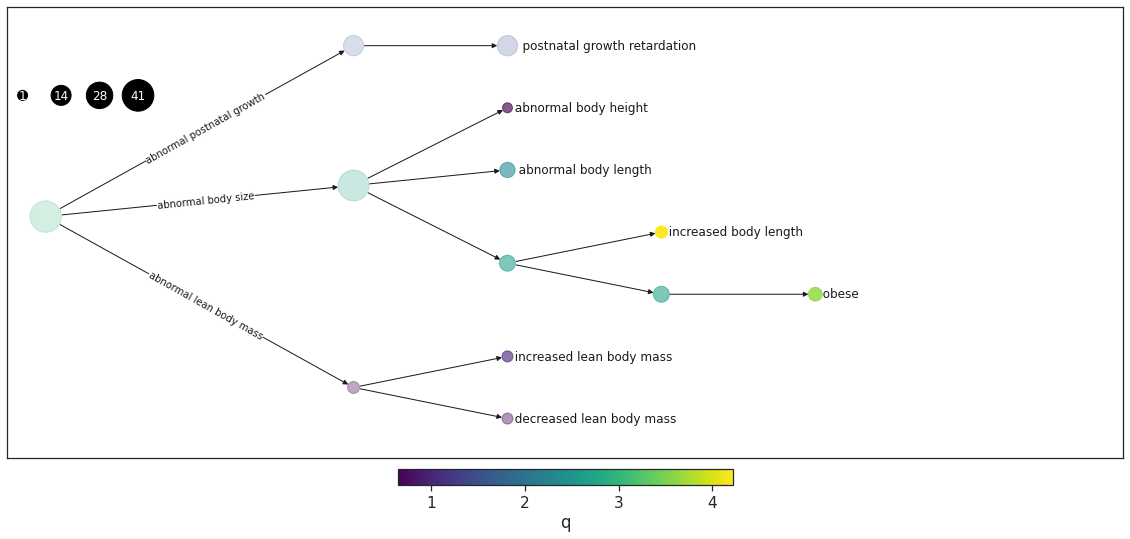

In [488]:
print("Growth/Body Size")
n = draw_significance_hierarchy(results_old, "C879", "MP:0002089", mp_graph, MPO2, hier_df_genes, term_mapping, select_on="proportion", 
                                size_by="obs", alpha_by="OR",color_by="q", vert=10, label="leaf", descriptive_labels=True, adjust_root=0.2)

Consumption Behaviour
PARENT: MP:0002069 abnormal consumption behavior


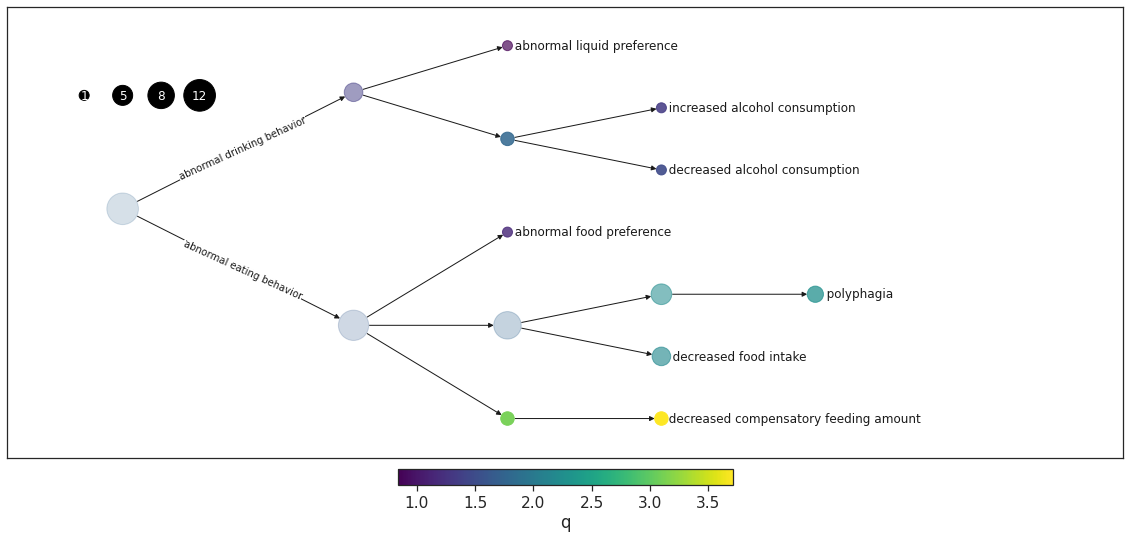

In [443]:
print("Consumption Behaviour")
n = draw_significance_hierarchy(results_old, "C879", "MP:0002069", mp_graph, MPO2, hier_df_genes, term_mapping, select_on="proportion", 
                                size_by="obs", alpha_by="OR",color_by="q", vert=10, label="leaf", descriptive_labels=True, adjust_root=0.1)

Nervous System Physiology
PARENT: MP:0003633 abnormal nervous system physiology


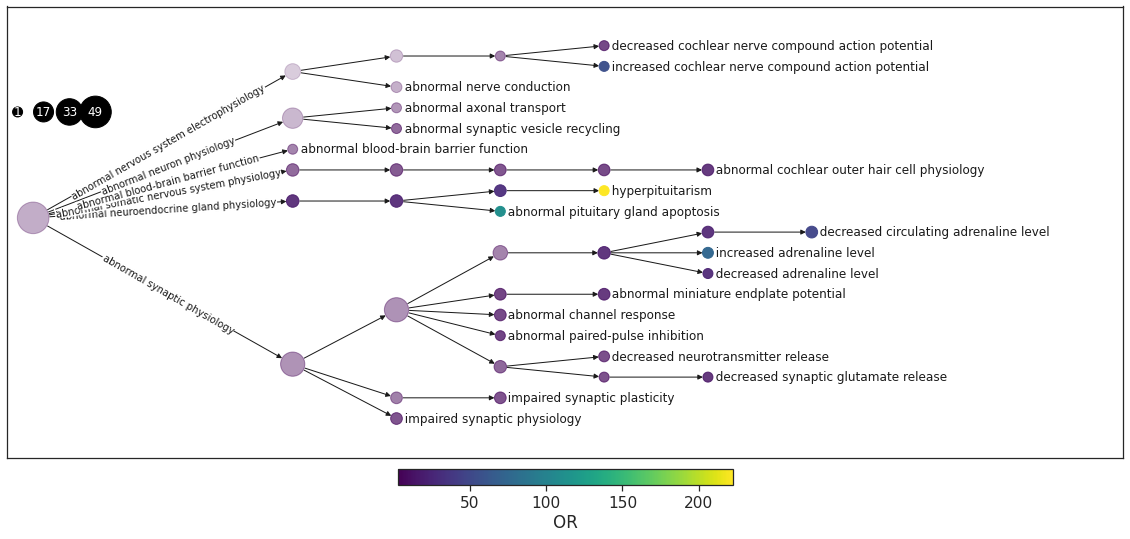

In [547]:
print("Nervous System Physiology")
n = draw_significance_hierarchy(results_old, "C879", "MP:0003633", mp_graph, MPO2, hier_df_genes, term_mapping, select_on="proportion", 
                                size_by="obs", alpha_by="OR",color_by="OR", vert=10, label="leaf", descriptive_labels=True, adjust_root=0.3)


Nervous System Physiology
PARENT: MP:0005253 abnormal eye physiology


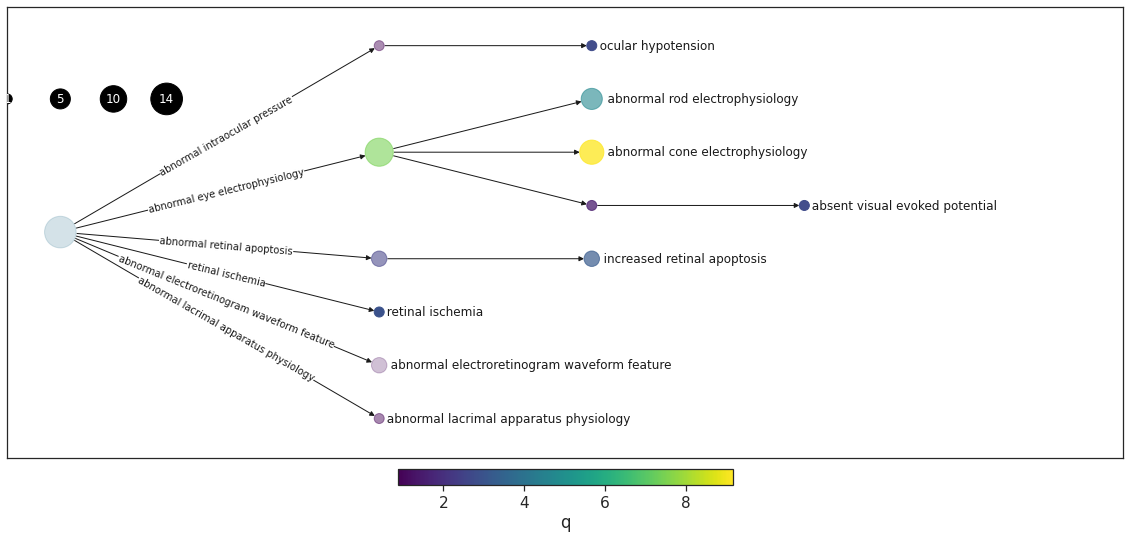

In [451]:
print("Nervous System Physiology")
n = draw_significance_hierarchy(results_old, "C879", "MP:0005253", mp_graph, MPO2, hier_df_genes, term_mapping, select_on="proportion", 
                                size_by="obs", alpha_by="OR",color_by="q", vert=10, label="leaf", descriptive_labels=True, adjust_root=0.1)

Nervous System Physiology
PARENT: MP:0003633 abnormal nervous system physiology


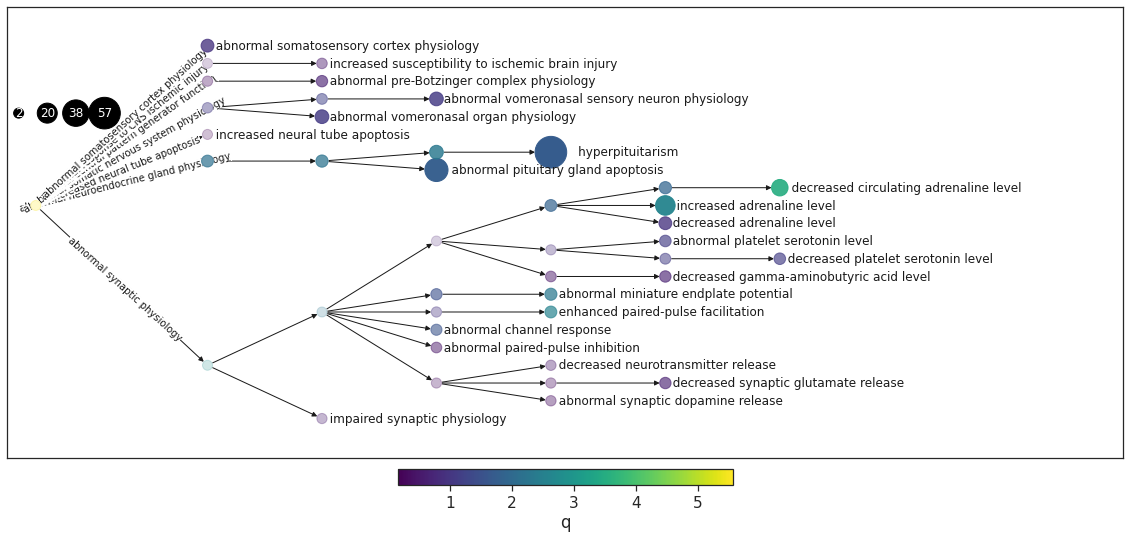

In [554]:
print("Nervous System Physiology")
n = draw_significance_hierarchy(results_old, "C877", "MP:0003633", mp_graph, MPO2, hier_df_genes, term_mapping, select_on="proportion", 
                                size_by="OR", alpha_by="OR",color_by="q", vert=10, label="leaf", descriptive_labels=True, adjust_root=0.1)

In [551]:
n

OR         q    obs  \
MP:0003633   1.769039  5.557156  108.0   
MP:0021009   1.696523  2.808212   46.0   
MP:0021010   1.934913  0.569057    3.0   
MP:0003635   1.710080  2.285177   46.0   
MP:0005445   1.894610  0.304458    5.0   
MP:0010149   2.179887  0.343868    1.0   
MP:0004494   2.024070  0.304458    1.0   
MP:0004495   3.543292  0.632049    1.0   
MP:0003990   2.100810  0.506112    2.0   
MP:0004807   2.576514  0.437453    1.0   
MP:0003484   3.159526  1.529833    4.0   
MP:0002918   2.090452  0.947379    5.0   
MP:0002919   4.188752  2.540315    5.0   
MP:0002913   3.345750  1.467508    4.0   
MP:0004835   4.552476  2.300567    4.0   
MP:0002204   1.686110  0.598824   10.0   
MP:0030731   2.576514  0.437453    1.0   
MP:0030733   3.543292  0.632049    1.0   
MP:0005322   1.946732  0.820673    5.0   
MP:0010070   2.773454  1.110631    4.0   
MP:0004725   3.783958  1.110631    2.0   
MP:0004723   3.783958  1.110631    2.0   
MP:0003962   4.214792  1.828860    4.0   
MP:0030762   5.670203  0.945280    1.0   
MP:0030761  18.932292  2.588749    2.0   
MP:0005660   4.736568  1.892282    3.0   
MP:0005661  12.187123  3.526144    3.0   
MP:0013570   4.214792  2.129890    4.0   
MP:0005646   4.742424  2.216376    4.0   
MP:0013343  28.357254  1.743106    1.0   
MP:0001746   7.107199  2.313827    3.0   
MP:0003347  56.717629  1.704083    1.0   
MP:0012505   1.772070  0.156614    2.0   
MP:0005423   2.277107  1.096770    6.0   
MP:0013596   7.088144  1.096770    1.0   
MP:0010055   2.712639  1.220706    6.0   
MP:0011678   7.088144  1.096770    1.0   
MP:0003880   2.024070  0.304458    1.0   
MP:0010746   3.543292  0.632049    1.0   
MP:0003075   1.670791  0.398222    5.0   
MP:0003076   2.365936  0.514981    3.0   
MP:0001908   5.670203  0.945280    1.0   

                                                         hits  
MP:0003633  [NDST1, POMC, TRIO, A1CF, SPG7, EIF2AK4, NCAN,...  
MP:0021009  [CHST10, SLC25A12, THY1, TNIK, FAM20C, POMC, C...  
MP:0021010                             [BDNF, RASGRF1, CPNE6]  
MP:0003635  [CHST10, SLC25A12, THY1, TNIK, FAM20C, POMC, C...  
MP:0005445               [SLC25A12, CADPS, NRXN1, SYT1, SYT2]  
MP:0010149                                         [SLC25A12]  
MP:0004494                                            [NRXN1]  
MP:0004495                                            [NRXN1]  
MP:0003990                                      [SYT2, NRXN1]  
MP:0004807                                            [CADPS]  
MP:0003484                       [ARPP21, A1CF, GNAO1, TRPM7]  
MP:0002918                 [CSPG5, STXBP5, TNIK, SYT2, PTPRD]  
MP:0002919                 [CSPG5, STXBP5, TNIK, SYT2, PTPRD]  
MP:0002913                         [UTRN, SYT2, RAPSN, RIMS2]  
MP:0004835                         [UTRN, SYT2, RAPSN, RIMS2]  
MP:0002204  [BDNF, C2CD5, CHGB, A1CF, SLC25A12, RAB27B, PO...  
MP:0030731                                         [SLC25A12]  
MP:0030733                                         [SLC25A12]  
MP:0005322              [BDNF, SLC25A12, RAB27B, HPS4, GATA3]  
MP:0010070                    [RAB27B, HPS4, SLC25A12, GATA3]  
MP:0004725                                     [RAB27B, HPS4]  
MP:0004723                                     [RAB27B, HPS4]  
MP:0003962                         [CHGB, C2CD5, POMC, RIMS2]  
MP:0030762                                             [CHGB]  
MP:0030761                                      [C2CD5, POMC]  
MP:0005660                               [C2CD5, POMC, RIMS2]  
MP:0005661                               [C2CD5, POMC, RIMS2]  
MP:0013570                   [SYTL4, RASGRF1, NPFFR1, POU1F1]  
MP:0005646                   [SYTL4, RASGRF1, NPFFR1, POU1F1]  
MP:0013343                                           [POU1F1]  
MP:0001746                           [SYTL4, RASGRF1, NPFFR1]  
MP:0003347                                            [SYTL4]  
MP:0012505                                      [UBR2, KAT14]  
MP:0005423      [FFAR4, PLCB2, FSCN2

In [503]:
results_old.loc["MP:0005669"]

observed  total         OR          OR_p  OR_CI_lower  \
MP:0005669      11.0  121.0   2.863391  9.675822e-04     1.532882   
MP:0005669       1.0  121.0  38.947917  1.095955e-03     4.321402   
MP:0005669       3.0  121.0   2.227649  1.736817e-01     0.702619   
MP:0005669       1.0  121.0   2.988301  2.801891e-01     0.409778   
MP:0005669       1.0  121.0   9.730729  2.789971e-02     1.280238   
MP:0005669       3.0  121.0   2.838421  7.693378e-02     0.893352   
MP:0005669       3.0  121.0  59.399364  2.265438e-09    15.566075   
MP:0005669       1.0  121.0   5.984936  8.033401e-02     0.805652   
MP:0005669       1.0  121.0  17.305556  7.047913e-03     2.175507   

            OR_CI_upper       hyper_p  sig_5e6  \
MP:0005669     5.348755  8.855767e-04    False   
MP:0005669   351.029612  4.048078e-04    False   
MP:0005669     7.062743  4.945117e-02    False   
MP:0005669    21.792146  4.566609e-02    False   
MP:0005669    73.960515  5.234348e-03    False   
MP:0005669     9.018439  2.370118e-02    False   
MP:0005669   226.665002  5.181035e-07     True   
MP:0005669    44.460215  1.295568e-02    False   
MP:0005669   137.660918  1.783651e-03    False   

                                   description   size  name          MP  
MP:0005669  increased circulating leptin level  642.0  C877  MP:0005669  
MP:0005669  increased circulating leptin level    5.0  C931  MP:0005669  
MP:0005669  increased circulating leptin level  214.0  C878  MP:0005669  
MP:0005669  increased circulating leptin level   53.0  C882  MP:0005669  
MP:0005669  increased circulating leptin level   17.0  C887  MP:0005669  
MP:0005669  increased circulating leptin level  169.0  C879  MP:0005669  
MP:0005669  increased circulating leptin level   11.0  C894  MP:0005669  
MP:0005669  increased circulating leptin level   27.0  C886  MP:0005669  
MP:0005669  increased circulating leptin level   10.0  C900  MP:0005669

## C882

Growth/Body Size
PARENT: MP:0003956 abnormal body size


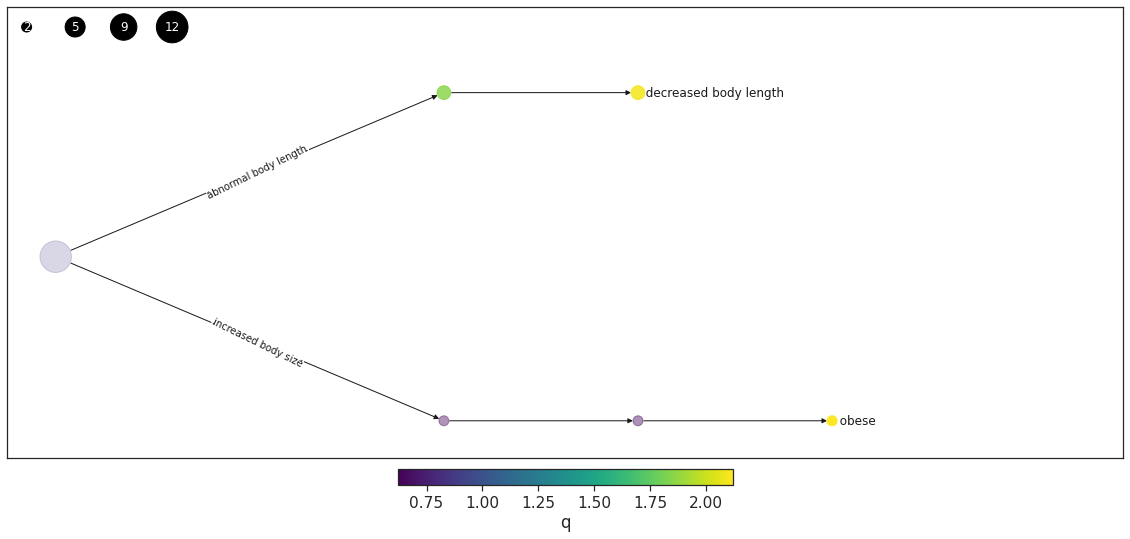

In [494]:
print("Growth/Body Size")
n = draw_significance_hierarchy(results_old, "C882", "MP:0003956", mp_graph, MPO2, hier_df_genes, term_mapping, select_on="proportion", 
                                size_by="obs", alpha_by="OR",color_by="q", vert=10, label="leaf", descriptive_labels=True, adjust_root=0.2)

In [495]:
n

OR         q   obs  \
MP:0003956  1.874094  0.852578  12.0   
MP:0001264  2.342534  0.621372   2.0   
MP:0001260  2.413987  0.651710   2.0   
MP:0001261  6.969935  2.118813   2.0   
MP:0001256  4.338516  1.851297   3.0   
MP:0001258  4.878684  2.093820   3.0   

                                                         hits  
MP:0003956  [C2CD5, KDM3B, SPG7, CCP110, PHF2, KDM6A, ZBTB...  
MP:0001264                                     [C2CD5, KDM3A]  
MP:0001260                                     [C2CD5, KDM3A]  
MP:0001261                                     [C2CD5, KDM3A]  
MP:0001256                              [PHF2, ZBTB20, AXIN1]  
MP:0001258                              [PHF2, ZBTB20, AXIN1]

Cellular Phys
PARENT: MP:0005621 abnormal cell physiology


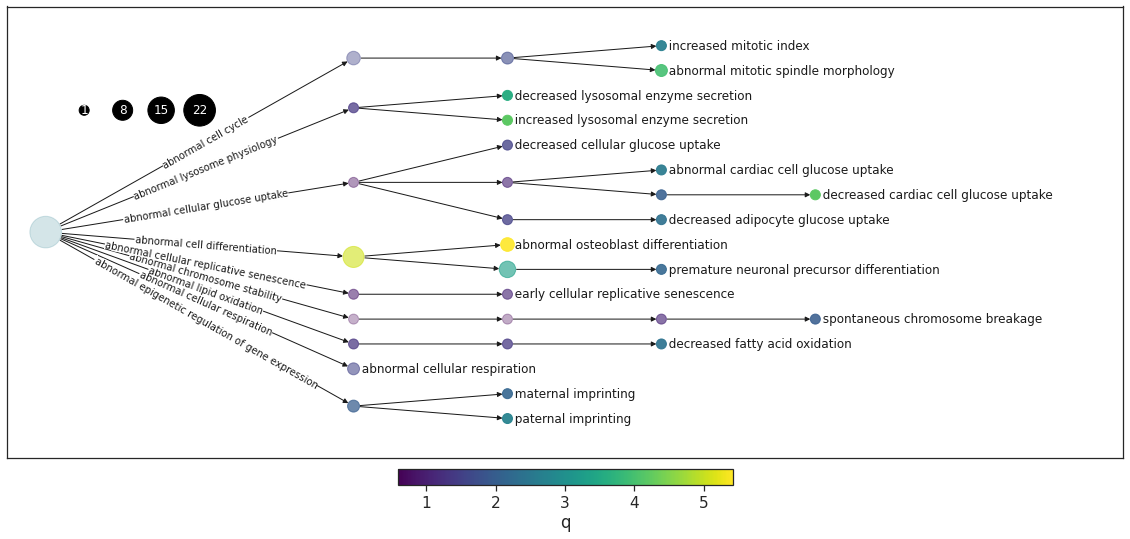

In [453]:
print("Cellular Phys")
n = draw_significance_hierarchy(results_old, "C882", "MP:0005621", mp_graph, MPO2, hier_df_genes, term_mapping, select_on="proportion", 
                                size_by="obs", alpha_by="OR",color_by="q", vert=10, label="leaf", descriptive_labels=True, adjust_root=0.2)

Embryo Dev
PARENT: MP:0001672 abnormal embryo development


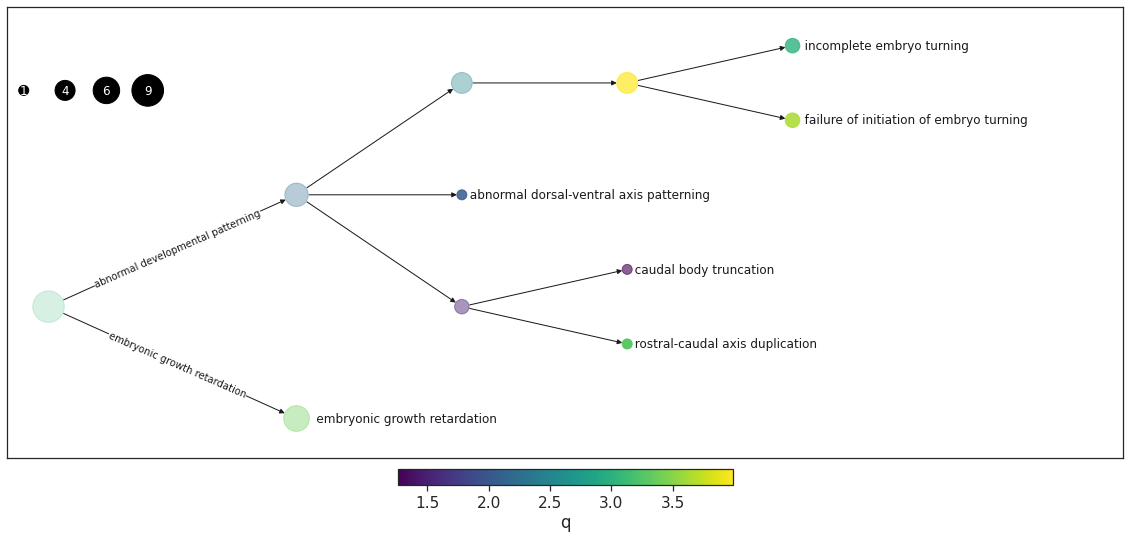

In [536]:
print("Embryo Dev")
n = draw_significance_hierarchy(results_old, "C882", "MP:0001672", mp_graph, MPO2, hier_df_genes, term_mapping, select_on="proportion", 
                                size_by="obs", alpha_by="OR",color_by="q", vert=10, label="leaf", descriptive_labels=True, adjust_root=0.1)

Embryo Morph
PARENT: MP:0014134 abnormal embryo morphology


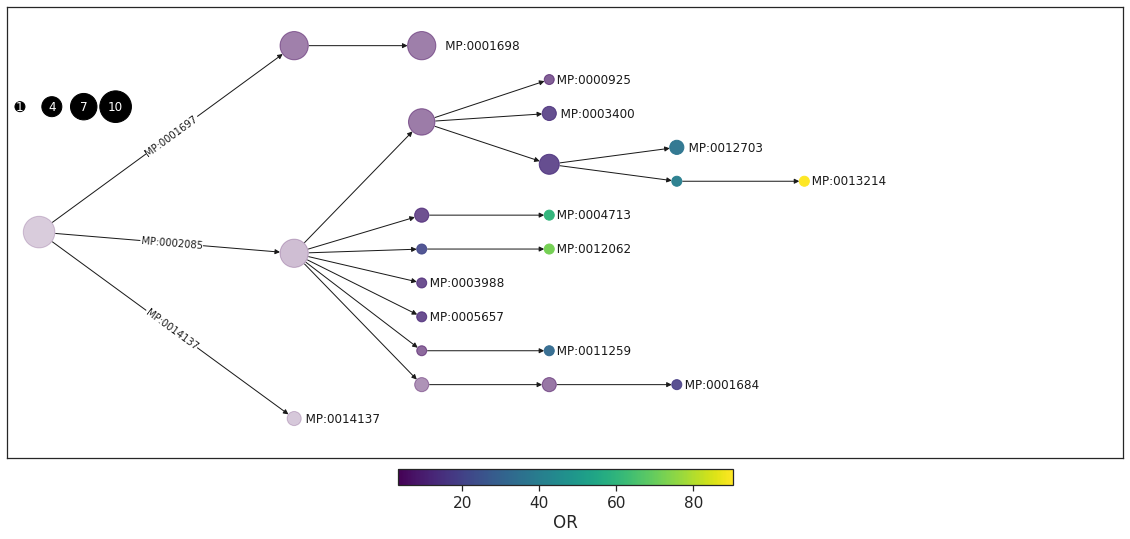

In [539]:
print("Embryo Morph")
n = draw_significance_hierarchy(results_old, "C882", "MP:0014134", mp_graph, MPO2, hier_df_genes, term_mapping, select_on="proportion", 
                                size_by="obs", alpha_by="OR",color_by="OR", vert=10, label="leaf", descriptive_labels=False, adjust_root=0.2)

In [543]:
n.loc["MP:0001697"].hits

['NUMBL', 'NFATC3', 'UBR2', 'KDM8', 'KDM6A', 'WNK1', 'AXIN1', 'STK4']

Nervous System Morph
PARENT: MP:0003632 abnormal nervous system morphology


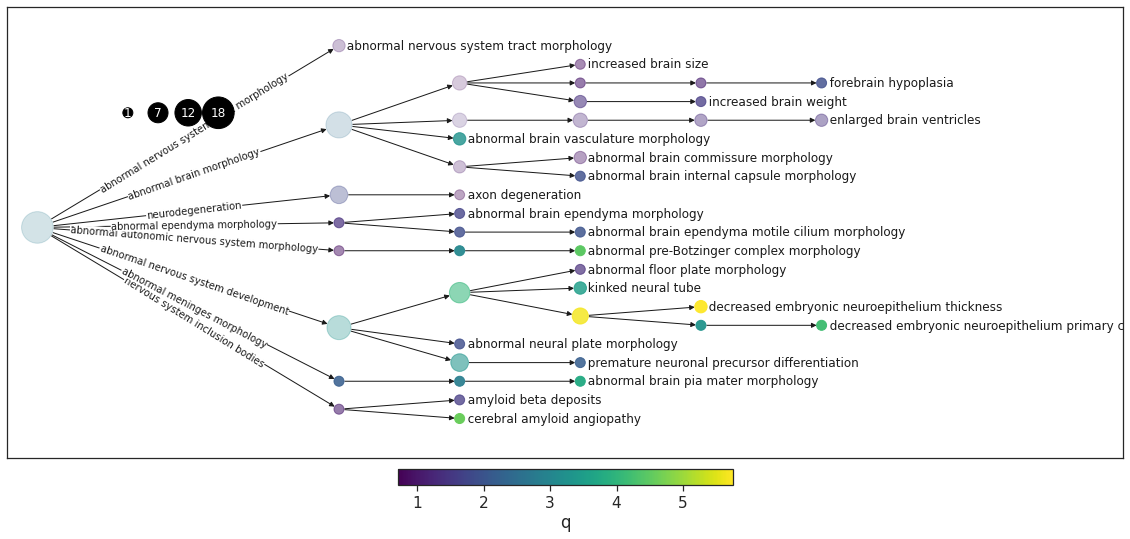

In [457]:
print("Nervous System Morph")
n = draw_significance_hierarchy(results_old, "C882", "MP:0003632", mp_graph, MPO2, hier_df_genes, term_mapping, select_on="proportion", 
                                size_by="obs", alpha_by="OR",color_by="q", vert=10, label="leaf", descriptive_labels=True, adjust_root=0.3)

# Ignore - New MGI data

In [125]:
mgi_df_new = load_MGI_mouseKO_data(url='http://www.informatics.jax.org/downloads/reports/MGI_PhenoGenoMP.rpt', map_using="mgi2", update=False)

In [126]:
mgi_df_new.head()

MGI_Allele_Accession_ID Allele symbol               involves          MP  \
0  Rb1<tm1Tyj>/Rb1<tm1Tyj>   Rb1<tm1Tyj>  involves: 129S2/SvPas  MP:0000600   
1  Rb1<tm1Tyj>/Rb1<tm1Tyj>   Rb1<tm1Tyj>  involves: 129S2/SvPas  MP:0001716   
2  Rb1<tm1Tyj>/Rb1<tm1Tyj>   Rb1<tm1Tyj>  involves: 129S2/SvPas  MP:0001698   
3  Rb1<tm1Tyj>/Rb1<tm1Tyj>   Rb1<tm1Tyj>  involves: 129S2/SvPas  MP:0001092   
4  Rb1<tm1Tyj>/Rb1<tm1Tyj>   Rb1<tm1Tyj>  involves: 129S2/SvPas  MP:0000961   

       PMID        MGI gene_name                       Marker Name  \
0  12529408  MGI:97874       Rb1  RB transcriptional corepressor 1   
1  16449662  MGI:97874       Rb1  RB transcriptional corepressor 1   
2  16449662  MGI:97874       Rb1  RB transcriptional corepressor 1   
3  16449662  MGI:97874       Rb1  RB transcriptional corepressor 1   
4  16449662  MGI:97874       Rb1  RB transcriptional corepressor 1   

  human_ortholog  
0            RB1  
1            RB1  
2            RB1  
3            RB1  
4            RB1

In [127]:
MPO_new = load_MPO(use_genes=True, mapping=mgi_df_new)

14555


In [128]:
term_counts_new, gene_mapping_new, term_mapping_new = genes_per_node(MPO_new)

In [129]:
tc = pd.DataFrame.from_dict(term_counts_new, orient="index", columns=["new"])
tc = tc.join(pd.DataFrame.from_dict(term_counts, orient="index", columns=["original"]))

Text(0.5, 1.0, 'Number of genes per term')

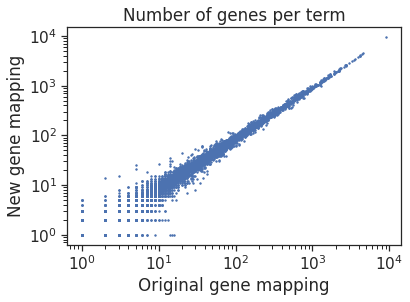

In [130]:
plt.scatter(data=tc, x="original", y="new", s=2)
plt.xscale("log")
plt.yscale("log")
plt.xlabel("Original gene mapping")
plt.ylabel("New gene mapping")
plt.title("Number of genes per term")

In [131]:
phenotypes = []
term_counts, gene_mapping, term_mapping = genes_per_node(MPO_new)
for community in tqdm(hier_df_genes.index):
    x = community_term_enrichment_old(community, hier_df_genes, MPO_new, mgi_df_new, term_counts, gene_mapping)
    x = x.assign(name=community)
    phenotypes.append(x)

 18%|█▊        | 11/61 [00:04<00:07,  6.34it/s]

0/6 in MPO.genes/seeds


 80%|████████  | 49/61 [00:13<00:00, 12.52it/s]

0/6 in MPO.genes/seeds


100%|██████████| 61/61 [00:15<00:00,  3.93it/s]

0/4 in MPO.genes/seeds


In [132]:
new_results = pd.concat(phenotypes)
new_results.head()

observed   total        OR      OR_p  OR_CI_lower  OR_CI_upper  \
MP:0000001     365.0  9532.0  1.295266  0.001414     1.105006     1.518284   
MP:0010768     182.0  4496.0  1.271516  0.007139     1.067382     1.514691   
MP:0010769     171.0  4002.0  1.359641  0.000747     1.137280     1.625477   
MP:0005384     169.0  4301.0  1.214557  0.033346     1.015458     1.452693   
MP:0005378     157.0  3997.0  1.208691  0.042875     1.006099     1.452078   

             hyper_p sig_5e6                        description   size  name  
MP:0000001  0.000587   False                mammalian phenotype  642.0  C877  
MP:0010768  0.003486   False                    mortality/aging  642.0  C877  
MP:0010769  0.000405   False                  abnormal survival  642.0  C877  
MP:0005384  0.015739   False                 cellular phenotype  642.0  C877  
MP:0005378  0.020181   False  growth/size/body region phenotype  642.0  C877

In [133]:
results_old.head()

observed   total        OR      OR_p  OR_CI_lower  OR_CI_upper  \
MP:0000001     359.0  9108.0  1.367147  0.000110     1.166759     1.601951   
MP:0010768     194.0  4591.0  1.357213  0.000494     1.142930     1.611671   
MP:0010769     184.0  4194.0  1.419438  0.000084     1.192004     1.690267   
MP:0005384     182.0  4343.0  1.332818  0.001300     1.118747     1.587851   
MP:0010770     171.0  3621.0  1.549886  0.000002     1.296036     1.853458   

             hyper_p  sig_5e6           description   size  name  
MP:0000001  0.000044    False   mammalian phenotype  642.0  C877  
MP:0010768  0.000263    False       mortality/aging  642.0  C877  
MP:0010769  0.000050    False     abnormal survival  642.0  C877  
MP:0005384  0.000676    False    cellular phenotype  642.0  C877  
MP:0010770  0.000001     True  preweaning lethality  642.0  C877

In [99]:
b[b.description=="abnormal consumption behavior"]

observed  total        OR      OR_p  OR_CI_lower  OR_CI_upper  \
MP:0002069      13.0  776.0  1.953692  0.021381     1.104406     3.456076   
MP:0002069       1.0  776.0  2.909032  0.314344     0.363390    23.287558   

             hyper_p sig_5e6                    description   size  name  \
MP:0002069  0.010349   False  abnormal consumption behavior  169.0  C879   
MP:0002069  0.050423   False  abnormal consumption behavior    9.0  C907   

                   q   q_hyper  
MP:0002069  0.050112  0.023634  
MP:0002069  0.442123  0.087947

In [104]:
term_counts, gene_mapping, term_mapping = genes_per_node(MPO2)

In [102]:
term_counts_new["MP:0002069"]

776

In [105]:
term_counts["MP:0002069"]

655

In [116]:
old_genes = term_mapping["MP:0002069"]
old_genes = [MPO2.genes[i] for i in old_genes]
old_genes = set(old_genes)

In [115]:
new_genes = term_mapping["MP:0002069"]
new_genes = [MPO_new.genes[i] for i in new_genes]
new_genes = set(new_genes)

In [120]:
new_genes

{'AATK',
 'ABHD12',
 'ABR',
 'ACAA1',
 'ACACB',
 'ACAD8',
 'ACADM',
 'ACADVL',
 'ACKR2',
 'ACKR3',
 'ACP5',
 'ACSBG1',
 'ACTG1',
 'ADAMTS7',
 'ADGRA2',
 'ADGRE2',
 'ADGRF5',
 'ADGRG2',
 'ADGRL1',
 'ADK',
 'ADORA2B',
 'ADRA2A',
 'AFG3L1P',
 'AGAP3',
 'AGBL2',
 'AGBL4',
 'AKIRIN2',
 'AKR1A1',
 'AKT1',
 'ALAS2',
 'ALDH16A1',
 'ALDH3A2',
 'ALDH7A1',
 'AMOT',
 'ANO2',
 'ANXA2',
 'ANXA3',
 'ANXA4',
 'ANXA7',
 'AP1M1',
 'AP1S2',
 'AP4B1',
 'APBA1',
 'APBA2',
 'APELA',
 'APMAP',
 'APOBEC3D',
 'ARFGEF3',
 'ARHGAP32',
 'ARHGEF2',
 'ARHGEF7',
 'ARL13B',
 'ARPC4-TTLL3',
 'ARR3',
 'ARRB2',
 'AS3MT',
 'ASAP1',
 'ASB2',
 'ASIP',
 'ASPA',
 'ASXL1',
 'ASZ1',
 'ATE1',
 'ATG9A',
 'ATMIN',
 'AURKB',
 'AUTS2',
 'AVIL',
 'AVP',
 'AVPR1A',
 'AVPR1B',
 'AWAT2',
 'B3GAT3',
 'B3GNT7',
 'BACE2',
 'BAIAP2',
 'BAIAP2L2',
 'BBLN',
 'BCL3',
 'BECN2',
 'BFSP1',
 'BHLHA9',
 'BHLHE40',
 'BHLHE41',
 'BID',
 'BIRC3',
 'BNC1',
 'BNIP3L',
 'BOLL',
 'BPHL',
 'BRK1',
 'BSND',
 'BTNL8',
 'C17orf64',
 'C5AR1',
 'C6',
 'CA7',
 

In [121]:
old_genes

{'ABCA12',
 'ABHD6',
 'ACACB',
 'ACADS',
 'ACAN',
 'ACBD5',
 'ACE',
 'ACER1',
 'ACOT11',
 'ACOT13',
 'ACSS1',
 'ACTB',
 'ACVR1',
 'ADCY6',
 'ADGRL3',
 'ADIPOQ',
 'ADIPOR2',
 'ADM',
 'ADORA2A',
 'ADRB3',
 'AFAP1',
 'AFMID',
 'AGPAT2',
 'AGRP',
 'AGT',
 'AGTR2',
 'ALDH2',
 'ALDH3A2',
 'ALK',
 'ALKBH7',
 'ALMS1',
 'ALX1',
 'ALX4',
 'ANKRD26',
 'APBA2',
 'APLNR',
 'APLP2',
 'APMAP',
 'APOA4',
 'APOC3',
 'APOE',
 'APRT',
 'AQP2',
 'AQP3',
 'ARAF',
 'ARFGEF1',
 'ARHGAP17',
 'ARID5B',
 'ARNT2',
 'ARV1',
 'ASCL1',
 'ASL',
 'ATE1',
 'ATF3',
 'ATF5',
 'ATG5',
 'ATM',
 'ATN1',
 'ATP1B2',
 'ATP2B1',
 'ATP6V0A1',
 'ATP6V0A4',
 'ATP8A2',
 'AVP',
 'AVPR2',
 'BBIP1',
 'BBS1',
 'BBS10',
 'BBS12',
 'BBS2',
 'BBS4',
 'BBS7',
 'BCAT2',
 'BCL11B',
 'BCLAF1',
 'BDNF',
 'BECN2',
 'BIN1',
 'BMPR1A',
 'BRAF',
 'BRD2',
 'BRINP1',
 'BRPF1',
 'BRS3',
 'BSCL2',
 'BSX',
 'C1QTNF5',
 'C1QTNF9',
 'C3',
 'C5AR2',
 'CACNA1B',
 'CACNA2D2',
 'CALCA',
 'CAMKK2',
 'CARTPT',
 'CASK',
 'CASR',
 'CAV1',
 'CBL',
 'CCDC80',
 'C